# Download Packages

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
 from sklearn.compose import ColumnTransformer
 from sklearn.preprocessing import OrdinalEncoder
 from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from lightgbm import LGBMRegressor
# Install lightgbm
%pip install lightgbm

import lightgbm as lgb
import pandas as pd
import numpy as np

# Install xgboost
%pip install xgboost
import xgboost as xgb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Configuration pour un meilleur affichage des DataFrames
pd.set_option('display.max_rows', 50)     # Nombre de lignes à afficher
pd.set_option('display.max_columns', 100)  # Nombre de colonnes à afficher
pd.set_option('display.max_colwidth', 100) # Largeur maximale des colonnes
pd.set_option('display.width', 1000)       # Largeur totale de l'affichage

# 0. Download

In [4]:
data = pd.read_parquet('./data/train.parquet')
data_copy = data.copy()
data.head()

counter_id              counter_name    site_id             site_name  bike_count                date counter_installation_date         coordinates counter_technical_id   latitude  longitude  log_bike_count
48321  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         0.0 2020-09-01 02:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846028   2.375429        0.000000
48324  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         1.0 2020-09-01 03:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846028   2.375429        0.693147
48327  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         0.0 2020-09-01 04:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846028   2.375429        0.000000
48330  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         4.0 2020-09-01 15:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846028   2.375429        1.609438
48333  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         9.0 2020-09-01 18:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846028   2.375429        2.302585

In [5]:
test_data = pd.read_parquet('../bike_counters/data/final_test.parquet')

# 1. Cleaning the Data

## Missing Values

### One counter is missing

In [6]:
# Group by counter_name and select the first occurrence of counter_installation_date
installation_dates = data.groupby('counter_name')['counter_installation_date'].first().reset_index()

# Display the table
installation_dates.sort_values('counter_installation_date')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/2609972847.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  installation_dates = data.groupby('counter_name')['counter_installation_date'].first().reset_index()


counter_name counter_installation_date
11           28 boulevard Diderot O-E                2013-01-18
10           28 boulevard Diderot E-O                2013-01-18
16     39 quai François Mauriac NO-SE                2017-07-12
2   18 quai de l'Hôtel de Ville NO-SE                2017-07-12
3   18 quai de l'Hôtel de Ville SE-NO                2017-07-12
..                                ...                       ...
4           20 Avenue de Clichy NO-SE                2020-07-22
5           20 Avenue de Clichy SE-NO                2020-07-22
21             90 Rue De Sèvres NE-SO                2020-07-22
6          254 rue de Vaugirard NE-SO                2020-11-29
7          254 rue de Vaugirard SO-NE                2020-11-29

[56 rows x 2 columns]

### Missing Values information

In [9]:
missing_values = data.isnull().sum()
print(missing_values)

counter_id                   0
counter_name                 0
site_id                      0
site_name                    0
bike_count                   0
date                         0
counter_installation_date    0
coordinates                  0
counter_technical_id         0
latitude                     0
longitude                    0
log_bike_count               0
dtype: int64


In [10]:
zero_counts = (data == 0).sum()
print(zero_counts)

counter_id                       0
counter_name                     0
site_id                          0
site_name                        0
bike_count                   41401
date                             0
counter_installation_date        0
coordinates                      0
counter_technical_id             0
latitude                         0
longitude                        0
log_bike_count               41401
dtype: int64


## Weather

In [11]:
weather = pd.read_csv(
    "../bike_counters/external_data/H75 Previous 2020-2022.csv (1).gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

weather = weather[
    (weather["date"] >= data["date"].min())
    & (weather["date"] <= test_data["date"].max())
]

weather_reduced = (
    weather.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
    .groupby("date")
    .mean()
    .dropna(axis=1, how="all")
    .interpolate(method="linear")
)

weather_reduced["is_rain"] = (weather_reduced["RR1"] > 0).astype(int)

In [12]:
data = data.merge(weather_reduced, on="date", how="left")
test_data = test_data.merge(weather_reduced, on="date", how="left")

### Adding Rain Category

In [13]:
bins = [0, 0.2, 1, 5, 10, float('inf')]
labels = ['No rain', 'Light', 'Moderate', 'Heavy', 'Very Heavy']

# Create rain categories
data['rain_category'] = pd.cut(data['RR1'], bins=bins, labels=labels)
test_data['rain_category'] = pd.cut(test_data['RR1'], bins=bins, labels=labels)

### Adding Temperature Category

In [14]:
bins = [-float('inf'), 5, 15, 22, 28, float('inf')]
labels = ['Cold', 'Cool', 'Moderate', 'Warm', 'Hot']

data['temp_category'] = pd.cut(data['TNSOL'], bins=bins, labels=labels)
test_data['temp_category'] = pd.cut(test_data['TNSOL'], bins=bins, labels=labels)

## Time Data

In [15]:
# Features de date basiques
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['hour'] = data['date'].dt.hour
data['week_number'] = data['date'].dt.isocalendar().week
data['period_of_day'] = pd.cut(
    data['hour'], 
    bins=[-1, 4, 9, 17, 20, 23],
    labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
)
# Night hours have significantly more zeros (23:00-04:00)
data['is_night'] = data['hour'].isin([23, 0, 1, 2, 3, 4, 5]).astype(int)

# Add weekend variations
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(int)
data['is_weekend_night'] = (data['is_night'] & data['is_weekend']).astype(int)

# Early morning transition (5:00-7:00)
data['is_early_morning'] = data['hour'].isin([6, 7, 8]).astype(int)

# Interaction between weekday and period of day
data['period_of_day_num'] = data['period_of_day'].cat.codes
data['weekday_period'] = data['weekday'] * data['period_of_day_num']

# Interaction between weekday and is_night
data['weekday_is_night'] = data['weekday'] * data['is_night']

# Interaction between hour and weekday
data['hour_weekday'] = data['hour'] * data['weekday']

In [16]:
# Features de date basiques
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['weekday'] = test_data['date'].dt.weekday
test_data['hour'] = test_data['date'].dt.hour
test_data['week_number'] = test_data['date'].dt.isocalendar().week

# Categorizing time of day
test_data['period_of_day'] = pd.cut(
    test_data['hour'], 
    bins=[-1, 4, 9, 17, 20, 23],
    labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
)

# Identifying night and early morning hours
test_data['is_night'] = test_data['hour'].isin([23, 0, 1, 2, 3, 4, 5]).astype(int)
test_data['is_early_morning'] = test_data['hour'].isin([6, 7, 8]).astype(int)

test_data['is_weekend'] = test_data['weekday'].isin([5, 6]).astype(int)
test_data['is_weekend_night'] = (test_data['is_night'] & test_data['is_weekend']).astype(int)

# Features Interactions

# Interaction between weekday and period of day
test_data['period_of_day_num'] = test_data['period_of_day'].cat.codes
test_data['weekday_period'] = test_data['weekday'] * test_data['period_of_day_num']

# Interaction between weekday and is_night
test_data['weekday_is_night'] = test_data['weekday'] * test_data['is_night']

# Interaction between hour and weekday
test_data['hour_weekday'] = test_data['hour'] * test_data['weekday']

#### DDD : Encodage Cyclique

In [17]:
# Encodage cyclique
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['day_sin'] = np.sin(2 * np.pi * data['weekday']/7)
data['day_cos'] = np.cos(2 * np.pi * data['weekday']/7)

In [18]:
# Encodage cyclique
test_data['hour_sin'] = np.sin(2 * np.pi * test_data['hour']/24)
test_data['hour_cos'] = np.cos(2 * np.pi * test_data['hour']/24) 
test_data['day_sin'] = np.sin(2 * np.pi * test_data['weekday']/7)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['weekday']/7)

### DDD : Adding the bank holidays

In [19]:
# Adding the bank holidays

import datetime
from jours_feries_france import JoursFeries

In [20]:
# Create a holiday object for France
import holidays
holidays = holidays.CountryHoliday('France') # Import the bank Holidays

# Function to check if a date is a holiday
def is_bank_holiday(date):
    return 1 if date in holidays else 0

# Add a "Holiday" column to the DataFrame
data['is_bank_holiday'] = data['date'].apply(is_bank_holiday)
test_data['is_bank_holiday'] = test_data['date'].apply(is_bank_holiday)

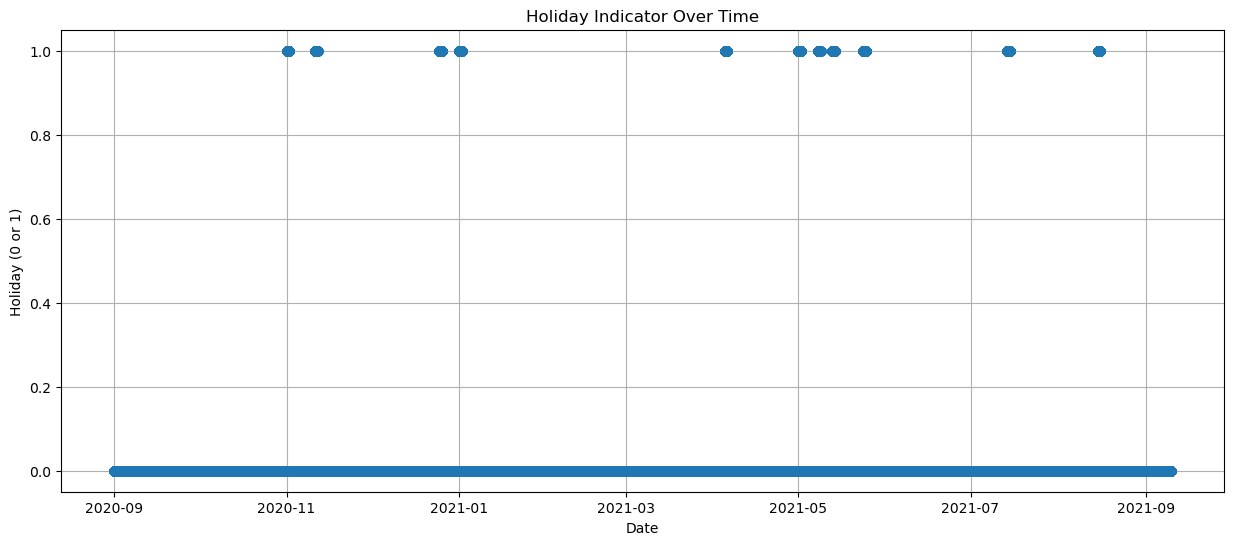

In [21]:
# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['is_bank_holiday'], marker='o', linestyle='None')
plt.title('Holiday Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('Holiday (0 or 1)')
plt.grid(True)
plt.show()

### DDD - Vacances scolaires

In [22]:
pip install vacances-scolaires-france

Note: you may need to restart the kernel to use updated packages.


In [23]:
from vacances_scolaires_france import SchoolHolidayDates

In [24]:
from pathlib import Path
import pandas as pd

def get_school_holidays(dates, cache_file='school_holidays_cache.pkl'):
    """
    Get school holiday information with improved error handling and NaN management
    
    Parameters:
    -----------
    dates : pandas.Series or pandas.DatetimeIndex
        The dates to check for school holidays
    cache_file : str, optional
        Path to the cache file
        
    Returns:
    --------
    pandas.Series
        Binary values indicating school holidays (1) or not (0)
    """
    try:
        # Load from cache if available
        if Path(cache_file).exists():
            print("Loading school holidays from cache...")
            holiday_dict = pd.read_pickle(cache_file)
        else:
            print("Calculating school holidays...")
            school_holidays = SchoolHolidayDates()
            
            # Get unique dates to reduce computation
            unique_dates = pd.Series(dates).dt.date.unique()
            
            # Create holiday dictionary
            holiday_dict = {}
            for date in unique_dates:
                try:
                    holiday_dict[date] = school_holidays.is_holiday_for_zone(date, 'C')
                except:
                    # If there's an error for a specific date, mark as non-holiday
                    holiday_dict[date] = False
            
            # Save to cache
            pd.to_pickle(holiday_dict, cache_file)
        
        # Map dates to holiday status
        holiday_series = pd.Series(dates).dt.date.map(holiday_dict)
        
        # Handle NaN values before integer conversion
        holiday_series = holiday_series.fillna(False)
        
        # Convert to int (False -> 0, True -> 1)
        return holiday_series.astype(int)
        
    except Exception as e:
        print(f"Warning: Error processing school holidays: {e}")
        # Return default values (no holidays) if there's an error
        return pd.Series(0, index=dates.index)

# Utilisation
data["is_school_holidays"] = get_school_holidays(data["date"])
test_data["is_school_holidays"] = get_school_holidays(test_data["date"])

Loading school holidays from cache...
Loading school holidays from cache...


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/1501239002.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  holiday_series = holiday_series.fillna(False)


In [25]:
print(data["is_school_holidays"].value_counts())

print(data[data["is_school_holidays"] == 1].head())

is_school_holidays
0    328313
1    168514
Name: count, dtype: int64
              counter_id              counter_name    site_id             site_name  bike_count                date counter_installation_date         coordinates counter_technical_id   latitude  longitude  log_bike_count        ALTI  RR1  QRR1  DRR1  QDRR1        FF  QFF          DD  QDD       FXY  QFXY         DXY  QDXY          HXY  QHXY       FXI  QFXI         DXI  QDXI          HXI  QHXI  FXI3S  QFXI3S  HFXI3S  QHFXI3S          T   QT    TD  QTD         TN  QTN          HTN  QHTN         TX  QTX          HTX  QHTX   DG  ...  DHUMI80  QDHUMI80    TSV  QTSV    PMER  QPMER   PSTAT  QPSTAT  PMERMIN  QPMERMIN       VV  QVV  DVV200  QDVV200   WW  QWW  NEIGETOT  QNEIGETOT   GLO  QGLO  GLO2  QGLO2  INS  QINS  INS2  QINS2  is_rain  rain_category  temp_category  year  month  day  weekday  hour  week_number  period_of_day  is_night  is_weekend  is_weekend_night  is_early_morning  period_of_day_num  weekday_period  weekday_is

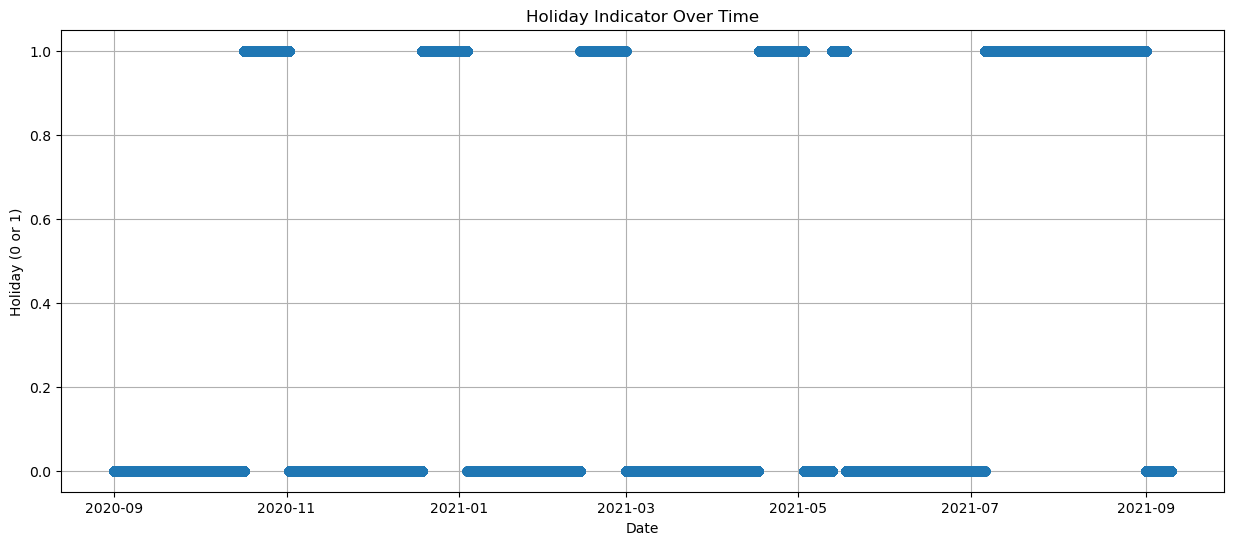

In [26]:
# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['is_school_holidays'], marker='o', linestyle='None')
plt.title('Holiday Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('Holiday (0 or 1)')
plt.grid(True)
plt.show()

### DDD : Add Covid Information

In [27]:
def add_covid_features(df):
    """
    Ajoute les features liées aux restrictions COVID à un DataFrame existant.
    
    Parameters:
    df : DataFrame avec une colonne 'date' au format datetime
    
    Returns:
    DataFrame avec les nouvelles colonnes COVID
    """
    df_copy = df.copy()
    
    # Définition des périodes clés
    periodes = {
        # Confinements
        'confinement_2': ('2020-10-30', '2020-12-15'),
        'confinement_3': ('2021-03-20', '2021-05-03'),
        
        # Périodes de couvre-feu
        'couvre_feu_21h': ('2020-10-17', '2020-10-29'),
        'couvre_feu_20h': ('2020-12-15', '2021-01-15'),
        'couvre_feu_18h': ('2021-01-16', '2021-05-18'),
        'couvre_feu_21h_2': ('2021-05-19', '2021-06-08'),
        'couvre_feu_23h': ('2021-06-09', '2021-06-20')
    }
    
    # Création des colonnes binaires pour chaque période
    for periode_name, (start, end) in periodes.items():
        df_copy[periode_name] = ((df_copy['date'] >= start) & 
                                (df_copy['date'] <= end)).astype(int)
    
    # Colonne pour le rayon de déplacement (en km)
    df_copy['rayon_deplacement_km'] = 0
    mask_1km = (df_copy['date'] >= '2020-10-30') & (df_copy['date'] <= '2020-12-15')
    mask_10km = (df_copy['date'] >= '2021-03-20') & (df_copy['date'] <= '2021-05-03')
    df_copy.loc[mask_1km, 'rayon_deplacement_km'] = 1
    df_copy.loc[mask_10km, 'rayon_deplacement_km'] = 10
    
    # Colonne pour l'heure de début du couvre-feu
    df_copy['heure_couvre_feu'] = 0
    df_copy.loc[(df_copy['date'] >= '2020-10-17') & (df_copy['date'] <= '2020-10-29'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2020-12-15') & (df_copy['date'] <= '2021-01-15'), 'heure_couvre_feu'] = 20
    df_copy.loc[(df_copy['date'] >= '2021-01-16') & (df_copy['date'] <= '2021-05-18'), 'heure_couvre_feu'] = 18
    df_copy.loc[(df_copy['date'] >= '2021-05-19') & (df_copy['date'] <= '2021-06-08'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2021-06-09') & (df_copy['date'] <= '2021-06-20'), 'heure_couvre_feu'] = 23
    
    return df_copy

In [28]:
def add_covid_time_features(df):
    """
    Adds features that combine COVID restrictions with time information.
    Curfew ends at 6am the next day.
    """
    df = df.copy()
    
    # Initialize column
    df['is_during_curfew'] = 0
    
    # Extract hour
    hour = df['date'].dt.hour
    
    # Curfew periods with their start hours
    curfew_periods = {
        'couvre_feu_21h': 21,    
        'couvre_feu_20h': 20,    
        'couvre_feu_18h': 18,    
        'couvre_feu_21h_2': 21,  
        'couvre_feu_23h': 23,    
    }
    
    for period, start_hour in curfew_periods.items():
        mask = df[period] == 1
        df.loc[mask & ((hour >= start_hour) | (hour < 6)), 'is_during_curfew'] = 1
    
    # Lockdown distance restrictions
    lockdown_mask = (df['confinement_2'] == 1) | (df['confinement_3'] == 1)
    df['is_within_allowed_distance'] = 0
    df.loc[lockdown_mask & (df['rayon_deplacement_km'] > 0), 'is_within_allowed_distance'] = 1
    
    return df

In [29]:
# Add the new features
data = add_covid_features(data)
data = add_covid_time_features(data)
test_data = add_covid_features(test_data)
test_data = add_covid_time_features(test_data)

# Test verification
test_date = pd.to_datetime("2020-10-20")  # During couvre_feu_21h period
test_hours = [5, 15, 21, 22]  # Various times to test

print("\nTesting curfew detection:")
for hour in test_hours:
    test_timestamp = test_date + pd.Timedelta(hours=hour)
    mask = data['date'] == test_timestamp
    if len(data[mask]) > 0:
        print(f"\nHour {hour}:00")
        print(f"During curfew: {data[mask]['is_during_curfew'].values[0]}")
        print(f"Curfew active: {data[mask]['couvre_feu_21h'].values[0]}")


Testing curfew detection:

Hour 5:00
During curfew: 1
Curfew active: 1

Hour 15:00
During curfew: 0
Curfew active: 1

Hour 21:00
During curfew: 1
Curfew active: 1

Hour 22:00
During curfew: 1
Curfew active: 1


##### Testing the data date per date

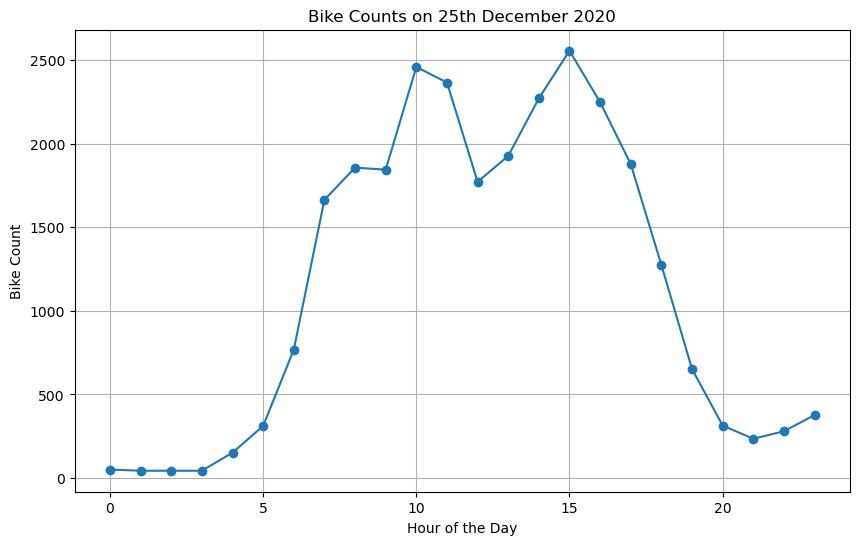

In [30]:
# Filter data for the specific date
specific_date_data = data[data["date"].dt.date == datetime.date(2020, 12, 24)]

# Group by hour and sum the bike counts
hourly_bike_counts = specific_date_data.groupby(specific_date_data["date"].dt.hour)["bike_count"].sum()

# Plot the bike counts for each hour of the specific date
plt.figure(figsize=(10, 6))
plt.plot(hourly_bike_counts.index, hourly_bike_counts.values, marker='o')
plt.title("Bike Counts on 25th December 2020")
plt.xlabel("Hour of the Day")
plt.ylabel("Bike Count")
plt.grid(True)
plt.show()

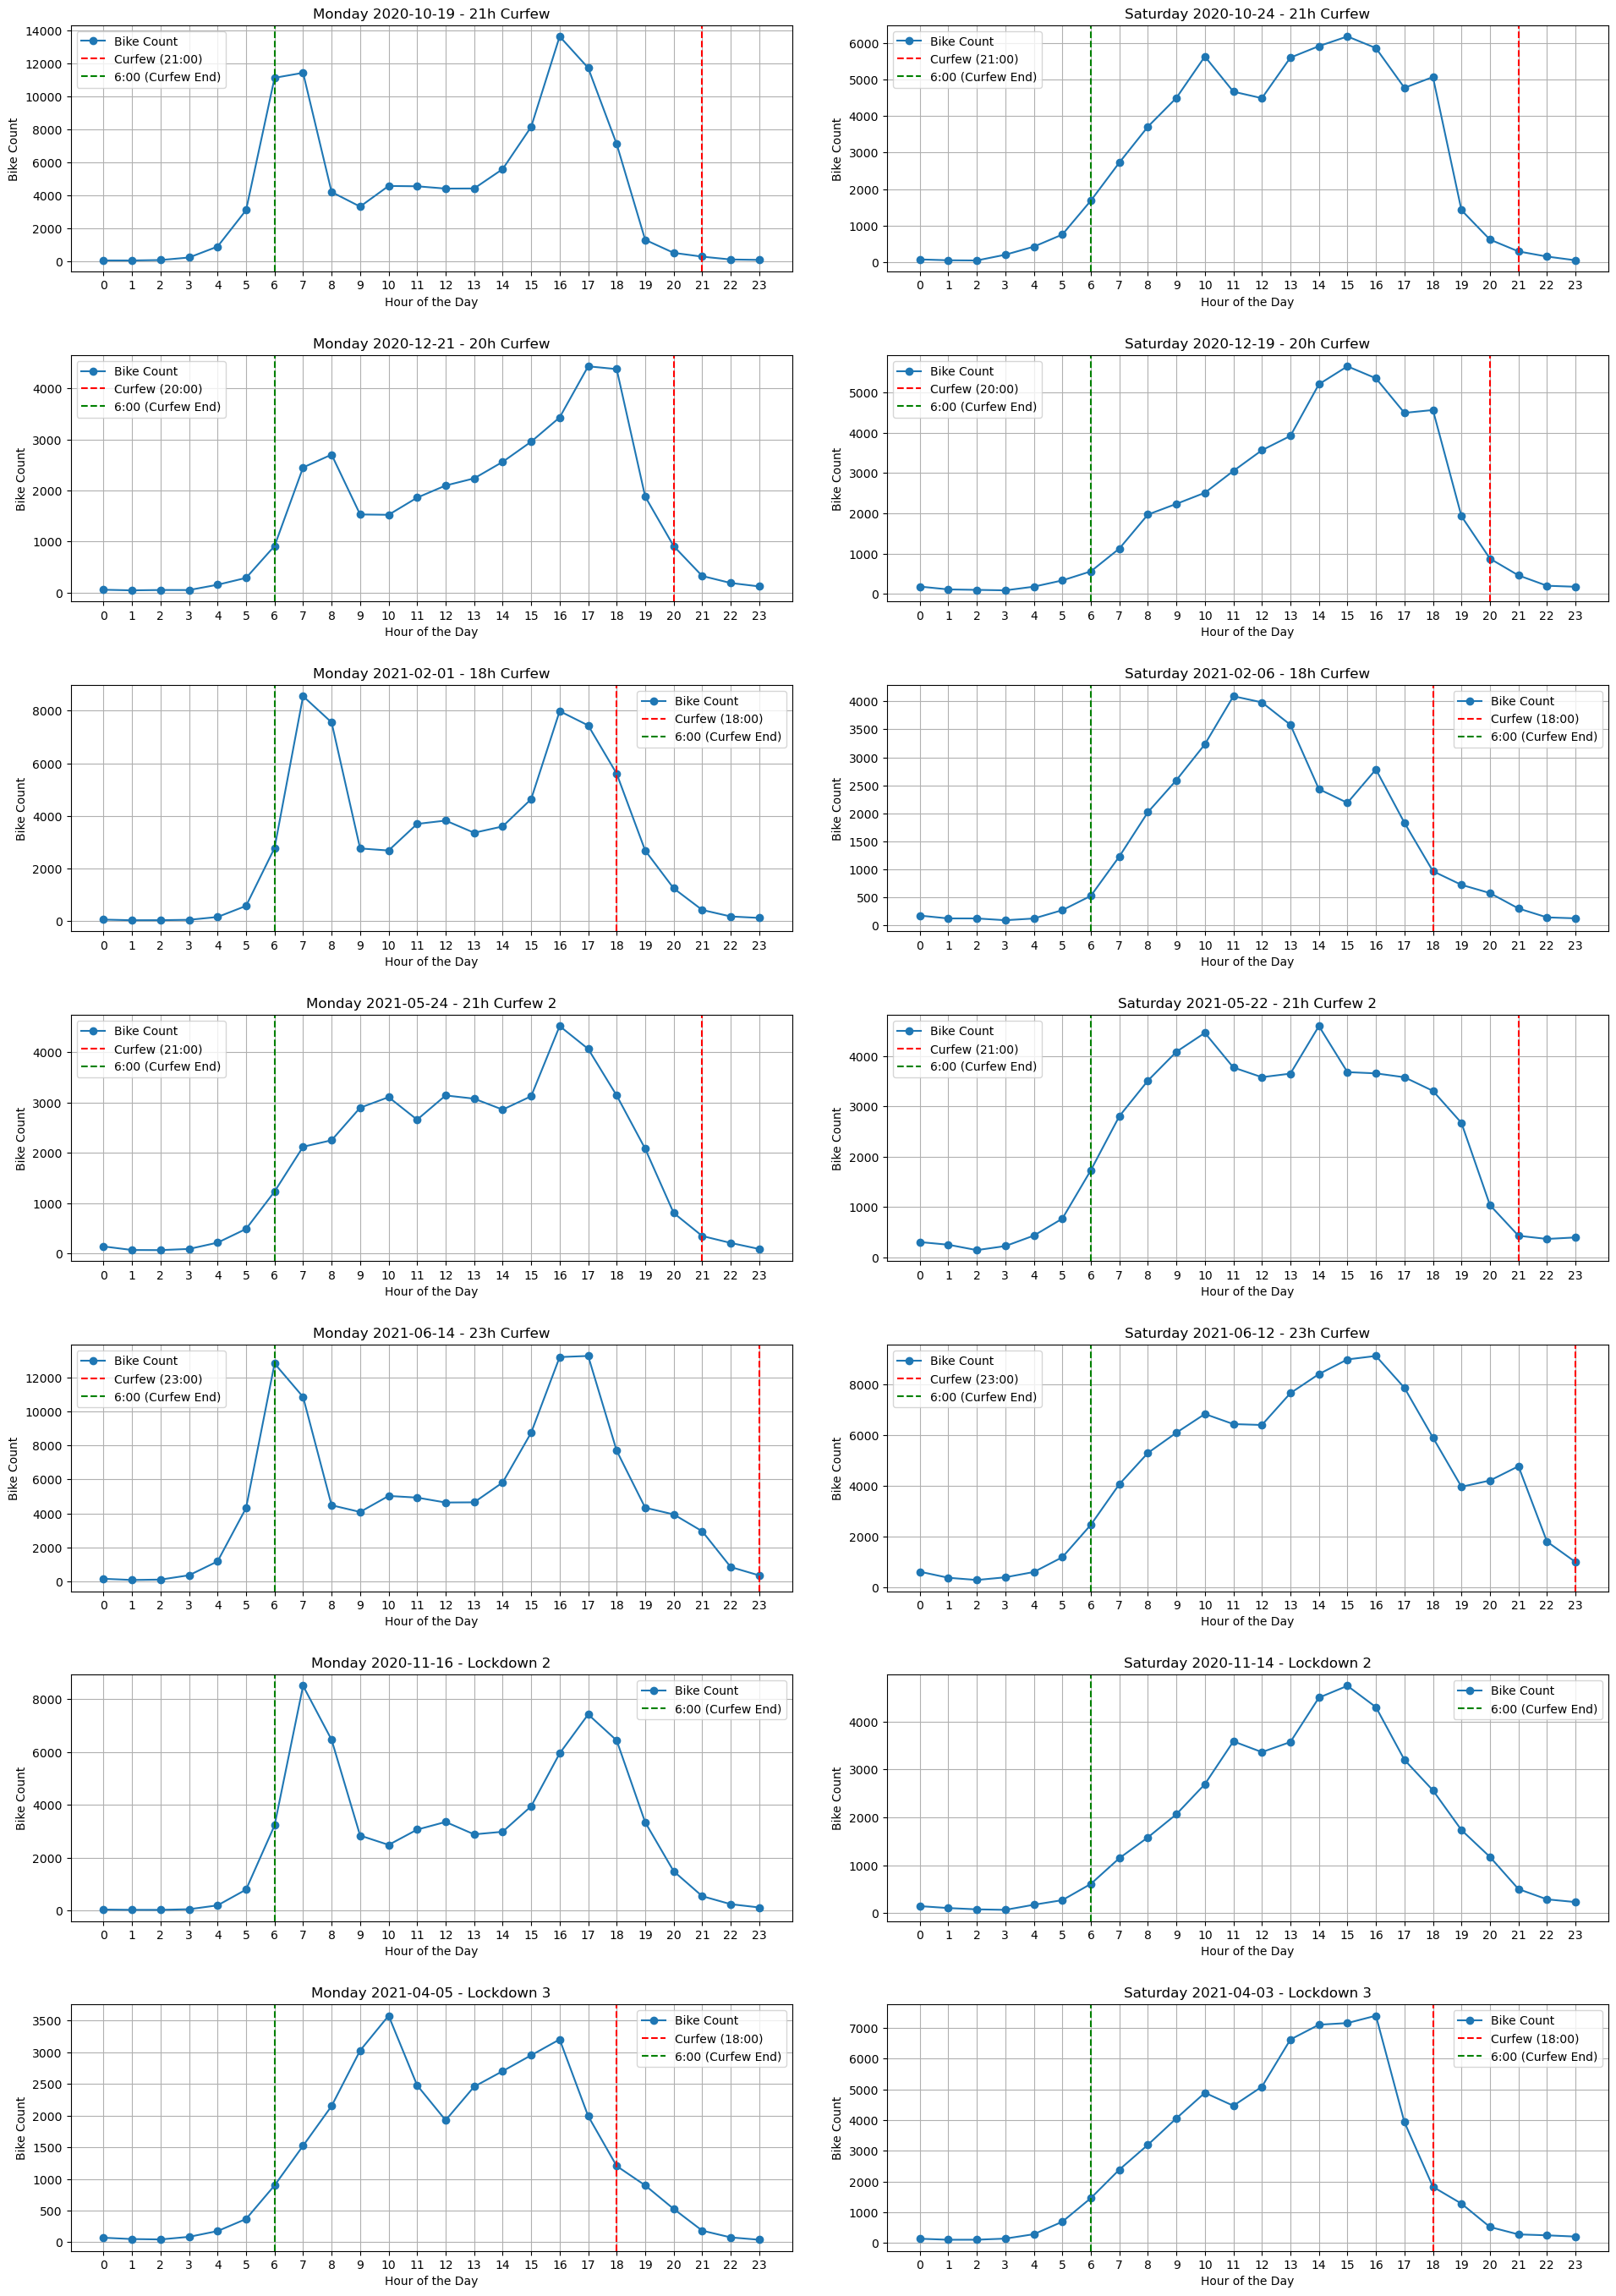

In [31]:
import datetime
import matplotlib.pyplot as plt

test_dates = [
    # Period pairs (Monday, Saturday)
    (datetime.date(2020, 10, 19), datetime.date(2020, 10, 24), "21h Curfew"),     # couvre_feu_21h
    (datetime.date(2020, 12, 21), datetime.date(2020, 12, 19), "20h Curfew"),     # couvre_feu_20h
    (datetime.date(2021, 2, 1), datetime.date(2021, 2, 6), "18h Curfew"),         # couvre_feu_18h
    (datetime.date(2021, 5, 24), datetime.date(2021, 5, 22), "21h Curfew 2"),     # couvre_feu_21h_2
    (datetime.date(2021, 6, 14), datetime.date(2021, 6, 12), "23h Curfew"),       # couvre_feu_23h
    (datetime.date(2020, 11, 16), datetime.date(2020, 11, 14), "Lockdown 2"),     # confinement_2
    (datetime.date(2021, 4, 5), datetime.date(2021, 4, 3), "Lockdown 3")          # confinement_3
]
fig, axs = plt.subplots(7, 2, figsize=(20, 28))
fig.tight_layout(pad=5.0)

for row, (monday_date, saturday_date, period) in enumerate(test_dates):
    # Process Monday data
    monday_data = data[data["date"].dt.date == monday_date]
    if len(monday_data) > 0:
        hourly_counts = monday_data.groupby(monday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 0].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if monday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif monday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif monday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 0].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 0].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 0].set_title(f"Monday {monday_date} - {period}")
    
    # Process Saturday data
    saturday_data = data[data["date"].dt.date == saturday_date]
    if len(saturday_data) > 0:
        hourly_counts = saturday_data.groupby(saturday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 1].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if saturday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif saturday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif saturday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 1].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 1].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 1].set_title(f"Saturday {saturday_date} - {period}")
    
    # Format both plots
    for col in range(2):
        axs[row, col].set_xlabel("Hour of the Day")
        axs[row, col].set_ylabel("Bike Count")
        axs[row, col].grid(True)
        axs[row, col].legend()
        axs[row, col].set_xticks(range(0, 24))

plt.show()

So finally, after all those steps, my dataset is composed of those columns : 

In [32]:
# List the columns of the dataset 

data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude',
       ...
       'confinement_3', 'couvre_feu_21h', 'couvre_feu_20h', 'couvre_feu_18h', 'couvre_feu_21h_2', 'couvre_feu_23h', 'rayon_deplacement_km', 'heure_couvre_feu', 'is_during_curfew', 'is_within_allowed_distance'], dtype='object', length=138)

In [33]:
data.dtypes

counter_id                    category
counter_name                  category
site_id                          int64
site_name                     category
bike_count                     float64
                                ...   
couvre_feu_23h                   int64
rayon_deplacement_km             int64
heure_couvre_feu                 int64
is_during_curfew                 int64
is_within_allowed_distance       int64
Length: 138, dtype: object

In [34]:
data.describe()

site_id     bike_count                        date   counter_installation_date       latitude      longitude  log_bike_count           ALTI            RR1      QRR1           DRR1          QDRR1             FF            QFF             DD       QDD            FXY      QFXY            DXY      QDXY            HXY      QHXY            FXI      QFXI            DXI      QDXI            HXI      QHXI          FXI3S         QFXI3S         HFXI3S        QHFXI3S              T             QT             TD            QTD             TN            QTN            HTN      QHTN             TX            QTX            HTX      QHTX             DG       QDG            T10      QT10            T20      QT20  ...        PMERMIN  QPMERMIN             VV       QVV    DVV200   QDVV200             WW       QWW       NEIGETOT      QNEIGETOT            GLO           QGLO           GLO2          QGLO2            INS           QINS           INS2          QINS2        is_rain           year  \
count  4.968270e+05  496827.000000                      496827                      496827  496827.000000  496827.000000   496827.000000  496827.000000  496827.000000  496827.0  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.0  496827.000000  496827.000000  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  496827.000000  496827.0  ...  496827.000000  496827.0  496827.000000  496827.0  496827.0  496827.0  496827.000000  496827.0  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000  496827.000000   
mean   1.053450e+08      60.191475  2021-03-08 07:25:59.668858  2019-04-04 07:24:35.245911      48.854343       2.345479        3.079917      95.134447       0.082149       1.0       5.085323       8.898266       4.054301       1.003274     180.337099       1.0       4.917374       1.0     185.509725       1.0    1173.070240       9.0       8.101236       1.0     190.631434       1.0    1176.749180       9.0       7.227335       5.862798    1176.947583       8.999699      12.739689       1.367741       7.388057       1.250494      12.345381       1.453734    1172.299407       9.0      13.146980       1.453404    1173.998682       9.0       1.390701       9.0      13.518386       9.0      13.384991       9.0  ...    1016.204218       1.0   17853.896306       9.0       0.0       9.0       5.198337       9.0       0.014428       8.864291      49.138178       8.996844      49.131473       8.996393      12.686223       8.997295      12.689697       8.996844       0.140300    2020.679846   
min    1.000070e+08       0.000000         2020-09-01 01:00:00         2013-01-18 00:00:00      48.826360       2.265420        0.000000      55.600000       0.000000       1.0       0.000000       3.000000       0.000000       1.000000       0.000000       1.0       0.350000       1.0       6.666667       1.0       0.000000       9.0       0.450000       1.0      10.000000       1.0       1.500000       9.0       0.450000       1.000000       8.666667       6.333333      -5.833333       1.000000     -12.250000       1.000000      -6.033333       1.000000       1.000000       9.0      -5.516667       1.000000       1.000000       9.0       0.000000       9.0       1.800000       9.0       2.400000       9.0  ...     972.200000       1.0     426.000000       9.0       0.0       9.0       0.000000       9.0       0.000000       1.000000       0.000000       5.000000       0.000000       5.000000       0.000000       5.000000       0.000000       5.000000       0.000000    2020.000000   
25%    1.000

## Location Data

In [35]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json
def add_district_information(df):
    """
    Adds district information to the DataFrame with error handling
    """
    # Manual corrections for known locations
    district_mapping = {
        'Voie Georges Pompidou NE-SO': 4,
        'Voie Georges Pompidou SO-NE': 4,
        '152 boulevard du Montparnasse E-O': 14,
        '152 boulevard du Montparnasse O-E': 14,
        'Face au 40 quai D\'Issy NE-SO': 15,
        'Face au 40 quai D\'Issy SO-NE': 15,
        # Add other known mappings here
    }
    
    try:
        # Apply manual mapping first
        df = df.copy()
        df['arrondissement'] = df['counter_name'].map(district_mapping)
        
        # Only process unmapped locations through the API
        unmapped = df[df['arrondissement'].isna()]
        if len(unmapped) > 0:
            # Create GeoDataFrame for unmapped points
            geometry = [Point(xy) for xy in zip(unmapped['longitude'], unmapped['latitude'])]
            gdf_points = gpd.GeoDataFrame(unmapped[['counter_name']], geometry=geometry)
            
            # Get district data from API
            url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/records?limit=20"
            response = pd.read_json(url)
            
            # Create districts GeoDataFrame
            districts_data = [{
                'c_ar': district['c_ar'],
                'geometry': Polygon(district['geom']['geometry']['coordinates'][0])
            } for district in response['results']]
            districts = gpd.GeoDataFrame(districts_data)
            
            # Spatial join
            result = gpd.sjoin(gdf_points, districts[['geometry', 'c_ar']], how="left", predicate='within')
            api_mapping = dict(zip(result['counter_name'], result['c_ar']))
            
            # Update remaining values
            df.loc[df['arrondissement'].isna(), 'arrondissement'] = df.loc[df['arrondissement'].isna(), 'counter_name'].map(api_mapping)
        
        # Fill any remaining NaN values with 0 and convert to int
        df['arrondissement'] = df['arrondissement'].fillna(0).astype(int)
        return df
        
    except Exception as e:
        print(f"Warning: Error in district assignment: {e}")
        df['arrondissement'] = 0
        return df

# Utilisation
data = add_district_information(data)
test_data = add_district_information(test_data)

# Vérification
print(data[['counter_name', 'arrondissement']].drop_duplicates())

                             counter_name  arrondissement
0                28 boulevard Diderot E-O              12
8838             28 boulevard Diderot O-E              12
17839      39 quai François Mauriac NO-SE              13
26819      39 quai François Mauriac SE-NO              13
35812   18 quai de l'Hôtel de Ville NO-SE               4
...                                   ...             ...
455682             90 Rue De Sèvres SO-NE              15
464796          20 Avenue de Clichy NO-SE              18
473765          20 Avenue de Clichy SE-NO              18
483673         254 rue de Vaugirard NE-SO              15
489226         254 rue de Vaugirard SO-NE              15

[56 rows x 2 columns]


In [36]:
# Arrondissement devrait être une variable catégorielle

data['arrondissement'] = data['arrondissement'].astype('category')
test_data['arrondissement'] = test_data['arrondissement'].astype('category')

In [37]:
# Direction features (from counter names)
data['direction'] = data['counter_name'].str.extract('(N-S|S-N|E-O|O-E|NO-SE|SE-NO)')

# Bridge/Infrastructure type
data['is_bridge'] = data['counter_name'].str.contains('Pont').astype(int)
data['is_quai'] = data['counter_name'].str.contains('quai').astype(int)
data['is_boulevard'] = data['counter_name'].str.contains('boulevard').astype(int)

# Direction features (from counter names)
test_data['direction'] = test_data['counter_name'].str.extract('(N-S|S-N|E-O|O-E|NO-SE|SE-NO)')

# Bridge/Infrastructure type  
test_data['is_bridge'] = test_data['counter_name'].str.contains('Pont').astype(int)
test_data['is_quai'] = test_data['counter_name'].str.contains('quai').astype(int) 
test_data['is_boulevard'] = test_data['counter_name'].str.contains('boulevard').astype(int)

# 2. Visualizing the data - EDA


Let's visualize the data, starting from the spatial distribution of counters on the map

## Feature Repartition

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

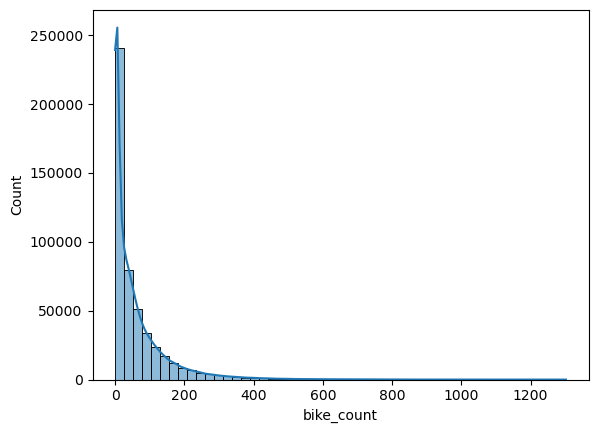

In [38]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

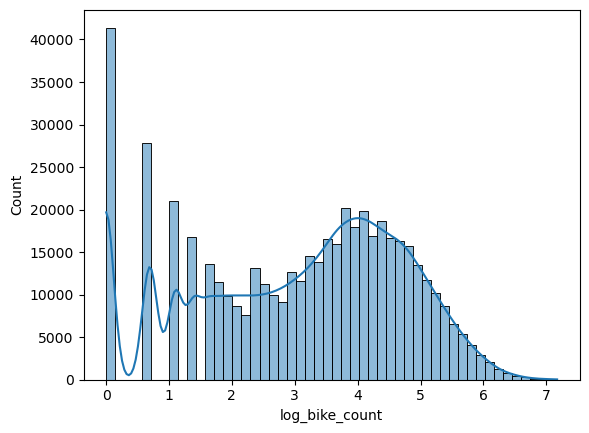

In [39]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

Text(0.5, 1.0, 'Distribution of Zero Counts by Day of Week')

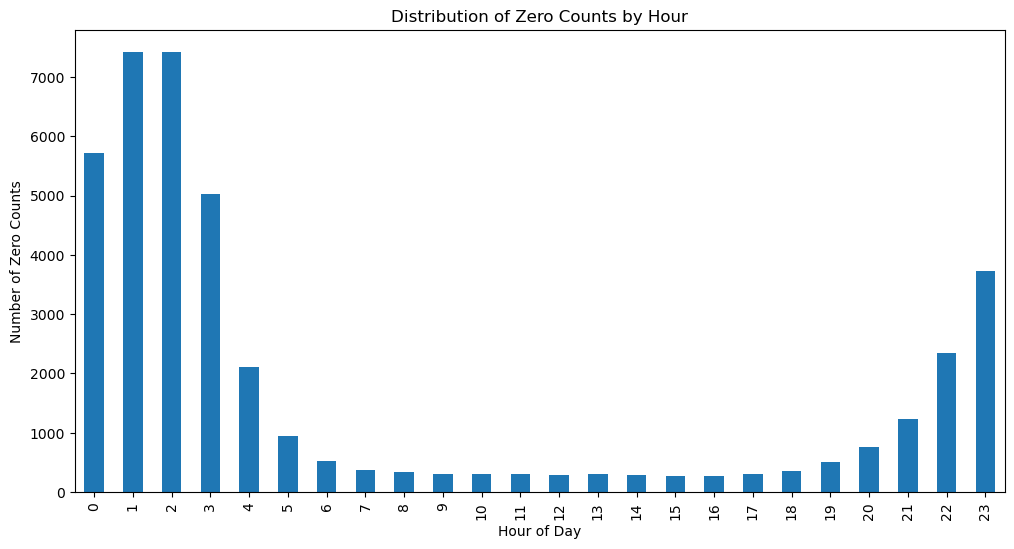

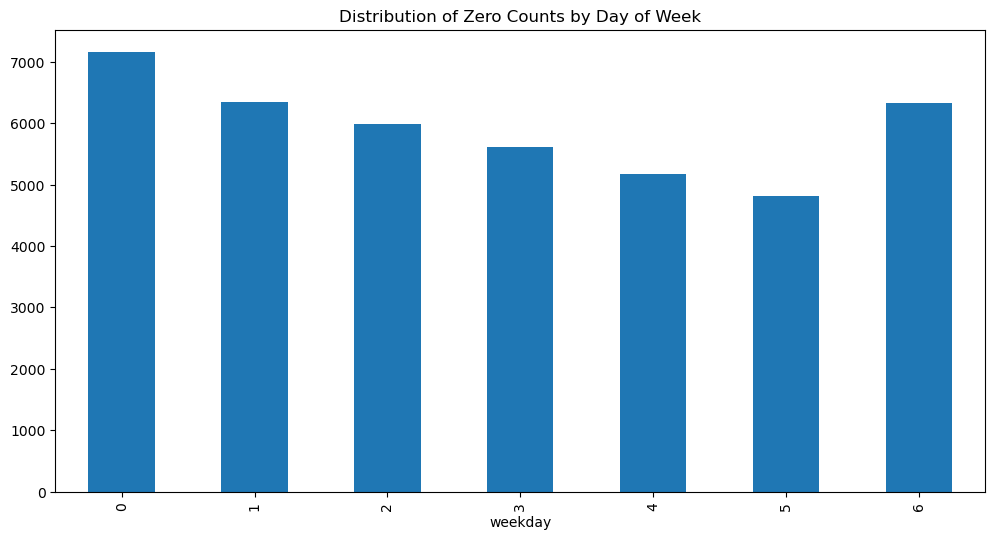

In [40]:
# Time-based patterns of zeros
zeros_data = data[data['bike_count'] == 0]

# By hour
plt.figure(figsize=(12, 6))
zeros_data['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Zero Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Zero Counts')

# By day of week
plt.figure(figsize=(12, 6))
zeros_data['weekday'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Zero Counts by Day of Week')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/3415442623.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_zeros = data.pivot_table(


Text(0.5, 1.0, 'Percentage of Zeros by Counter and Hour')

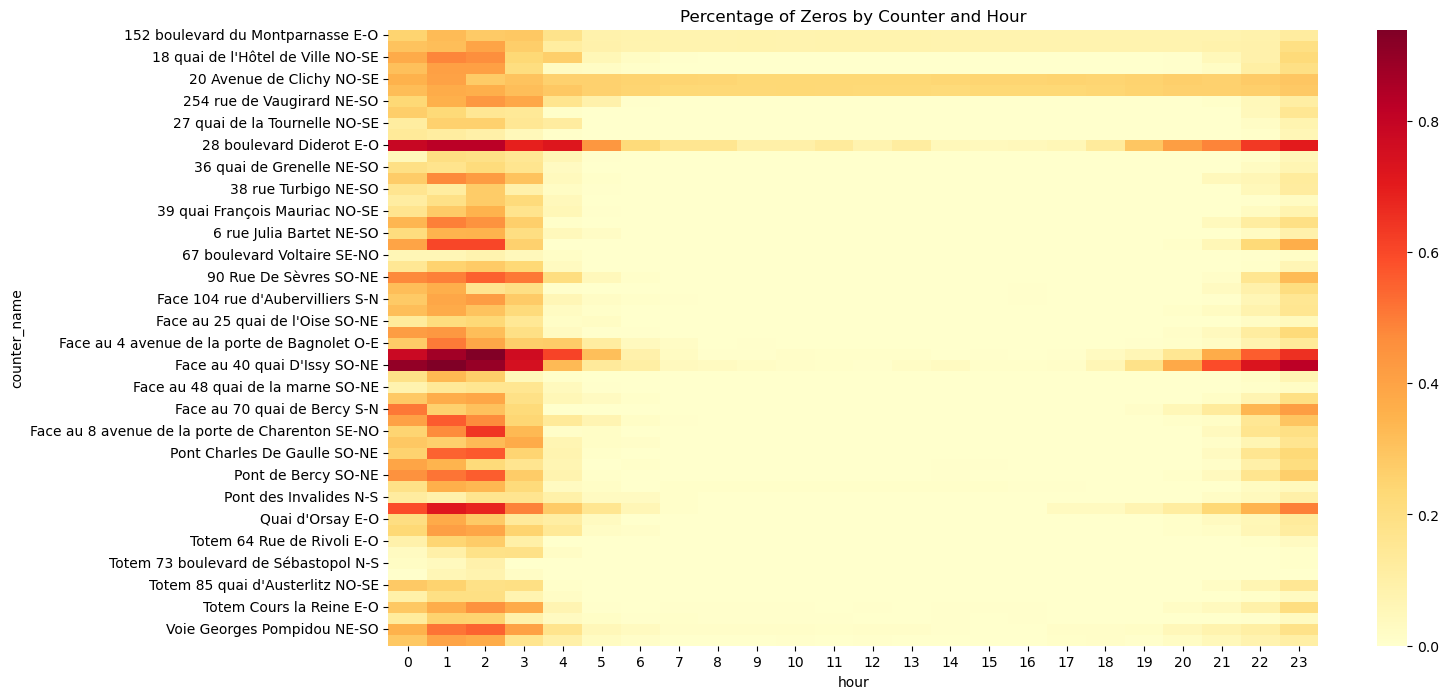

In [41]:
# Heatmap of zeros by counter location
pivot_zeros = data.pivot_table(
    values='bike_count',
    index='counter_name',
    columns='hour',
    aggfunc=lambda x: (x == 0).mean()
)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_zeros, cmap='YlOrRd')
plt.title('Percentage of Zeros by Counter and Hour')

In [42]:
# Create a detailed zeros analysis table
zeros_analysis = pd.DataFrame({
    'total_zeros': [len(zeros_data)],
    'percentage_zeros': [len(zeros_data) / len(data) * 100],
    'zeros_weekday': [len(zeros_data[zeros_data['weekday'] < 5])],
    'zeros_weekend': [len(zeros_data[zeros_data['weekday'] >= 5])],
    'zeros_night_hours': [len(zeros_data[zeros_data['hour'].isin(range(23, 24)) | zeros_data['hour'].isin(range(0, 5))])],
    'zeros_day_hours': [len(zeros_data[~zeros_data['hour'].isin(range(23, 24)) & ~zeros_data['hour'].isin(range(0, 5))])],
})

# Print patterns around zeros
print("Records just before zero counts:")
print(data[data['bike_count'].shift(-1) == 0]['bike_count'].describe())

print("\nRecords just after zero counts:")
print(data[data['bike_count'].shift(1) == 0]['bike_count'].describe())

Records just before zero counts:
count    41400.000000
mean        36.600024
std         59.760905
min          0.000000
25%          2.000000
50%         11.000000
75%         49.000000
max       1250.000000
Name: bike_count, dtype: float64

Records just after zero counts:
count    41401.000000
mean        37.564069
std         60.224984
min          0.000000
25%          2.000000
50%         12.000000
75%         51.000000
max       1250.000000
Name: bike_count, dtype: float64


In [43]:
# Counter-specific statistics - fixed version
counter_stats = (data.groupby('counter_name')
                .agg(
                    zero_rate=('bike_count', lambda x: (x == 0).mean()),
                    night_zero_rate=('bike_count', lambda x: (x[data['is_night'] == 1] == 0).mean())
                )
                .reset_index())

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/1000155032.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counter_stats = (data.groupby('counter_name')


In [44]:
counter_stats.head(30)

counter_name  zero_rate  night_zero_rate
0              152 boulevard du Montparnasse E-O   0.121320         0.218523
1              152 boulevard du Montparnasse O-E   0.128568         0.242250
2              18 quai de l'Hôtel de Ville NO-SE   0.095164         0.301223
3              18 quai de l'Hôtel de Ville SE-NO   0.071874         0.225535
4                      20 Avenue de Clichy NO-SE   0.264653         0.306193
5                      20 Avenue de Clichy SE-NO   0.262313         0.314220
6                     254 rue de Vaugirard NE-SO   0.077543         0.255341
7                     254 rue de Vaugirard SO-NE   0.042269         0.138093
8                  27 quai de la Tournelle NO-SE   0.042233         0.141820
9                  27 quai de la Tournelle SE-NO   0.020169         0.067661
10                      28 boulevard Diderot E-O   0.341877         0.712156
11                      28 boulevard Diderot O-E   0.030087         0.101300
12                     36 quai de Grenelle NE-SO   0.036550         0.120795
13                     36 quai de Grenelle SO-NE   0.073323         0.235856
14                          38 rue Turbigo NE-SO   0.035324         0.113914
15                          38 rue Turbigo SO-NE   0.036661         0.124618
16                39 quai François Mauriac NO-SE   0.047136         0.157492
17                39 quai François Mauriac SE-NO   0.079786         0.250000
18                      6 rue Julia Bartet NE-SO   0.054156         0.181193
19                      6 rue Julia Bartet SO-NE   0.105416         0.318807
20                   67 boulevard Voltaire SE-NO   0.011700         0.039373
21                        90 Rue De Sèvres NE-SO   0.042902         0.145642
22                        90 Rue De Sèvres SO-NE   0.116448         0.373089
23              Face 104 rue d'Aubervilliers N-S   0.058279         0.178517
24              Face 104 rue d'Aubervilliers S-N   0.070871         0.228593
25               Face au 25 quai de l'Oise NE-SO   0.063851         0.202217
26               Face au 25 quai de l'Oise SO-NE   0.034656         0.115826
27  Face au 4 avenue de la porte de Bagnolet E-O   0.074883         0.231651
28  Face au 4 avenue de la porte de Bagnolet O-E   0.089815         0.281728
29                  Face au 40 quai D'Issy NE-SO   0.261868         0.703364

In [45]:
night_zero_dict = {'28 boulevard Diderot E-O': 0.7433155080213903,
 '28 boulevard Diderot O-E': 0.10900178253119429,
 '39 quai François Mauriac NO-SE': 0.1778966131907308,
 '39 quai François Mauriac SE-NO': 0.3105169340463458,
 "18 quai de l'Hôtel de Ville NO-SE": 0.3129233511586453,
 "18 quai de l'Hôtel de Ville SE-NO": 0.27263814616755794,
 'Voie Georges Pompidou NE-SO': 0.35168539325842696,
 'Voie Georges Pompidou SO-NE': 0.2335205992509363,
 '67 boulevard Voltaire SE-NO': 0.04420677361853832,
 'Face au 48 quai de la marne NE-SO': 0.15347593582887697,
 'Face au 48 quai de la marne SO-NE': 0.09509803921568627,
 "Face 104 rue d'Aubervilliers N-S": 0.22174688057041,
 "Face 104 rue d'Aubervilliers S-N": 0.2640819964349376,
 'Face au 70 quai de Bercy N-S': 0.24973262032085558,
 'Face au 70 quai de Bercy S-N': 0.342602495543672,
 '6 rue Julia Bartet NE-SO': 0.20463458110516933,
 '6 rue Julia Bartet SO-NE': 0.40962566844919784,
 "Face au 25 quai de l'Oise NE-SO": 0.24358288770053474,
 "Face au 25 quai de l'Oise SO-NE": 0.13163992869875224,
 '152 boulevard du Montparnasse E-O': 0.22540106951871658,
 '152 boulevard du Montparnasse O-E': 0.2625668449197861,
 'Totem 64 Rue de Rivoli E-O': 0.12433155080213903,
 'Totem 64 Rue de Rivoli O-E': 0.08511586452762923,
 'Pont des Invalides S-N': 0.553030303030303,
 'Pont de la Concorde S-N': 0.19447415329768267,
 'Pont des Invalides N-S': 0.11363636363636362,
 'Face au 8 avenue de la porte de Charenton NO-SE': 0.35401069518716577,
 'Face au 8 avenue de la porte de Charenton SE-NO': 0.3424242424242424,
 'Face au 4 avenue de la porte de Bagnolet E-O': 0.28386809269162205,
 'Face au 4 avenue de la porte de Bagnolet O-E': 0.2760249554367201,
 'Pont Charles De Gaulle NE-SO': 0.24696969696969695,
 'Pont Charles De Gaulle SO-NE': 0.3343137254901961,
 '36 quai de Grenelle NE-SO': 0.1405525846702317,
 '36 quai de Grenelle SO-NE': 0.2767379679144385,
 "Face au 40 quai D'Issy NE-SO": 0.7599821746880571,
 "Face au 40 quai D'Issy SO-NE": 0.8393939393939392,
 'Pont de Bercy NE-SO': 0.23921568627450981,
 'Pont de Bercy SO-NE': 0.37192513368983954,
 '38 rue Turbigo NE-SO': 0.1360071301247772,
 '38 rue Turbigo SO-NE': 0.13814616755793224,
 "Quai d'Orsay E-O": 0.19670231729055257,
 "Quai d'Orsay O-E": 0.24500891265597147,
 '27 quai de la Tournelle NO-SE': 0.14812834224598928,
 '27 quai de la Tournelle SE-NO': 0.07905525846702317,
 "Totem 85 quai d'Austerlitz NO-SE": 0.1910873440285205,
 "Totem 85 quai d'Austerlitz SE-NO": 0.10089126559714795,
 'Totem Cours la Reine E-O': 0.2972370766488413,
 'Totem Cours la Reine O-E': 0.12584670231729053,
 'Totem 73 boulevard de Sébastopol N-S': 0.028074866310160422,
 'Totem 73 boulevard de Sébastopol S-N': 0.027183600713012478,
 '90 Rue De Sèvres NE-SO': 0.16550802139037432,
 '90 Rue De Sèvres SO-NE': 0.4191622103386809,
 '20 Avenue de Clichy NO-SE': 0.3163992869875223,
 '20 Avenue de Clichy SE-NO': 0.31996434937611407,
 '254 rue de Vaugirard NE-SO': 0.2624242424242424,
 '254 rue de Vaugirard SO-NE': 0.16666666666666666}


In [46]:
def append_night_zero_from_dict(df):
    df['night_zero'] = df['counter_name'].map(night_zero_dict)
    return df

In [47]:
data = append_night_zero_from_dict(data)

In [48]:
test_data = append_night_zero_from_dict(test_data)

In [49]:
# Add these statistics back to main DataFrame
data = data.merge(counter_stats, on='counter_name')

Text(0.5, 1.0, 'Overall Distribution')

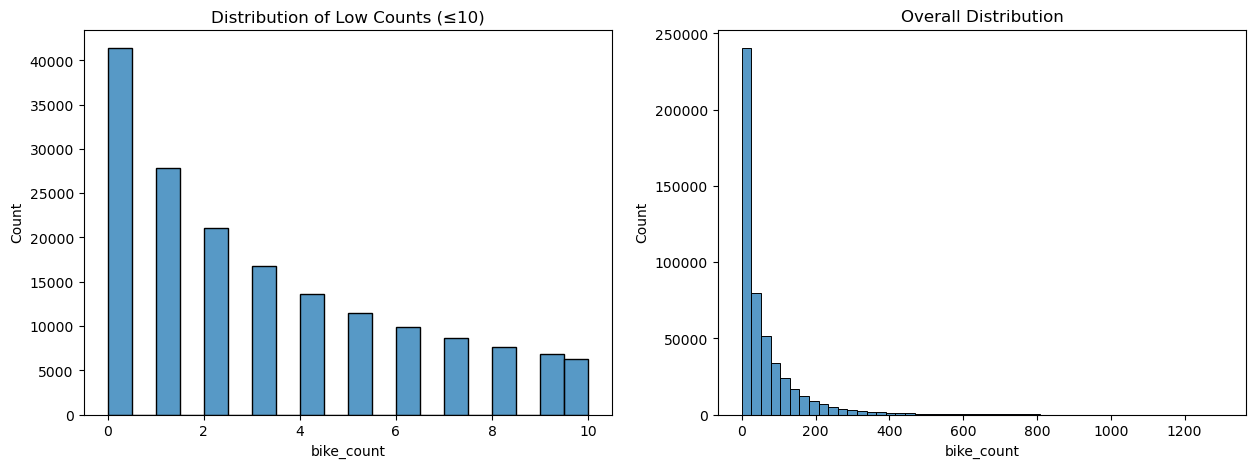

In [50]:
# Compare distribution of values near zero vs overall
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data[data['bike_count'] <= 10]['bike_count'], bins=20)
plt.title('Distribution of Low Counts (≤10)')

plt.subplot(1, 2, 2)
sns.histplot(data['bike_count'], bins=50)
plt.title('Overall Distribution')

In [51]:
def add_night_zero_feature(df):
    """
    Adds the ⁠ night_zero ⁠ feature to the dataframe. The feature represents the fraction of nights
    (22:00-04:00) where ⁠ log_bike_count ⁠ is 0 for each ⁠ counter_name ⁠.

    Parameters:
        df (pd.DataFrame): Input dataframe with columns ['date', 'counter_name', 'log_bike_count']
                           The 'date' column should be a datetime object.

    Returns:
        pd.DataFrame: Dataframe with the new ⁠ night_zero ⁠ feature added.
    """
    # Ensure 'date' is a datetime object
    df['date'] = pd.to_datetime(df['date'])

    # Extract hour from date
    df['hour'] = df['date'].dt.hour

    # Filter for night hours (22:00-04:00)
    night_data = df.loc[(df['hour'] >= 22) | (df['hour'] < 4)].copy()

    # Add a column indicating whether log_bike_count is 0
    night_data['is_zero'] = (night_data['log_bike_count'] == 0).astype(int)

    # Group by counter_name and calculate the fraction of nights where log_bike_count == 0
    night_zero = (
        night_data.groupby('counter_name')
        .apply(lambda group: group.groupby(night_data['date'].dt.date)['is_zero'].mean().mean())
        .reset_index(name='night_zero')
    )

    # Merge the feature back to the original dataframe
    df = df.merge(night_zero, on='counter_name', how='left')

    # Drop the temporary 'hour' column
    df = df.drop(columns=['hour'])

    return df

In [52]:
#data = add_night_zero_feature(data)

# 3. Feature Engineering


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

### Datatypes

In [59]:
data.dtypes

counter_id         category
counter_name       category
site_id               int64
site_name          category
bike_count          float32
                     ...   
is_quai            category
is_boulevard       category
night_zero          float32
zero_rate           float64
night_zero_rate     float64
Length: 146, dtype: object

In [60]:
# Create a dictionary of data types
dtypes = {
   # Categorical columns (low cardinality strings)
   'counter_id': 'category',
   'counter_name': 'category',
   'site_name': 'category',
   'coordinates': 'category',
   'counter_technical_id': 'category',
   'arrondissement': 'category',
   'period_of_day': 'category',
   'direction': 'category',  # Changed from object to category
   
   # Binary indicators as categories
   'is_night': 'category',
   'is_early_morning': 'category',
   #'is_zero': 'category',
   #'is_very_low': 'category',
   'is_bridge': 'category',
   'is_quai': 'category',
   'is_boulevard': 'category',
   'is_bank_holiday': 'category',
   'is_school_holidays': 'category',
   
   # Integer columns that might need 16-bit (medium range values)
   'year': 'int16',
   'month': 'int8',
   'day': 'int8',
   'weekday': 'int8',
   #'hour': 'int8',
   'week_number': 'int16',
   

   
   # Float columns (keep as float32 instead of float64 to save memory)
   'bike_count': 'float32',
   'latitude': 'float32',
   'longitude': 'float32',
   'log_bike_count': 'float32',
   'hour_sin': 'float32',
   'hour_cos': 'float32',
   'day_sin': 'float32',
   'day_cos': 'float32',
   #'zero_rate': 'float32',
   'night_zero': 'float32'
}



In [61]:
# Create a dictionary of data types
dtypes_test = {
   # Categorical columns (low cardinality strings)
   'counter_id': 'category',
   'counter_name': 'category',
   'site_name': 'category',
   'coordinates': 'category',
   'counter_technical_id': 'category',
   'arrondissement': 'category',
   #'period_of_day': 'category',
   'direction': 'category',  # Changed from object to category
   
   # Binary indicators as categories
   'is_night': 'category',
   'is_early_morning': 'category',
   #'is_zero': 'category',
   #'is_very_low': 'category',
   'is_bridge': 'category',
   'is_quai': 'category',
   'is_boulevard': 'category',
   'is_bank_holiday': 'category',
   'is_school_holidays': 'category',
   
   # Integer columns that might need 16-bit (medium range values)
   'year': 'int16',
   'month': 'int8',
   'day': 'int8',
   'weekday': 'int8',
   'hour': 'int8',
   'week_number': 'int16',
   

   
   # Float columns (keep as float32 instead of float64 to save memory)
   #'bike_count': 'float32',
   'latitude': 'float32',
   'longitude': 'float32',
   #'log_bike_count': 'float32',
   'hour_sin': 'float32',
   'hour_cos': 'float32',
   'day_sin': 'float32',
   'day_cos': 'float32',
   #'zero_rate': 'float32',
   'night_zero': 'float32'
}



In [62]:
data.head()

counter_id              counter_name    site_id             site_name  bike_count                date counter_installation_date         coordinates counter_technical_id   latitude  longitude  log_bike_count        ALTI  RR1  QRR1  DRR1  QDRR1        FF  QFF          DD  QDD       FXY  QFXY         DXY  QDXY          HXY  QHXY       FXI  QFXI         DXI  QDXI          HXI  QHXI  FXI3S  QFXI3S  HFXI3S  QHFXI3S          T   QT    TD  QTD         TN  QTN          HTN  QHTN         TX  QTX          HTX  QHTX   DG  ...  QGLO   GLO2  QGLO2   INS  QINS  INS2  QINS2  is_rain  rain_category  temp_category  year  month  day  weekday  hour  week_number  period_of_day  is_night  is_weekend  is_weekend_night  is_early_morning  period_of_day_num  weekday_period  weekday_is_night  hour_weekday  hour_sin      hour_cos   day_sin  day_cos  is_bank_holiday  is_school_holidays  confinement_2  confinement_3  couvre_feu_21h  couvre_feu_20h  couvre_feu_18h  couvre_feu_21h_2  couvre_feu_23h  \
0  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         0.0 2020-09-01 02:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846027   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0  1.400000  1.0  110.000000  1.0  2.033333   1.0  120.000000   1.0   140.000000   9.0  3.033333   1.0  170.000000   1.0   122.666667   9.0   1.80     5.0   125.5      9.0  12.250000  1.0  8.55  1.0  12.200000  1.0   143.833333   9.0  12.766667  1.0   103.833333   9.0  0.0  ...   9.0    0.0    9.0   0.0   9.0   0.0    9.0        0            NaN           Cool  2020      9    1        1     2           36          night         1           0                 0                 0                  0               0                 1             2  0.500000  8.660254e-01  0.781832  0.62349                0                   0              0              0               0               0               0                 0               0   
1  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         1.0 2020-09-01 03:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846027   2.375429        0.693147  101.333333  0.0   1.0   0.0    9.0  1.100000  1.0  113.333333  1.0  1.600000   1.0  116.666667   1.0   243.333333   9.0  2.433333   1.0  133.333333   1.0   223.333333   9.0   1.95     5.0   234.0      9.0  12.133333  1.0  9.00  1.0  11.833333  1.0   235.833333   9.0  12.300000  1.0   216.333333   9.0  0.0  ...   9.0    0.0    9.0   0.0   9.0   0.0    9.0        0            NaN           Cool  2020      9    1        1     3           36          night         1           0                 0                 0                  0               0                 1             3  0.707107  7.071068e-01  0.781832  0.62349                0                   0              0              0               0               0               0                 0               0   
2  100007049-102007049  28 boulevard Diderot E-O  100007049  28 boulevard Diderot         0.0 2020-09-01 04:00:00                2013-01-18  48.846028,2.375429          Y2H15027244  48.846027   2.375429        0.000000  101.333333  0.0   1.0   0.0    9.0  1.100000  1.0  103.333333  1.0  1.366667   1.0  116.666667   1.0   348.000000   9.0  1.966667   1.0  120.000000   1.0   344.666667   9.0   1.50     5.0   364.5      9.0  11.616667  1.0  8.45  1.0  11.516667  1.0   346.833333   9.0  12.116667  1.0   304.000000   9.0  0.0  ...   9.0    0.0    9.0   0.0   9.0   0.0    9.0        0            NaN           Cool  2020      9    1        1     4           36          night         1           0                 0                 0                  0               0                 1             4  0.866025  5.000000e-01  0.781832  0.62349                0                   0              0              0               0               0               0                 0               0   
3  100007049-102007049  

In [63]:
data = data.astype(dtypes)
test_data = test_data.astype(dtypes_test)

In [64]:
# Afficher une description détaillée du DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496827 entries, 0 to 496826
Columns: 146 entries, counter_id to night_zero_rate
dtypes: category(17), datetime64[us](2), float32(9), float64(93), int16(2), int32(3), int64(16), int8(4)
memory usage: 455.3 MB
None


# 4. Feature Selection

### DDD - Simple Feature Selection

In [65]:
def get_feature_lists(data, features):
    numerical_features = []
    categorical_features = []
    date_features = []
    simple_encoder_features = []

    for feature in features:
        # Check for simple encoder features first
        if feature in ['site_name', 'counter_name']:
            simple_encoder_features.append(feature)
        # Check for datetime
        elif pd.api.types.is_datetime64_any_dtype(data[feature]):
            date_features.append(feature)
        # Check for categorical
        elif pd.api.types.is_categorical_dtype(data[feature]):
            categorical_features.append(feature)
        # Check for boolean
        elif pd.api.types.is_bool_dtype(data[feature]):
            categorical_features.append(feature)  # You might want to treat booleans as categorical
        # Check for numeric (including int8, int16, float32 etc.)
        elif pd.api.types.is_numeric_dtype(data[feature]):
            numerical_features.append(feature)
        else:
            categorical_features.append(feature)

    return numerical_features, categorical_features, date_features, simple_encoder_features

# You can then use it like before
features = [col for col in data.columns]
numerical_features, categorical_features, date_features, simple_encoder_features = get_feature_lists(data, features)

# Print to verify
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)
print("Date features:", date_features)
print("Simple encoder features:", simple_encoder_features)

Numerical features: ['site_id', 'bike_count', 'latitude', 'longitude', 'log_bike_count', 'ALTI', 'RR1', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'HFXI3S', 'QHFXI3S', 'T', 'QT', 'TD', 'QTD', 'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'DG', 'QDG', 'T10', 'QT10', 'T20', 'QT20', 'T50', 'QT50', 'T100', 'QT100', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'TCHAUSSEE', 'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSV', 'QTSV', 'PMER', 'QPMER', 'PSTAT', 'QPSTAT', 'PMERMIN', 'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'WW', 'QWW', 'NEIGETOT', 'QNEIGETOT', 'GLO', 'QGLO', 'GLO2', 'QGLO2', 'INS', 'QINS', 'INS2', 'QINS2', 'is_rain', 'year', 'month', 'day', 'weekday', 'hour', 'week_number', 'is_weekend', 'is_weekend_night', 'period_of_day_num', 'weekday_period', 'weekday_is_night', 'hour_weekda

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/80374455.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[feature]):


### Select the features to use

In [230]:
#DDD Select the features to use

#LIST_FEATURES = ['weekday',
##'week_number' ,'hour_sin','hour_cos' ,'U','TSV','site_name','PSTAT','TNSOL','GLO','date','night_zero','HTN','month', 'counter_name',
#'hour_weekday'
#]

LIST_FEATURES2 = ['DD', 'QDD', 'FXY', 'TNSOL', 'U', 'TSV', 
                  'PSTAT', 'VV','NEIGETOT', 'QNEIGETOT', 'GLO', 'INS', 'QINS', 'is_rain', 'year', 'month', 'day', 'weekday', 'week_number', 
                'is_weekend', 'is_weekend_night', 'period_of_day_num', 'weekday_period', 'weekday_is_night', 'hour_weekday', 'hour_sin', 'hour_cos', 'day_sin',
                 'day_cos', 'night_zero', 'rain_category', 'temp_category', 'period_of_day', 'is_night', 
                  'is_early_morning', 'is_bank_holiday', 'is_school_holidays', 'arrondissement', 'direction', 'is_bridge', 'is_quai', 'is_boulevard',
                  'date','counter_name', 'site_name']
           
           
LIST_FEATURES = ['site_id', 'latitude', 'longitude', 'ALTI', 'RR1', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY', 
                'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'HFXI3S', 'QHFXI3S', 'T', 'QT', 'TD', 'QTD', 
               'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'DG', 'QDG', 'T10', 'QT10', 'T20', 'QT20', 'T50', 'QT50', 'T100', 'QT100', 'TNSOL', 
            'QTNSOL', 'TN50', 'QTN50', 'TCHAUSSEE', 'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX', 'QHUX', 'DHUMI40', 'QDHUMI40', 
                 'DHUMI80', 'QDHUMI80', 'TSV', 'QTSV', 'PMER', 'QPMER', 'PSTAT', 'QPSTAT', 'PMERMIN', 'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'WW', 'QWW', 
                 'NEIGETOT', 'QNEIGETOT', 'GLO', 'QGLO', 'GLO2', 'QGLO2', 'INS', 'QINS', 'INS2', 'QINS2', 'is_rain', 'year', 'month', 'day', 'weekday', 'week_number', 
                 'is_weekend', 'is_weekend_night', 'period_of_day_num', 'weekday_period', 'weekday_is_night', 'hour_weekday', 'hour_sin', 'hour_cos', 'day_sin',
                 'day_cos', 'confinement_2', 'confinement_3', 'couvre_feu_21h', 'couvre_feu_20h', 'couvre_feu_18h', 'couvre_feu_21h_2', 'couvre_feu_23h', 
                'rayon_deplacement_km', 'heure_couvre_feu', 'is_during_curfew', 'is_within_allowed_distance',
               'night_zero', 'counter_id', 'coordinates', 'counter_technical_id', 'rain_category', 'temp_category', 'period_of_day', 'is_night', 
                 'is_early_morning', 'is_bank_holiday', 'is_school_holidays', 'arrondissement', 'direction', 'is_bridge', 'is_quai', 'is_boulevard',
                 'date','counter_name', 'site_name']

TOP50FEATURES = ['hour_cos', 'night_zero', 'hour_sin', 'week_number', 'T100', 'is_night', 'T50', 'weekday', 
                 'is_during_curfew', 'arrondissement', 'day_sin', 'site_id', 'HTX', 'QFXI3S', 'site_name', 'is_weekend', 'period_of_day', 'hour_weekday', 
                 'latitude', 'HFXI3S', 'counter_name', 'T20', 'HTN', 'weekday_period', 'counter_technical_id', 'INS', 'HUN', 'longitude', 
                 'HUX', 'HXY', 'day', 'HXI', 'date',
                 'counter_id', 'month', 'day_cos', 'is_school_holidays', 'GLO2', 'UN', 
                 'UX', 'coordinates', 'U']


#lected Features: ['num__weekday' 'num__week_number' 'num__hour_sin' 'num__hour_cos'
 #'num__U' 'num__TSV' 'num__PSTAT' 'num__TNSOL' 'num__GLO'
 #'num__night_zero' 'num__HTN' 'num__month' 'num__hour_weekday'
 #'simple__site_name' 'simple__counter_name']
# Deleted T50 and GLO and 'HTX' AND ,'hour_cos' ,'VV' ,'is_school_holidays', ,'INS''day_sin','day_cos','RR1'#
# Features to exclude (as they're either target variables or redundant):
# - Exclude all covid features
# - 'bike_count' (target)
# - 'log_bike_count' (transformed target)
# - 'counter_name' (redundant with counter_id)
# - 'coordinates' (redundant with lat/long)
# - 'counter_technical_id' (redundant with counter_id)
# - 'is_zero', 'is_very_low' (derived from target)
# - 'date' (broken down into components)
# - 'counter_installation_date' (might be used for feature engineering but not direct training)
# - 'heure_couvre_feu', 'rayon_deplacement_km' (might be redundant with other COVID features)
# Excluded : 'direction','is_bridge','is_quai','is_boulevard',     'is_bank_holiday',   'is_school_holidays' , 'GLO', 'INS', 'TNSOL', 'U', 'DHUMI40', 'TSV', 'VV', 'HXY', 'QTSV', 'DG','is_night',    'is_early_morning',
       #'DRR1', 'FXI3S', 'FXI', 'PSTAT'    
print(f"Total number of features: {len(LIST_FEATURES2)}")

numerical_features, categorical_features, date_features, simple_encoder_features = get_feature_lists(data, LIST_FEATURES2)


Total number of features: 45


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/80374455.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[feature]):


In [231]:
print(numerical_features)
print(categorical_features)
print(simple_encoder_features)

['DD', 'QDD', 'FXY', 'TNSOL', 'U', 'TSV', 'PSTAT', 'VV', 'NEIGETOT', 'QNEIGETOT', 'GLO', 'INS', 'QINS', 'is_rain', 'year', 'month', 'day', 'weekday', 'week_number', 'is_weekend', 'is_weekend_night', 'period_of_day_num', 'weekday_period', 'weekday_is_night', 'hour_weekday', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'night_zero']
['rain_category', 'temp_category', 'period_of_day', 'is_night', 'is_early_morning', 'is_bank_holiday', 'is_school_holidays', 'arrondissement', 'direction', 'is_bridge', 'is_quai', 'is_boulevard']
['counter_name', 'site_name']


In [232]:
def _encode_dates(X):
    """
    Encode date information with basic features, cyclical encoding, and holiday information.
    """
    X = X.copy()  # modify a copy of X
    
    # Basic date features
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X["week_number"] = X["date"].dt.isocalendar().week
    
    # Period of day
    X['period_of_day'] = pd.cut(
        X['hour'],
        bins=[-1, 4, 9, 17, 20, 23],
        labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
    )
    
    # Special time periods
    X['is_night'] = X['hour'].isin([23, 0, 1, 2, 3, 4]).astype(int)
    X['is_early_morning'] = X['hour'].isin([5, 6, 7]).astype(int)
    
    # Cyclical encoding
    X['hour_sin'] = np.sin(2 * np.pi * X['hour']/24)
    X['hour_cos'] = np.cos(2 * np.pi * X['hour']/24)
    X['day_sin'] = np.sin(2 * np.pi * X['weekday']/7)
    X['day_cos'] = np.cos(2 * np.pi * X['weekday']/7)
    
    # Bank holidays
    fr_holidays = holidays.CountryHoliday('France')
    X['is_bank_holiday'] = X['date'].apply(lambda x: 1 if x in fr_holidays else 0)
    
    # School holidays
    X['is_school_holidays'] = get_school_holidays(X['date'])
    
    # Drop the original date column
    X = X.drop('date', axis=1)
    
    return X

#### Defining X and Y for the model 

In [233]:
data = data.sort_values(["date", "counter_name"])


In [242]:
X = data[LIST_FEATURES2]
y = data["log_bike_count"]

In [243]:
X.shape

(496827, 45)

# 5. Building the Models - Pipelines

### Spliting the Training and Testing Set

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set, which is similar to the realty:

In [244]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [267]:
def custom_train_test_split_temporal(X, y):
    """
    Split the data with validation period in the middle:
    Train: Everything before 09/09/2020 AND after 18/10/2020
    Validation: From 09/09/2020 to 18/10/2020
    
    Parameters:
    -----------
    X : DataFrame
        Features dataset containing a 'date' column
    y : Series
        Target values
        
    Returns:
    --------
    X_train, y_train, X_valid, y_valid : Train and validation splits
    """
    
    # Define validation period
    valid_start = pd.to_datetime('2020-09-09')
    valid_end = pd.to_datetime('2020-09-10')
    
    # Create the validation mask
    valid_mask = (X['date'] >= valid_start) & (X['date'] <= valid_end)
    
    # Split the data
    X_train = X[~valid_mask].copy()
    X_valid = X[valid_mask].copy()
    y_train = y[~valid_mask].copy()
    y_valid = y[valid_mask].copy()
    
    # Print split information
    print("\nInformations sur le split temporel :")
    print("\nPériode de validation :")
    print(f"Du {X_valid['date'].min():%Y-%m-%d} au {X_valid['date'].max():%Y-%m-%d}")
    
    print("\nPériodes d'entraînement :")
    early_train = X_train[X_train['date'] < valid_start]
    late_train = X_train[X_train['date'] > valid_end]
    
    if not early_train.empty:
        print(f"Période 1: du {early_train['date'].min():%Y-%m-%d} au {early_train['date'].max():%Y-%m-%d}")
    if not late_train.empty:
        print(f"Période 2: du {late_train['date'].min():%Y-%m-%d} au {late_train['date'].max():%Y-%m-%d}")
    
    print(f"\nTaille du jeu d'entraînement : {len(X_train):,} observations")
    print(f"Taille du jeu de validation : {len(X_valid):,} observations")
    
    # Verify data integrity
    assert len(X_train) + len(X_valid) == len(X), "La somme des splits ne correspond pas à la taille totale"
    assert not X_train['date'].isin(X_valid['date']).any(), "Chevauchement détecté entre train et validation"
    
    # Check for any gaps in validation period
    date_range = pd.date_range(start=valid_start, end=valid_end, freq='H')
    missing_dates = set(date_range) - set(X_valid['date'])
    if missing_dates:
        print(f"\nAttention: {len(missing_dates)} dates manquantes dans la période de validation")
        print("Premières dates manquantes:", sorted(list(missing_dates))[:5])
        
    # Additional checks for train set
    train_gap = X_train['date'].sort_values().diff().max()
    if train_gap > pd.Timedelta(days=2):
        print(f"\nAttention: Gap important détecté dans le jeu d'entraînement ({train_gap.days} jours)")
    
    return X_train, y_train, X_valid, y_valid

In [260]:
def custom_train_test_split_temporal(X, y, valid_start='2021-08-11', valid_end='2021-08-12',
                                   exclude_start='2020-11-15', exclude_end='2021-02-15'):
    """
    Split the data with a custom validation period in the middle and optional exclusion period.
    Train: Everything before valid_start AND after valid_end, excluding the exclusion period
    Validation: From valid_start to valid_end, excluding the exclusion period
    
    Parameters:
    -----------
    X : DataFrame
        Features dataset containing a 'date' column
    y : Series
        Target values
    valid_start : str, default='2020-11-15'
        Start date of validation period (format: 'YYYY-MM-DD')
    valid_end : str, default='2021-02-15'
        End date of validation period (format: 'YYYY-MM-DD')
    exclude_start : str, optional
        Start date of exclusion period (format: 'YYYY-MM-DD')
    exclude_end : str, optional
        End date of exclusion period (format: 'YYYY-MM-DD')
        
    Returns:
    --------
    X_train, y_train, X_valid, y_valid : Train and validation splits
    """
    
    # Convert date strings to datetime
    valid_start = pd.to_datetime(valid_start)
    valid_end = pd.to_datetime(valid_end)
    
    if exclude_start and exclude_end:
        exclude_start = pd.to_datetime(exclude_start)
        exclude_end = pd.to_datetime(exclude_end)
        
        # Validate exclusion dates
        if exclude_start >= exclude_end:
            raise ValueError("exclude_start must be before exclude_end")
    
    # Validate dates
    if valid_start >= valid_end:
        raise ValueError("valid_start must be before valid_end")
    
    # Create the validation mask
    valid_mask = (X['date'] >= valid_start) & (X['date'] <= valid_end)
    
    # Create exclusion mask if exclusion dates are provided
    if exclude_start and exclude_end:
        exclusion_mask = (X['date'] >= exclude_start) & (X['date'] <= exclude_end)
        # Remove excluded data from both train and validation sets
        valid_mask = valid_mask & ~exclusion_mask
    else:
        exclusion_mask = pd.Series(False, index=X.index)
    
    # Split the data
    X_train = X[~valid_mask & ~exclusion_mask].copy()
    X_valid = X[valid_mask].copy()
    y_train = y[~valid_mask & ~exclusion_mask].copy()
    y_valid = y[valid_mask].copy()
    
    # Print split information
    print("\nInformations sur le split temporel :")
    
    if exclude_start and exclude_end:
        print("\nPériode d'exclusion :")
        excluded_data = X[exclusion_mask]
        if not excluded_data.empty:
            print(f"Du {excluded_data['date'].min():%Y-%m-%d} au {excluded_data['date'].max():%Y-%m-%d}")
            print(f"Nombre d'observations exclues : {len(excluded_data):,}")
    
    print("\nPériode de validation :")
    if not X_valid.empty:
        print(f"Du {X_valid['date'].min():%Y-%m-%d} au {X_valid['date'].max():%Y-%m-%d}")
    
    print("\nPériodes d'entraînement :")
    early_train = X_train[X_train['date'] < valid_start]
    late_train = X_train[X_train['date'] > valid_end]
    
    if not early_train.empty:
        print(f"Période 1: du {early_train['date'].min():%Y-%m-%d} au {early_train['date'].max():%Y-%m-%d}")
    if not late_train.empty:
        print(f"Période 2: du {late_train['date'].min():%Y-%m-%d} au {late_train['date'].max():%Y-%m-%d}")
    
    print(f"\nTaille du jeu d'entraînement : {len(X_train):,} observations")
    print(f"Taille du jeu de validation : {len(X_valid):,} observations")
    
    # Verify data integrity
    total_expected = len(X) - len(X[exclusion_mask])
    assert len(X_train) + len(X_valid) == total_expected, "La somme des splits ne correspond pas à la taille totale"
    assert not X_train['date'].isin(X_valid['date']).any(), "Chevauchement détecté entre train et validation"
    
    # Check for any gaps in validation period
    date_range = pd.date_range(start=valid_start, end=valid_end, freq='H')
    if exclude_start and exclude_end:
        exclusion_range = pd.date_range(start=exclude_start, end=exclude_end, freq='H')
        date_range = date_range.difference(exclusion_range)
    
    missing_dates = set(date_range) - set(X_valid['date'])
    if missing_dates:
        print(f"\nAttention: {len(missing_dates)} dates manquantes dans la période de validation")
        print("Premières dates manquantes:", sorted(list(missing_dates))[:5])
    
    # Additional checks for train set
    if len(X_train) > 0:
        train_gap = X_train['date'].sort_values().diff().max()
        if train_gap > pd.Timedelta(days=2):
            print(f"\nAttention: Gap important détecté dans le jeu d'entraînement ({train_gap.days} jours)")
    
    return X_train, y_train, X_valid, y_valid

In [268]:
X_train, y_train, X_valid, y_valid = custom_train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)


Informations sur le split temporel :

Période de validation :
Du 2020-09-09 au 2020-09-10

Périodes d'entraînement :
Période 1: du 2020-09-01 au 2020-09-08
Période 2: du 2020-09-10 au 2021-09-09

Taille du jeu d'entraînement : 495,477 observations
Taille du jeu de validation : 1,350 observations
Train: n_samples=495477,  2020-09-01 01:00:00 to 2021-09-09 23:00:00
Valid: n_samples=1350,  2020-09-09 00:00:00 to 2020-09-10 00:00:00


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/3858895951.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=valid_start, end=valid_end, freq='H')


### DDD -  Creating the pipeline - Choosing the Model

### Testing one model : 

In [269]:
# Create preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("simple", OrdinalEncoder(), simple_encoder_features)  # Using OrdinalEncoder for simple_encoder_features
])

#### Modification du poids

In [292]:
import numpy as np
import pandas as pd

def create_temporal_weights(X_train, base_weight=1.0):
    """
    Create a weight vector for temporal data with specific periods weighted differently
    
    Parameters:
    -----------
    X_train : DataFrame
        Training data containing a 'date' column
    base_weight : float, default=1.0
        Default weight for non-specified periods
        
    Returns:
    --------
    weights : numpy array
        Array of weights corresponding to each training example
    """
    # Initialize weights with base value
    weights = np.ones(len(X_train)) * base_weight
    
    # Define period masks
    zero_weight_mask = (X_train['date'] >= '2020-11-10') & (X_train['date'] <= '2021-02-16')
    important_period_mask_1 = (X_train['date'] >= '2020-09-09') & (X_train['date'] <= '2020-10-18')
    
    # Apply weights
    weights[zero_weight_mask] = 0  # Zero weight period
    weights[important_period_mask_1] = 2  # Double weight period
    
    # Print information about the weighted periods
    print("\nInformations sur les poids temporels :")
    print(f"Nombre d'observations avec poids nul: {zero_weight_mask.sum():,}")
    print(f"Nombre d'observations dans la période importante 1: {important_period_mask_1.sum():,}")
    
    total_weighted = (weights != base_weight).sum()
    print(f"\nPourcentage de données avec poids modifié: {(total_weighted/len(weights))*100:.2f}%")
    
    # Print weight distribution
    unique_weights, counts = np.unique(weights, return_counts=True)
    print("\nDistribution des poids :")
    for weight, count in zip(unique_weights, counts):
        print(f"Poids {weight}: {count:,} observations ({(count/len(weights))*100:.2f}%)")
    
    return weights

# Example usage:
weights = create_temporal_weights(X_train)

# Apply preprocessing with the weights
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)
X_test_prepared = preprocessor.transform(test_data)


Informations sur les poids temporels :
Nombre d'observations avec poids nul: 130,326
Nombre d'observations dans la période importante 1: 49,247

Pourcentage de données avec poids modifié: 36.24%

Distribution des poids :
Poids 0.0: 130,326 observations (26.30%)
Poids 1.0: 315,904 observations (63.76%)
Poids 2.0: 49,247 observations (9.94%)


#### Random Forest

In [289]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Créer le modèle
#model_solo_importance = LGBMRegressor(    n_estimators=330,    max_depth=21,    learning_rate=0.01268223271017773,    num_leaves=2435,    min_child_samples=141,    subsample=0.4938951724432894,    colsample_bytree=0.43466653511681713,    reg_alpha=0.0002789985396208678,    reg_lambda=3.717535444160256e-05)
model_solo_importance = RandomForestRegressor()

# Entraîner le modèle avec les poids d'échantillons
model_solo_importance.fit(X_train_transformed, y_train, sample_weight=weights)

# Prédire sur les ensembles d'entraînement et de validation
y_train_pred = model_solo_importance.predict(X_train_transformed)
y_valid_pred = model_solo_importance.predict(X_valid_transformed)

# Calculer la RMSE pour les deux ensembles
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculer le score R2 pour les deux ensembles
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")


KeyboardInterrupt: 

### Catboost

In [293]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Créer le modèle
#model_solo_importance = LGBMRegressor(    n_estimators=330,    max_depth=21,    learning_rate=0.01268223271017773,    num_leaves=2435,    min_child_samples=141,    subsample=0.4938951724432894,    colsample_bytree=0.43466653511681713,    reg_alpha=0.0002789985396208678,    reg_lambda=3.717535444160256e-05
model_solo_importance = CatBoostRegressor(n_estimators=700, max_depth=12, learning_rate=0.062351083196244064, subsample=0.5826915476308938, reg_lambda=0.00025256848071455605, random_state=42)

# Entraîner le modèle avec les poids d'échantillons
model_solo_importance.fit(X_train_transformed, y_train, sample_weight=weights)

# Prédire sur les ensembles d'entraînement et de validation
y_train_pred = model_solo_importance.predict(X_train_transformed)
y_valid_pred = model_solo_importance.predict(X_valid_transformed)

# Calculer la RMSE pour les deux ensembles
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculer le score R2 pour les deux ensembles
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")


0:	learn: 1.5557023	total: 263ms	remaining: 3m 3s
1:	learn: 1.4819117	total: 470ms	remaining: 2m 44s
2:	learn: 1.4141476	total: 680ms	remaining: 2m 38s
3:	learn: 1.3514799	total: 831ms	remaining: 2m 24s
4:	learn: 1.2938881	total: 963ms	remaining: 2m 13s
5:	learn: 1.2406192	total: 1.06s	remaining: 2m 3s
6:	learn: 1.1913513	total: 1.17s	remaining: 1m 56s
7:	learn: 1.1462926	total: 1.28s	remaining: 1m 51s
8:	learn: 1.1046182	total: 1.41s	remaining: 1m 48s
9:	learn: 1.0621364	total: 1.51s	remaining: 1m 44s
10:	learn: 1.0261379	total: 1.65s	remaining: 1m 43s
11:	learn: 0.9932039	total: 1.77s	remaining: 1m 41s
12:	learn: 0.9630410	total: 1.89s	remaining: 1m 39s
13:	learn: 0.9344681	total: 2.01s	remaining: 1m 38s
14:	learn: 0.9060611	total: 2.15s	remaining: 1m 38s
15:	learn: 0.8825972	total: 2.25s	remaining: 1m 36s
16:	learn: 0.8594976	total: 2.36s	remaining: 1m 34s
17:	learn: 0.8364403	total: 2.47s	remaining: 1m 33s
18:	learn: 0.8125876	total: 2.57s	remaining: 1m 32s
19:	learn: 0.7889375	tot

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature Importance

In [132]:
# Obtenir l'importance des features
from catboost import Pool

# Create a Pool object
train_pool = Pool(X_train_transformed, y_train)

# Get feature importances
feature_importances = model_solo_importance.get_feature_importance(train_pool)
feature_names = preprocessor.get_feature_names_out()

# Créer un dataframe avec les importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Trier le dataframe par importance décroissante
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Afficher les 50 features les plus importantes
print(feature_importances_df.head(50))

                                   Feature  Importance
107                          num__hour_cos   25.413905
121                        num__night_zero   15.580341
106                          num__hour_sin    5.041986
99                        num__week_number    4.248450
48                               num__T100    3.829577
255                        cat__is_night_1    3.511036
46                                num__T50    3.003099
98                            num__weekday    2.596891
254                        cat__is_night_0    2.540403
204      cat__coordinates_48.88529,2.32666    1.729020
119                  num__is_during_curfew    1.673199
273                 cat__arrondissement_18    1.603115
108                           num__day_sin    1.284231
0                             num__site_id    1.117186
38                                num__HTX    1.075910
25                             num__QFXI3S    1.028074
290                      simple__site_name    0.943456
100       

#### Optuna

In [256]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective(trial):
    # Define hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0001, 0.1)

    # Create the model
    model = CatBoostRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_lambda=reg_lambda,
        random_state=42
    )

    # Train the model with the given hyperparameters
    model.fit(X_train_transformed, y_train, sample_weight=weights)

    # Evaluate the model on the validation set
    y_valid_pred = model.predict(X_valid_transformed)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    valid_r2 = r2_score(y_valid, y_valid_pred)

    return valid_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Create the final model with the best hyperparameters
final_model = CatBoostRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42
)

# Train the final model
final_model.fit(X_train_transformed, y_train, sample_weight=weights)

# Evaluate the final model
y_train_pred = final_model.predict(X_train_transformed)
y_valid_pred = final_model.predict(X_valid_transformed)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")

[I 2024-12-11 18:28:54,889] A new study created in memory with name: no-name-2b62e64c-c9de-42f4-b690-2bd395ab6039


0:	learn: 1.3144935	total: 89.8ms	remaining: 38s
1:	learn: 1.0942919	total: 170ms	remaining: 36s
2:	learn: 0.9419227	total: 250ms	remaining: 35.1s
3:	learn: 0.8178650	total: 330ms	remaining: 34.7s
4:	learn: 0.7532044	total: 450ms	remaining: 37.7s
5:	learn: 0.7072990	total: 535ms	remaining: 37.3s
6:	learn: 0.6553438	total: 616ms	remaining: 36.7s
7:	learn: 0.6190962	total: 688ms	remaining: 35.8s
8:	learn: 0.5960873	total: 772ms	remaining: 35.6s
9:	learn: 0.5786990	total: 847ms	remaining: 35.1s
10:	learn: 0.5641336	total: 917ms	remaining: 34.4s
11:	learn: 0.5465209	total: 996ms	remaining: 34.2s
12:	learn: 0.5357393	total: 1.07s	remaining: 33.7s
13:	learn: 0.5266880	total: 1.15s	remaining: 33.6s
14:	learn: 0.5171820	total: 1.24s	remaining: 33.9s
15:	learn: 0.5069304	total: 1.32s	remaining: 33.7s
16:	learn: 0.4986426	total: 1.4s	remaining: 33.5s
17:	learn: 0.4899541	total: 1.48s	remaining: 33.3s
18:	learn: 0.4814823	total: 1.55s	remaining: 33.1s
19:	learn: 0.4768571	total: 1.63s	remaining: 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:29:41,318] Trial 0 finished with value: 0.42250419220089097 and parameters: {'n_estimators': 424, 'max_depth': 10, 'learning_rate': 0.28658352054936204, 'subsample': 0.8642087455644032, 'colsample_bytree': 0.5634631271171939, 'reg_lambda': 0.041676863586043354}. Best is trial 0 with value: 0.42250419220089097.


0:	learn: 1.5854620	total: 55.2ms	remaining: 33.6s
1:	learn: 1.5225425	total: 80.4ms	remaining: 24.5s
2:	learn: 1.4639001	total: 108ms	remaining: 21.9s
3:	learn: 1.4089659	total: 142ms	remaining: 21.6s
4:	learn: 1.3590601	total: 166ms	remaining: 20.1s
5:	learn: 1.3127690	total: 188ms	remaining: 19s
6:	learn: 1.2700949	total: 211ms	remaining: 18.2s
7:	learn: 1.2300670	total: 235ms	remaining: 17.7s
8:	learn: 1.1930978	total: 260ms	remaining: 17.4s
9:	learn: 1.1586632	total: 292ms	remaining: 17.5s
10:	learn: 1.1262977	total: 338ms	remaining: 18.4s
11:	learn: 1.0965922	total: 375ms	remaining: 18.7s
12:	learn: 1.0705803	total: 401ms	remaining: 18.5s
13:	learn: 1.0450799	total: 427ms	remaining: 18.2s
14:	learn: 1.0220803	total: 455ms	remaining: 18.1s
15:	learn: 0.9991061	total: 482ms	remaining: 17.9s
16:	learn: 0.9789112	total: 509ms	remaining: 17.8s
17:	learn: 0.9600091	total: 535ms	remaining: 17.6s
18:	learn: 0.9430123	total: 558ms	remaining: 17.4s
19:	learn: 0.9266861	total: 582ms	remaini

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:30:05,225] Trial 1 finished with value: 0.4333406048058062 and parameters: {'n_estimators': 611, 'max_depth': 7, 'learning_rate': 0.05865912639670204, 'subsample': 0.7433026591099905, 'colsample_bytree': 0.695439644080553, 'reg_lambda': 0.010540972236529484}. Best is trial 0 with value: 0.42250419220089097.


0:	learn: 1.5748751	total: 23.3ms	remaining: 5.97s
1:	learn: 1.5023743	total: 43.1ms	remaining: 5.49s
2:	learn: 1.4369733	total: 61.8ms	remaining: 5.24s
3:	learn: 1.3783861	total: 94.3ms	remaining: 5.96s
4:	learn: 1.3251087	total: 114ms	remaining: 5.76s
5:	learn: 1.2777423	total: 133ms	remaining: 5.57s
6:	learn: 1.2334697	total: 154ms	remaining: 5.49s
7:	learn: 1.1937064	total: 174ms	remaining: 5.42s
8:	learn: 1.1587952	total: 194ms	remaining: 5.33s
9:	learn: 1.1256282	total: 212ms	remaining: 5.24s
10:	learn: 1.0955928	total: 231ms	remaining: 5.17s
11:	learn: 1.0676178	total: 253ms	remaining: 5.17s
12:	learn: 1.0425172	total: 281ms	remaining: 5.28s
13:	learn: 1.0200005	total: 308ms	remaining: 5.34s
14:	learn: 0.9987819	total: 326ms	remaining: 5.26s
15:	learn: 0.9798649	total: 343ms	remaining: 5.16s
16:	learn: 0.9629750	total: 362ms	remaining: 5.11s
17:	learn: 0.9470121	total: 378ms	remaining: 5.02s
18:	learn: 0.9328433	total: 394ms	remaining: 4.93s
19:	learn: 0.9198479	total: 413ms	rem

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:30:19,232] Trial 2 finished with value: 0.5058573095648558 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.07174993396278488, 'subsample': 0.6594830341327886, 'colsample_bytree': 0.9252195281911175, 'reg_lambda': 0.08574412657941147}. Best is trial 0 with value: 0.42250419220089097.


0:	learn: 1.4181073	total: 102ms	remaining: 1m 2s
1:	learn: 1.2602122	total: 154ms	remaining: 47.3s
2:	learn: 1.1430670	total: 211ms	remaining: 43.3s
3:	learn: 1.0610171	total: 257ms	remaining: 39.5s
4:	learn: 1.0038947	total: 342ms	remaining: 42s
5:	learn: 0.9623398	total: 583ms	remaining: 59.4s
6:	learn: 0.9304469	total: 747ms	remaining: 1m 5s
7:	learn: 0.9032759	total: 814ms	remaining: 1m 2s
8:	learn: 0.8819954	total: 871ms	remaining: 58.9s
9:	learn: 0.8666340	total: 932ms	remaining: 56.7s
10:	learn: 0.8522826	total: 994ms	remaining: 54.8s
11:	learn: 0.8396973	total: 1.1s	remaining: 55.7s
12:	learn: 0.8308479	total: 1.19s	remaining: 55.5s
13:	learn: 0.8188489	total: 1.3s	remaining: 56s
14:	learn: 0.8003293	total: 1.44s	remaining: 57.8s
15:	learn: 0.7932070	total: 1.5s	remaining: 56.3s
16:	learn: 0.7848347	total: 2.14s	remaining: 1m 15s
17:	learn: 0.7786971	total: 2.25s	remaining: 1m 15s
18:	learn: 0.7732771	total: 2.33s	remaining: 1m 13s
19:	learn: 0.7691514	total: 2.37s	remaining: 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:31:38,042] Trial 3 finished with value: 0.479827030428632 and parameters: {'n_estimators': 618, 'max_depth': 3, 'learning_rate': 0.25022845768612983, 'subsample': 0.8275184702690737, 'colsample_bytree': 0.9050198044836291, 'reg_lambda': 0.010724663400109974}. Best is trial 0 with value: 0.42250419220089097.


0:	learn: 1.3078523	total: 454ms	remaining: 4m 22s
1:	learn: 1.0791902	total: 10.4s	remaining: 49m 55s
2:	learn: 0.9080679	total: 16.7s	remaining: 53m 23s
3:	learn: 0.7939127	total: 22.2s	remaining: 53m 10s
4:	learn: 0.7194276	total: 38.5s	remaining: 1h 13m 27s
5:	learn: 0.6662085	total: 46.1s	remaining: 1h 13m 15s
6:	learn: 0.6276134	total: 48.3s	remaining: 1h 5m 43s
7:	learn: 0.5987314	total: 56.3s	remaining: 1h 6m 51s
8:	learn: 0.5775998	total: 1m 1s	remaining: 1h 4m 52s
9:	learn: 0.5605677	total: 1m 6s	remaining: 1h 3m 1s
10:	learn: 0.5440724	total: 1m 7s	remaining: 57m 49s
11:	learn: 0.5287862	total: 1m 8s	remaining: 54m 9s
12:	learn: 0.5131928	total: 1m 10s	remaining: 51m 12s
13:	learn: 0.5050626	total: 1m 11s	remaining: 48m 11s
14:	learn: 0.4957978	total: 1m 12s	remaining: 45m 10s
15:	learn: 0.4843896	total: 1m 12s	remaining: 42m 29s
16:	learn: 0.4771531	total: 1m 13s	remaining: 40m 14s
17:	learn: 0.4723479	total: 1m 13s	remaining: 38m 4s
18:	learn: 0.4682087	total: 1m 13s	remai

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:36:13,028] Trial 4 finished with value: 0.42146028575964467 and parameters: {'n_estimators': 578, 'max_depth': 11, 'learning_rate': 0.28891752167225737, 'subsample': 0.6611684624849852, 'colsample_bytree': 0.5402239922173637, 'reg_lambda': 0.03358271419680907}. Best is trial 4 with value: 0.42146028575964467.


0:	learn: 1.5027413	total: 84.1ms	remaining: 18.9s
1:	learn: 1.3749440	total: 137ms	remaining: 15.3s
2:	learn: 1.2664914	total: 181ms	remaining: 13.5s
3:	learn: 1.1760203	total: 223ms	remaining: 12.4s
4:	learn: 1.1007648	total: 266ms	remaining: 11.8s
5:	learn: 1.0341540	total: 316ms	remaining: 11.6s
6:	learn: 0.9763371	total: 448ms	remaining: 14s
7:	learn: 0.9261930	total: 551ms	remaining: 15s
8:	learn: 0.8871484	total: 640ms	remaining: 15.4s
9:	learn: 0.8516931	total: 714ms	remaining: 15.4s
10:	learn: 0.8239028	total: 772ms	remaining: 15.1s
11:	learn: 0.7885515	total: 844ms	remaining: 15.1s
12:	learn: 0.7673003	total: 895ms	remaining: 14.7s
13:	learn: 0.7478795	total: 944ms	remaining: 14.3s
14:	learn: 0.7313803	total: 1s	remaining: 14.1s
15:	learn: 0.7081277	total: 1.07s	remaining: 14.1s
16:	learn: 0.6949458	total: 1.12s	remaining: 13.8s
17:	learn: 0.6839362	total: 1.17s	remaining: 13.6s
18:	learn: 0.6741179	total: 1.23s	remaining: 13.4s
19:	learn: 0.6635292	total: 1.3s	remaining: 13.

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:36:41,428] Trial 5 finished with value: 0.41187546041264034 and parameters: {'n_estimators': 226, 'max_depth': 9, 'learning_rate': 0.12564180915882894, 'subsample': 0.6887954387898118, 'colsample_bytree': 0.7588335550975693, 'reg_lambda': 0.013122408200042276}. Best is trial 5 with value: 0.41187546041264034.


0:	learn: 1.5746564	total: 285ms	remaining: 3m 10s
1:	learn: 1.5002410	total: 419ms	remaining: 2m 19s
2:	learn: 1.4313074	total: 586ms	remaining: 2m 10s
3:	learn: 1.3686613	total: 824ms	remaining: 2m 17s
4:	learn: 1.3082749	total: 1.3s	remaining: 2m 53s
5:	learn: 1.2534467	total: 1.51s	remaining: 2m 46s
6:	learn: 1.2011004	total: 1.69s	remaining: 2m 40s
7:	learn: 1.1518344	total: 1.89s	remaining: 2m 36s
8:	learn: 1.1087053	total: 2.12s	remaining: 2m 35s
9:	learn: 1.0680055	total: 2.29s	remaining: 2m 31s
10:	learn: 1.0308849	total: 2.45s	remaining: 2m 26s
11:	learn: 0.9948286	total: 2.61s	remaining: 2m 23s
12:	learn: 0.9631770	total: 2.76s	remaining: 2m 19s
13:	learn: 0.9332975	total: 2.94s	remaining: 2m 17s
14:	learn: 0.9047528	total: 3.11s	remaining: 2m 15s
15:	learn: 0.8803030	total: 3.27s	remaining: 2m 13s
16:	learn: 0.8562585	total: 3.45s	remaining: 2m 12s
17:	learn: 0.8339543	total: 3.62s	remaining: 2m 11s
18:	learn: 0.8111235	total: 3.79s	remaining: 2m 9s
19:	learn: 0.7909694	tot

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:38:57,423] Trial 6 finished with value: 0.3999606467169003 and parameters: {'n_estimators': 670, 'max_depth': 12, 'learning_rate': 0.062351083196244064, 'subsample': 0.5826915476308938, 'colsample_bytree': 0.6722729210916412, 'reg_lambda': 0.00025256848071455605}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.3900688	total: 64.4ms	remaining: 24.1s
1:	learn: 1.2047618	total: 109ms	remaining: 20.4s
2:	learn: 1.0639145	total: 143ms	remaining: 17.8s
3:	learn: 0.9691029	total: 173ms	remaining: 16.1s
4:	learn: 0.9034174	total: 205ms	remaining: 15.2s
5:	learn: 0.8431589	total: 234ms	remaining: 14.4s
6:	learn: 0.8010189	total: 274ms	remaining: 14.4s
7:	learn: 0.7753196	total: 325ms	remaining: 15s
8:	learn: 0.7494429	total: 378ms	remaining: 15.4s
9:	learn: 0.7269114	total: 452ms	remaining: 16.5s
10:	learn: 0.7107323	total: 525ms	remaining: 17.4s
11:	learn: 0.6967693	total: 609ms	remaining: 18.5s
12:	learn: 0.6763266	total: 661ms	remaining: 18.5s
13:	learn: 0.6651889	total: 711ms	remaining: 18.4s
14:	learn: 0.6562683	total: 758ms	remaining: 18.3s
15:	learn: 0.6480762	total: 803ms	remaining: 18.1s
16:	learn: 0.6262300	total: 845ms	remaining: 17.8s
17:	learn: 0.6133489	total: 879ms	remaining: 17.5s
18:	learn: 0.6047741	total: 914ms	remaining: 17.2s
19:	learn: 0.6002694	total: 944ms	remainin

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:39:26,414] Trial 7 finished with value: 0.4304639052085167 and parameters: {'n_estimators': 376, 'max_depth': 7, 'learning_rate': 0.23427726309081873, 'subsample': 0.758729934591087, 'colsample_bytree': 0.8002495792808357, 'reg_lambda': 0.04745527809619351}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5939891	total: 89.8ms	remaining: 59.9s
1:	learn: 1.5382548	total: 126ms	remaining: 42s
2:	learn: 1.4857046	total: 179ms	remaining: 39.8s
3:	learn: 1.4367187	total: 217ms	remaining: 36.1s
4:	learn: 1.3905017	total: 253ms	remaining: 33.6s
5:	learn: 1.3473666	total: 290ms	remaining: 32s
6:	learn: 1.3073015	total: 334ms	remaining: 31.5s
7:	learn: 1.2694837	total: 387ms	remaining: 31.9s
8:	learn: 1.2340499	total: 430ms	remaining: 31.5s
9:	learn: 1.2011252	total: 479ms	remaining: 31.5s
10:	learn: 1.1696105	total: 651ms	remaining: 38.9s
11:	learn: 1.1409356	total: 714ms	remaining: 39.1s
12:	learn: 1.1136870	total: 767ms	remaining: 38.6s
13:	learn: 1.0884226	total: 824ms	remaining: 38.5s
14:	learn: 1.0636756	total: 881ms	remaining: 38.4s
15:	learn: 1.0405068	total: 1.16s	remaining: 47.3s
16:	learn: 1.0181445	total: 1.22s	remaining: 46.6s
17:	learn: 0.9972512	total: 1.26s	remaining: 45.7s
18:	learn: 0.9787687	total: 1.31s	remaining: 44.8s
19:	learn: 0.9609519	total: 1.36s	remaining:

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:40:11,417] Trial 8 finished with value: 0.4219370097351809 and parameters: {'n_estimators': 668, 'max_depth': 8, 'learning_rate': 0.04976527080995797, 'subsample': 0.7364269739577314, 'colsample_bytree': 0.778991335378684, 'reg_lambda': 0.026602655549703424}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.3764334	total: 38.3ms	remaining: 6.47s
1:	learn: 1.2055014	total: 55.5ms	remaining: 4.66s
2:	learn: 1.0895243	total: 74.4ms	remaining: 4.14s
3:	learn: 1.0121435	total: 94.1ms	remaining: 3.9s
4:	learn: 0.9627241	total: 110ms	remaining: 3.64s
5:	learn: 0.9226997	total: 138ms	remaining: 3.76s
6:	learn: 0.8957587	total: 171ms	remaining: 3.97s
7:	learn: 0.8755367	total: 193ms	remaining: 3.92s
8:	learn: 0.8600762	total: 217ms	remaining: 3.88s
9:	learn: 0.8468311	total: 237ms	remaining: 3.79s
10:	learn: 0.8374912	total: 256ms	remaining: 3.69s
11:	learn: 0.8160252	total: 283ms	remaining: 3.72s
12:	learn: 0.8033402	total: 322ms	remaining: 3.88s
13:	learn: 0.7936716	total: 352ms	remaining: 3.92s
14:	learn: 0.7874698	total: 381ms	remaining: 3.94s
15:	learn: 0.7816392	total: 411ms	remaining: 3.96s
16:	learn: 0.7739173	total: 433ms	remaining: 3.9s
17:	learn: 0.7683731	total: 461ms	remaining: 3.89s
18:	learn: 0.7640335	total: 489ms	remaining: 3.89s
19:	learn: 0.7588204	total: 515ms	remai

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:40:29,701] Trial 9 finished with value: 0.564663905456796 and parameters: {'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.29880087496017016, 'subsample': 0.7031275723730736, 'colsample_bytree': 0.5647606640344981, 'reg_lambda': 0.005296382764710903}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.6402185	total: 209ms	remaining: 3m 13s
1:	learn: 1.6266881	total: 356ms	remaining: 2m 44s
2:	learn: 1.6134540	total: 579ms	remaining: 2m 58s
3:	learn: 1.6003015	total: 826ms	remaining: 3m 10s
4:	learn: 1.5873434	total: 1.04s	remaining: 3m 12s
5:	learn: 1.5745746	total: 1.22s	remaining: 3m 7s
6:	learn: 1.5622508	total: 1.37s	remaining: 3m
7:	learn: 1.5498279	total: 1.53s	remaining: 2m 55s
8:	learn: 1.5376293	total: 1.73s	remaining: 2m 56s
9:	learn: 1.5253729	total: 1.9s	remaining: 2m 54s
10:	learn: 1.5133083	total: 2.06s	remaining: 2m 51s
11:	learn: 1.5014331	total: 2.21s	remaining: 2m 48s
12:	learn: 1.4896155	total: 2.35s	remaining: 2m 45s
13:	learn: 1.4778886	total: 2.5s	remaining: 2m 43s
14:	learn: 1.4661752	total: 2.65s	remaining: 2m 41s
15:	learn: 1.4548319	total: 2.9s	remaining: 2m 44s
16:	learn: 1.4435875	total: 3.1s	remaining: 2m 46s
17:	learn: 1.4321934	total: 3.3s	remaining: 2m 46s
18:	learn: 1.4213694	total: 3.48s	remaining: 2m 46s
19:	learn: 1.4106445	total: 3.99

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:43:23,016] Trial 10 finished with value: 0.43062542452988606 and parameters: {'n_estimators': 927, 'max_depth': 12, 'learning_rate': 0.010591407405900762, 'subsample': 0.5286365317370921, 'colsample_bytree': 0.6620421577696266, 'reg_lambda': 0.07289012928999249}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5061783	total: 80.4ms	remaining: 1m 7s
1:	learn: 1.3807706	total: 127ms	remaining: 53.4s
2:	learn: 1.2738762	total: 177ms	remaining: 49.7s
3:	learn: 1.1842823	total: 216ms	remaining: 45.4s
4:	learn: 1.1092674	total: 259ms	remaining: 43.6s
5:	learn: 1.0433378	total: 303ms	remaining: 42.4s
6:	learn: 0.9830666	total: 369ms	remaining: 44.2s
7:	learn: 0.9377267	total: 443ms	remaining: 46.3s
8:	learn: 0.8938002	total: 525ms	remaining: 48.7s
9:	learn: 0.8570167	total: 600ms	remaining: 50.1s
10:	learn: 0.8176214	total: 670ms	remaining: 50.8s
11:	learn: 0.7852051	total: 724ms	remaining: 50.3s
12:	learn: 0.7626215	total: 793ms	remaining: 50.7s
13:	learn: 0.7411719	total: 852ms	remaining: 50.6s
14:	learn: 0.7230848	total: 908ms	remaining: 50.2s
15:	learn: 0.7023921	total: 984ms	remaining: 51s
16:	learn: 0.6867724	total: 1.04s	remaining: 50.8s
17:	learn: 0.6730208	total: 1.11s	remaining: 51.3s
18:	learn: 0.6619634	total: 1.2s	remaining: 52s
19:	learn: 0.6524159	total: 1.27s	remaining: 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:44:15,779] Trial 11 finished with value: 0.40653481353111565 and parameters: {'n_estimators': 845, 'max_depth': 9, 'learning_rate': 0.12272319672513751, 'subsample': 0.5552097422274747, 'colsample_bytree': 0.6686007735167764, 'reg_lambda': 0.023950435845407438}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.4801002	total: 295ms	remaining: 4m 5s
1:	learn: 1.3308183	total: 467ms	remaining: 3m 14s
2:	learn: 1.2067001	total: 681ms	remaining: 3m 8s
3:	learn: 1.1050186	total: 923ms	remaining: 3m 11s
4:	learn: 1.0212606	total: 1.13s	remaining: 3m 7s
5:	learn: 0.9415391	total: 1.38s	remaining: 3m 10s
6:	learn: 0.8779458	total: 1.57s	remaining: 3m 5s
7:	learn: 0.8254799	total: 1.73s	remaining: 2m 58s
8:	learn: 0.7826203	total: 1.89s	remaining: 2m 53s
9:	learn: 0.7414091	total: 2.05s	remaining: 2m 49s
10:	learn: 0.7068013	total: 2.19s	remaining: 2m 43s
11:	learn: 0.6816534	total: 2.34s	remaining: 2m 40s
12:	learn: 0.6543744	total: 2.49s	remaining: 2m 37s
13:	learn: 0.6320253	total: 2.65s	remaining: 2m 35s
14:	learn: 0.6149555	total: 2.81s	remaining: 2m 33s
15:	learn: 0.6001391	total: 2.95s	remaining: 2m 31s
16:	learn: 0.5865857	total: 3.12s	remaining: 2m 29s
17:	learn: 0.5723607	total: 3.27s	remaining: 2m 28s
18:	learn: 0.5595374	total: 3.43s	remaining: 2m 27s
19:	learn: 0.5487322	total

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:46:38,891] Trial 12 finished with value: 0.40674333852678535 and parameters: {'n_estimators': 834, 'max_depth': 12, 'learning_rate': 0.13937030420099247, 'subsample': 0.5005490771763427, 'colsample_bytree': 0.6532819601606392, 'reg_lambda': 0.025294757283171408}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.4335376	total: 91.3ms	remaining: 1m 11s
1:	learn: 1.2601319	total: 172ms	remaining: 1m 6s
2:	learn: 1.1260900	total: 264ms	remaining: 1m 8s
3:	learn: 1.0112138	total: 366ms	remaining: 1m 11s
4:	learn: 0.9258122	total: 566ms	remaining: 1m 27s
5:	learn: 0.8593650	total: 724ms	remaining: 1m 33s
6:	learn: 0.8091717	total: 822ms	remaining: 1m 30s
7:	learn: 0.7552490	total: 977ms	remaining: 1m 34s
8:	learn: 0.7225701	total: 1.11s	remaining: 1m 35s
9:	learn: 0.6889633	total: 1.2s	remaining: 1m 32s
10:	learn: 0.6673696	total: 1.31s	remaining: 1m 31s
11:	learn: 0.6432072	total: 1.39s	remaining: 1m 28s
12:	learn: 0.6215382	total: 1.47s	remaining: 1m 26s
13:	learn: 0.6050164	total: 1.58s	remaining: 1m 26s
14:	learn: 0.5916376	total: 1.66s	remaining: 1m 24s
15:	learn: 0.5811364	total: 1.75s	remaining: 1m 23s
16:	learn: 0.5698147	total: 1.84s	remaining: 1m 22s
17:	learn: 0.5601012	total: 1.93s	remaining: 1m 21s
18:	learn: 0.5519523	total: 2.02s	remaining: 1m 21s
19:	learn: 0.5440018	tot

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:48:04,011] Trial 13 finished with value: 0.41783482083657764 and parameters: {'n_estimators': 780, 'max_depth': 10, 'learning_rate': 0.18200432612093598, 'subsample': 0.5835491895467151, 'colsample_bytree': 0.6294020605757662, 'reg_lambda': 0.06147916245413953}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5302911	total: 81.9ms	remaining: 1m 20s
1:	learn: 1.4223534	total: 141ms	remaining: 1m 9s
2:	learn: 1.3275522	total: 192ms	remaining: 1m 2s
3:	learn: 1.2455075	total: 242ms	remaining: 59.3s
4:	learn: 1.1744090	total: 301ms	remaining: 58.8s
5:	learn: 1.1118952	total: 487ms	remaining: 1m 19s
6:	learn: 1.0574209	total: 589ms	remaining: 1m 22s
7:	learn: 1.0059619	total: 664ms	remaining: 1m 20s
8:	learn: 0.9634789	total: 746ms	remaining: 1m 20s
9:	learn: 0.9261196	total: 825ms	remaining: 1m 20s
10:	learn: 0.8933812	total: 897ms	remaining: 1m 19s
11:	learn: 0.8659150	total: 958ms	remaining: 1m 17s
12:	learn: 0.8373854	total: 1.02s	remaining: 1m 16s
13:	learn: 0.8063033	total: 1.08s	remaining: 1m 14s
14:	learn: 0.7823564	total: 1.13s	remaining: 1m 13s
15:	learn: 0.7634731	total: 1.18s	remaining: 1m 11s
16:	learn: 0.7416749	total: 1.26s	remaining: 1m 11s
17:	learn: 0.7281101	total: 1.36s	remaining: 1m 13s
18:	learn: 0.7148243	total: 1.43s	remaining: 1m 12s
19:	learn: 0.7038299	tota

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:49:19,730] Trial 14 finished with value: 0.40786709014982975 and parameters: {'n_estimators': 983, 'max_depth': 9, 'learning_rate': 0.10232771594304317, 'subsample': 0.9952051460463084, 'colsample_bytree': 0.8589334667338231, 'reg_lambda': 0.02010592532310138}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.4672905	total: 44.1ms	remaining: 33.5s
1:	learn: 1.3198270	total: 71.9ms	remaining: 27.3s
2:	learn: 1.2087133	total: 94.8ms	remaining: 23.9s
3:	learn: 1.1188550	total: 118ms	remaining: 22.4s
4:	learn: 1.0457708	total: 147ms	remaining: 22.3s
5:	learn: 0.9904802	total: 173ms	remaining: 21.7s
6:	learn: 0.9477098	total: 198ms	remaining: 21.3s
7:	learn: 0.9131883	total: 221ms	remaining: 20.8s
8:	learn: 0.8845798	total: 244ms	remaining: 20.4s
9:	learn: 0.8634322	total: 275ms	remaining: 20.6s
10:	learn: 0.8444430	total: 321ms	remaining: 21.9s
11:	learn: 0.8255069	total: 395ms	remaining: 24.6s
12:	learn: 0.8102961	total: 457ms	remaining: 26.3s
13:	learn: 0.7954259	total: 519ms	remaining: 27.7s
14:	learn: 0.7857348	total: 566ms	remaining: 28.2s
15:	learn: 0.7755966	total: 655ms	remaining: 30.5s
16:	learn: 0.7661875	total: 704ms	remaining: 30.8s
17:	learn: 0.7588095	total: 737ms	remaining: 30.4s
18:	learn: 0.7363180	total: 775ms	remaining: 30.3s
19:	learn: 0.7298629	total: 815ms	rema

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:49:59,165] Trial 15 finished with value: 0.44340747092423266 and parameters: {'n_estimators': 761, 'max_depth': 5, 'learning_rate': 0.1732033065563079, 'subsample': 0.5904259967503395, 'colsample_bytree': 0.7051252503548591, 'reg_lambda': 0.00036746812699587836}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5397470	total: 163ms	remaining: 1m 15s
1:	learn: 1.4360799	total: 267ms	remaining: 1m 1s
2:	learn: 1.3454023	total: 371ms	remaining: 57.2s
3:	learn: 1.2630410	total: 642ms	remaining: 1m 14s
4:	learn: 1.1924911	total: 848ms	remaining: 1m 18s
5:	learn: 1.1282384	total: 1.01s	remaining: 1m 17s
6:	learn: 1.0661518	total: 1.14s	remaining: 1m 14s
7:	learn: 1.0092283	total: 1.26s	remaining: 1m 12s
8:	learn: 0.9638176	total: 1.42s	remaining: 1m 12s
9:	learn: 0.9253750	total: 1.54s	remaining: 1m 10s
10:	learn: 0.8882277	total: 1.66s	remaining: 1m 8s
11:	learn: 0.8506278	total: 1.8s	remaining: 1m 8s
12:	learn: 0.8220340	total: 1.97s	remaining: 1m 8s
13:	learn: 0.7950865	total: 2.12s	remaining: 1m 8s
14:	learn: 0.7685507	total: 2.28s	remaining: 1m 8s
15:	learn: 0.7444076	total: 2.41s	remaining: 1m 7s
16:	learn: 0.7226351	total: 2.55s	remaining: 1m 7s
17:	learn: 0.7055223	total: 2.68s	remaining: 1m 6s
18:	learn: 0.6901722	total: 2.8s	remaining: 1m 5s
19:	learn: 0.6764497	total: 2.93s	r

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:51:12,954] Trial 16 finished with value: 0.40229079939894136 and parameters: {'n_estimators': 466, 'max_depth': 11, 'learning_rate': 0.09202710520869775, 'subsample': 0.5847624609530196, 'colsample_bytree': 0.9856663148811863, 'reg_lambda': 0.037931894905499045}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.6171907	total: 132ms	remaining: 1m 1s
1:	learn: 1.5811945	total: 240ms	remaining: 55.8s
2:	learn: 1.5472534	total: 366ms	remaining: 56.6s
3:	learn: 1.5142822	total: 615ms	remaining: 1m 11s
4:	learn: 1.4827387	total: 835ms	remaining: 1m 17s
5:	learn: 1.4523511	total: 961ms	remaining: 1m 13s
6:	learn: 1.4222884	total: 1.08s	remaining: 1m 11s
7:	learn: 1.3935771	total: 1.2s	remaining: 1m 8s
8:	learn: 1.3654008	total: 1.3s	remaining: 1m 6s
9:	learn: 1.3383172	total: 1.43s	remaining: 1m 5s
10:	learn: 1.3129661	total: 1.53s	remaining: 1m 3s
11:	learn: 1.2880138	total: 1.66s	remaining: 1m 2s
12:	learn: 1.2641377	total: 1.78s	remaining: 1m 2s
13:	learn: 1.2415541	total: 1.92s	remaining: 1m 2s
14:	learn: 1.2196725	total: 2.07s	remaining: 1m 2s
15:	learn: 1.1980567	total: 2.2s	remaining: 1m 1s
16:	learn: 1.1773196	total: 2.32s	remaining: 1m 1s
17:	learn: 1.1574317	total: 2.45s	remaining: 1m 1s
18:	learn: 1.1368591	total: 2.56s	remaining: 1m
19:	learn: 1.1185796	total: 2.69s	remaining

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:52:48,167] Trial 17 finished with value: 0.42144761786710727 and parameters: {'n_estimators': 467, 'max_depth': 11, 'learning_rate': 0.029065885353541814, 'subsample': 0.6176216955821676, 'colsample_bytree': 0.999293182789762, 'reg_lambda': 0.09879477607197018}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5436300	total: 524ms	remaining: 4m 25s
1:	learn: 1.4414232	total: 927ms	remaining: 3m 54s
2:	learn: 1.3523958	total: 1.64s	remaining: 4m 36s
3:	learn: 1.2727747	total: 2.04s	remaining: 4m 17s
4:	learn: 1.2014180	total: 2.7s	remaining: 4m 31s
5:	learn: 1.1317533	total: 3.25s	remaining: 4m 31s
6:	learn: 1.0709792	total: 3.61s	remaining: 4m 18s
7:	learn: 1.0197272	total: 3.87s	remaining: 4m 2s
8:	learn: 0.9704417	total: 4.08s	remaining: 3m 46s
9:	learn: 0.9290584	total: 4.3s	remaining: 3m 34s
10:	learn: 0.8905543	total: 4.59s	remaining: 3m 27s
11:	learn: 0.8563020	total: 4.91s	remaining: 3m 22s
12:	learn: 0.8210580	total: 5.15s	remaining: 3m 15s
13:	learn: 0.7940061	total: 5.5s	remaining: 3m 13s
14:	learn: 0.7651188	total: 5.73s	remaining: 3m 8s
15:	learn: 0.7444213	total: 6.04s	remaining: 3m 5s
16:	learn: 0.7210273	total: 6.38s	remaining: 3m 4s
17:	learn: 0.7038844	total: 6.73s	remaining: 3m 3s
18:	learn: 0.6847437	total: 7.02s	remaining: 3m
19:	learn: 0.6666334	total: 7.38s	

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:55:18,479] Trial 18 finished with value: 0.4059519852607976 and parameters: {'n_estimators': 508, 'max_depth': 12, 'learning_rate': 0.0877131432108427, 'subsample': 0.6274498118494745, 'colsample_bytree': 0.9866802254166525, 'reg_lambda': 0.06004384002024564}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.5293511	total: 145ms	remaining: 51s
1:	learn: 1.4174872	total: 285ms	remaining: 50s
2:	learn: 1.3219269	total: 502ms	remaining: 58.5s
3:	learn: 1.2337041	total: 720ms	remaining: 1m 2s
4:	learn: 1.1569947	total: 900ms	remaining: 1m 2s
5:	learn: 1.0924296	total: 1.09s	remaining: 1m 3s
6:	learn: 1.0309060	total: 1.24s	remaining: 1m 1s
7:	learn: 0.9770265	total: 1.41s	remaining: 1m
8:	learn: 0.9307206	total: 1.59s	remaining: 1m
9:	learn: 0.8919251	total: 2.39s	remaining: 1m 22s
10:	learn: 0.8529626	total: 3.91s	remaining: 2m 1s
11:	learn: 0.8228780	total: 4.24s	remaining: 2m
12:	learn: 0.7960187	total: 4.81s	remaining: 2m 5s
13:	learn: 0.7731245	total: 5.07s	remaining: 2m 2s
14:	learn: 0.7460223	total: 5.42s	remaining: 2m 2s
15:	learn: 0.7209495	total: 5.61s	remaining: 1m 58s
16:	learn: 0.6997198	total: 6.09s	remaining: 2m
17:	learn: 0.6836771	total: 6.64s	remaining: 2m 3s
18:	learn: 0.6660745	total: 6.93s	remaining: 2m 1s
19:	learn: 0.6510773	total: 7.52s	remaining: 2m 5s
20:	

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-11 18:56:46,973] Trial 19 finished with value: 0.42263992084877855 and parameters: {'n_estimators': 353, 'max_depth': 11, 'learning_rate': 0.10054885640042191, 'subsample': 0.837711124976537, 'colsample_bytree': 0.832179935397276, 'reg_lambda': 0.037169352751871096}. Best is trial 6 with value: 0.3999606467169003.


0:	learn: 1.4186671	total: 161ms	remaining: 1m 49s
1:	learn: 1.2370048	total: 292ms	remaining: 1m 38s
2:	learn: 1.0993721	total: 455ms	remaining: 1m 42s
3:	learn: 0.9827219	total: 647ms	remaining: 1m 49s
4:	learn: 0.8918900	total: 829ms	remaining: 1m 51s
5:	learn: 0.8258641	total: 978ms	remaining: 1m 49s
6:	learn: 0.7755656	total: 1.12s	remaining: 1m 47s
7:	learn: 0.7296452	total: 1.31s	remaining: 1m 49s
8:	learn: 0.6962027	total: 1.81s	remaining: 2m 15s
9:	learn: 0.6710130	total: 2.05s	remaining: 2m 17s
10:	learn: 0.6462667	total: 2.27s	remaining: 2m 18s
11:	learn: 0.6279965	total: 2.57s	remaining: 2m 23s
12:	learn: 0.6092726	total: 2.79s	remaining: 2m 22s
13:	learn: 0.5907529	total: 2.98s	remaining: 2m 21s
14:	learn: 0.5781957	total: 3.17s	remaining: 2m 20s
15:	learn: 0.5679099	total: 3.31s	remaining: 2m 17s
16:	learn: 0.5569888	total: 3.46s	remaining: 2m 14s
17:	learn: 0.5474252	total: 3.59s	remaining: 2m 11s
18:	learn: 0.5404815	total: 3.71s	remaining: 2m 9s
19:	learn: 0.5332603	to

[W 2024-12-11 18:57:04,033] Trial 20 failed with parameters: {'n_estimators': 680, 'max_depth': 10, 'learning_rate': 0.19511099845712385, 'subsample': 0.9713679178343515, 'colsample_bytree': 0.9051958293706729, 'reg_lambda': 0.056445766167207444} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_43952/3261150149.py", line 25, in objective
    model.fit(X_train_transformed, y_train, sample_weight=weights)
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/catboost/core.py"

20:	learn: 0.5279068	total: 3.99s	remaining: 2m 5s


KeyboardInterrupt: 

### LightGMB

In [747]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Créer le modèle
#model_solo_importance = LGBMRegressor(    n_estimators=330,    max_depth=21,    learning_rate=0.01268223271017773,    num_leaves=2435,    min_child_samples=141,    subsample=0.4938951724432894,    colsample_bytree=0.43466653511681713,    reg_alpha=0.0002789985396208678,    reg_lambda=3.717535444160256e-05
#)
model_solo_importance = LGBMRegressor(	n_estimators=480,
	max_depth=81,
	learning_rate=0.021593054296623528,
	num_leaves=1718,
	min_child_samples=34,
	subsample=0.9521972822036162,
	colsample_bytree=0.45517974628335833,
	reg_alpha=0.00012458038738736435,
	reg_lambda=0.00044764033780049967)

# Entraîner le modèle avec les poids d'échantillons
model_solo_importance.fit(X_train_transformed, y_train, sample_weight=weights)

# Prédire sur les ensembles d'entraînement et de validation
y_train_pred = model_solo_importance.predict(X_train_transformed)
y_valid_pred = model_solo_importance.predict(X_valid_transformed)

# Calculer la RMSE pour les deux ensembles
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculer le score R2 pour les deux ensembles
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 323728, number of used features: 15
[LightGBM] [Info] Start training from score 3.151878
Train set, RMSE=0.27
Valid set, RMSE=0.53
Train set, R2=0.97
Valid set, R2=0.89


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [660]:
# Get feature importance from the trained model
feature_importance = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'importance': model_solo_importance.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Top 15 features importantes:")
print(feature_importance.head(50))

Top 15 features importantes:
                                 feature  importance
121                      num__night_zero         278
106                        num__hour_sin         182
98                          num__weekday         158
48                             num__T100         155
107                        num__hour_cos         137
99                      num__week_number         118
0                           num__site_id         106
46                              num__T50          84
105                    num__hour_weekday          68
289                 simple__counter_name          65
34                              num__HTN          61
1                          num__latitude          60
2                         num__longitude          52
16                              num__HXY          48
60                              num__HUN          47
44                              num__T20          46
38                              num__HTX          46
103              

In [480]:
#Set up RFE with LGBMRegressor
rfe = RFE(estimator=model_solo_importance, n_features_to_select=15, step=1)

# Fit RFE
rfe = rfe.fit(X_train_transformed, y_train)

# Print selected features
print("Selected Features: %s" % (rfe.support_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 22
[LightGBM] [Info] Start training from score 3.203651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2228
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 21
[LightGBM] [Info] Start training from score 3.203651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [481]:
feature_names = preprocessor.get_feature_names_out()

feature_names
# Get the names of the selected features
selected_features = feature_names[rfe.support_]

# Print selected features
print("Selected Features: %s" % (selected_features))

Selected Features: ['num__weekday' 'num__week_number' 'num__hour_sin' 'num__hour_cos'
 'num__U' 'num__TSV' 'num__PSTAT' 'num__TNSOL' 'num__GLO'
 'num__night_zero' 'num__HTN' 'num__month' 'num__hour_weekday'
 'simple__site_name' 'simple__counter_name']


In [ ]:
# Créer le modèle
model_solo_importance = RandomForestRegressor()

# Entraîner le modèle avec les poids d'échantillons
model_solo_importance.fit(X_train_transformed, y_train, sample_weight=weights)

# Prédire sur les ensembles d'entraînement et de validation
y_train_pred = model_solo_importance.predict(X_train_transformed)
y_valid_pred = model_solo_importance.predict(X_valid_transformed)

# Calculer la RMSE pour les deux ensembles
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculer le score R2 pour les deux ensembles
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")


Train set, RMSE=0.14
Valid set, RMSE=0.67
Train set, R2=0.99
Valid set, R2=0.84


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Optuna

In [661]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def objective(trial, X_train, X_valid, y_train, y_valid, weights):
    """
    Objective function for Optuna optimization of LightGBM hyperparameters.
    Includes sample weights and evaluates both RMSE and R2.
    """
    
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }
    
    # Create and train model
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, sample_weight=weights)
    
    # Make predictions
    y_valid_pred = model.predict(X_valid)
    
    # Calculate validation RMSE
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    return valid_rmse

def optimize_weighted_lgbm(X_train, X_valid, y_train, y_valid, weights, n_trials=100):
    """
    Run Optuna optimization for LightGBM model with sample weights.
    """
    study = optuna.create_study(direction='minimize')
    
    # Run optimization
    study.optimize(
        lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, weights),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    # Get best trial
    print("\nBest trial:")
    trial = study.best_trial
    
    print("\nBest parameters:")
    for key, value in trial.params.items():
        print(f"{key}: {value}")
        
    # Create model with best parameters
    best_model = LGBMRegressor(**trial.params)
    best_model.fit(X_train, y_train, sample_weight=weights)
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_valid_pred = best_model.predict(X_valid)
    
    # Calculate metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    print("\nFinal Metrics:")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Valid RMSE: {valid_rmse:.2f}")
    print(f"Train R2: {train_r2:.2f}")
    print(f"Valid R2: {valid_r2:.2f}")
    
    # Print parameter importance
    importance = optuna.importance.get_param_importances(study)
    print("\nParameter importances:")
    for param, score in importance.items():
        print(f"{param}: {score:.4f}")
    
    return best_model, trial.params, {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2
    }

# Example usage:
"""
best_model, best_params, metrics = optimize_weighted_lgbm(
    X_train=X_train_transformed,
    X_valid=X_valid_transformed,
    y_train=y_train,
    y_valid=y_valid,
    weights=weights,
    n_trials=100  # Increase for better results
)
"""

'\nbest_model, best_params, metrics = optimize_weighted_lgbm(\n    X_train=X_train_transformed,\n    X_valid=X_valid_transformed,\n    y_train=y_train,\n    y_valid=y_valid,\n    weights=weights,\n    n_trials=100  # Increase for better results\n)\n'

In [662]:
best_model, best_params, metrics = optimize_weighted_lgbm(
    X_train=X_train_transformed,
    X_valid=X_valid_transformed,
    y_train=y_train,
    y_valid=y_valid,
    weights=weights,
    n_trials=50
)

[I 2024-12-11 09:59:39,781] A new study created in memory with name: no-name-fa6e0218-4527-421a-80f3-41ac0aa67007
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.853511:   2%|▏         | 1/50 [00:39<31:53, 39.06s/it]

[I 2024-12-11 10:00:18,850] Trial 0 finished with value: 0.8535112953117893 and parameters: {'n_estimators': 422, 'max_depth': 18, 'learning_rate': 0.968645820122491, 'num_leaves': 868, 'min_child_samples': 282, 'subsample': 0.8584490136163733, 'colsample_bytree': 0.601023677675054, 'reg_alpha': 1.3096749827608752e-07, 'reg_lambda': 1.8258634640164254e-07}. Best is trial 0 with value: 0.8535112953117893.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 1. Best value: 0.598728:   4%|▍         | 2/50 [03:42<1:39:05, 123.86s/it]

[I 2024-12-11 10:03:22,071] Trial 1 finished with value: 0.5987276550643365 and parameters: {'n_estimators': 975, 'max_depth': 33, 'learning_rate': 0.016524944240731605, 'num_leaves': 1943, 'min_child_samples': 253, 'subsample': 0.8870004109067995, 'colsample_bytree': 0.6923297671840698, 'reg_alpha': 1.3324821295089944, 'reg_lambda': 2.467065592163073e-06}. Best is trial 1 with value: 0.5987276550643365.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:   6%|▌         | 3/50 [05:48<1:37:57, 125.05s/it]

[I 2024-12-11 10:05:28,535] Trial 2 finished with value: 0.5941426630393564 and parameters: {'n_estimators': 332, 'max_depth': 34, 'learning_rate': 0.05554356796098787, 'num_leaves': 2355, 'min_child_samples': 28, 'subsample': 0.8148142488177615, 'colsample_bytree': 0.3861425738077526, 'reg_alpha': 3.6039042269804866e-06, 'reg_lambda': 4.416971942864094}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:   8%|▊         | 4/50 [06:34<1:11:49, 93.70s/it] 

[I 2024-12-11 10:06:14,169] Trial 3 finished with value: 0.6131447030640884 and parameters: {'n_estimators': 536, 'max_depth': 49, 'learning_rate': 0.0801871074706252, 'num_leaves': 478, 'min_child_samples': 125, 'subsample': 0.42128151407012, 'colsample_bytree': 0.6867883838800412, 'reg_alpha': 8.182600893988334e-05, 'reg_lambda': 0.0012595012855102013}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  10%|█         | 5/50 [07:33<1:00:54, 81.21s/it]

[I 2024-12-11 10:07:13,233] Trial 4 finished with value: 0.5972099420575337 and parameters: {'n_estimators': 984, 'max_depth': 15, 'learning_rate': 0.09731677126902583, 'num_leaves': 2496, 'min_child_samples': 278, 'subsample': 0.922586113075123, 'colsample_bytree': 0.31645822418073805, 'reg_alpha': 1.1402395103402363e-05, 'reg_lambda': 1.1677717601949804}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  12%|█▏        | 6/50 [08:34<54:29, 74.30s/it]  

[I 2024-12-11 10:08:14,130] Trial 5 finished with value: 0.6095028636585559 and parameters: {'n_estimators': 333, 'max_depth': 39, 'learning_rate': 0.12435807055380166, 'num_leaves': 1159, 'min_child_samples': 190, 'subsample': 0.5048761054920144, 'colsample_bytree': 0.546980059908028, 'reg_alpha': 0.06958930110315738, 'reg_lambda': 0.1108964312116329}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  14%|█▍        | 7/50 [09:54<54:38, 76.25s/it]

[I 2024-12-11 10:09:34,399] Trial 6 finished with value: 0.6089285789496085 and parameters: {'n_estimators': 512, 'max_depth': 30, 'learning_rate': 0.18142425520954938, 'num_leaves': 2024, 'min_child_samples': 158, 'subsample': 0.6247216882432042, 'colsample_bytree': 0.6053391872893987, 'reg_alpha': 3.92328455038779e-07, 'reg_lambda': 0.6207474507055201}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  16%|█▌        | 8/50 [11:21<55:49, 79.75s/it]

[I 2024-12-11 10:11:01,649] Trial 7 finished with value: 0.655449669636923 and parameters: {'n_estimators': 198, 'max_depth': 48, 'learning_rate': 0.010473650445047725, 'num_leaves': 2748, 'min_child_samples': 70, 'subsample': 0.5658389675073974, 'colsample_bytree': 0.6692211412072775, 'reg_alpha': 3.2930015910067405e-08, 'reg_lambda': 8.161885174542677e-06}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  18%|█▊        | 9/50 [12:38<53:53, 78.87s/it]

[I 2024-12-11 10:12:18,565] Trial 8 finished with value: 0.6106931340599722 and parameters: {'n_estimators': 276, 'max_depth': 24, 'learning_rate': 0.11624023401343632, 'num_leaves': 2584, 'min_child_samples': 38, 'subsample': 0.9199862134266074, 'colsample_bytree': 0.6076508212576838, 'reg_alpha': 0.0010286837364719172, 'reg_lambda': 1.1754401705373075e-08}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  20%|██        | 10/50 [16:50<1:28:06, 132.17s/it]

[I 2024-12-11 10:16:30,106] Trial 9 finished with value: 0.6262566382276317 and parameters: {'n_estimators': 961, 'max_depth': 30, 'learning_rate': 0.26610774656827646, 'num_leaves': 1746, 'min_child_samples': 169, 'subsample': 0.6267231785361327, 'colsample_bytree': 0.510407646699836, 'reg_alpha': 0.007670046490715197, 'reg_lambda': 0.2762660494048618}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  22%|██▏       | 11/50 [17:18<1:05:18, 100.47s/it]

[I 2024-12-11 10:16:58,701] Trial 10 finished with value: 0.6343044683478117 and parameters: {'n_estimators': 716, 'max_depth': 83, 'learning_rate': 0.03305307813910613, 'num_leaves': 37, 'min_child_samples': 4, 'subsample': 0.7531809500442872, 'colsample_bytree': 0.9944105325497243, 'reg_alpha': 5.955617177216653e-06, 'reg_lambda': 0.0019479921894140406}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  24%|██▍       | 12/50 [17:51<50:38, 79.95s/it]   

[I 2024-12-11 10:17:31,720] Trial 11 finished with value: 0.70663976689716 and parameters: {'n_estimators': 744, 'max_depth': 3, 'learning_rate': 0.044350182461517486, 'num_leaves': 2999, 'min_child_samples': 96, 'subsample': 0.9886257485060573, 'colsample_bytree': 0.31316571293903256, 'reg_alpha': 2.05840767733192e-05, 'reg_lambda': 7.460886720737885}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  26%|██▌       | 13/50 [18:24<40:24, 65.54s/it]

[I 2024-12-11 10:18:04,086] Trial 12 finished with value: 0.6088228425732144 and parameters: {'n_estimators': 100, 'max_depth': 63, 'learning_rate': 0.04553575020226693, 'num_leaves': 2245, 'min_child_samples': 221, 'subsample': 0.7654932667795564, 'colsample_bytree': 0.3011190830756395, 'reg_alpha': 3.6884514489628384e-06, 'reg_lambda': 7.030292262623281}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  28%|██▊       | 14/50 [18:55<33:11, 55.32s/it]

[I 2024-12-11 10:18:35,783] Trial 13 finished with value: 0.6589223082247108 and parameters: {'n_estimators': 735, 'max_depth': 5, 'learning_rate': 0.409805661191323, 'num_leaves': 2400, 'min_child_samples': 297, 'subsample': 0.770874056364764, 'colsample_bytree': 0.4246340384145221, 'reg_alpha': 0.0003963321173566043, 'reg_lambda': 0.02731113732841647}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  30%|███       | 15/50 [22:38<1:01:38, 105.68s/it]

[I 2024-12-11 10:22:18,185] Trial 14 finished with value: 0.5985419199522486 and parameters: {'n_estimators': 876, 'max_depth': 65, 'learning_rate': 0.06596487149805197, 'num_leaves': 1438, 'min_child_samples': 225, 'subsample': 0.9955136106394292, 'colsample_bytree': 0.41340091903215026, 'reg_alpha': 1.3535381718813682e-06, 'reg_lambda': 0.009255048663820391}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  32%|███▏      | 16/50 [24:38<1:02:25, 110.15s/it]

[I 2024-12-11 10:24:18,707] Trial 15 finished with value: 0.6061625420306149 and parameters: {'n_estimators': 619, 'max_depth': 16, 'learning_rate': 0.02516345995186702, 'num_leaves': 2951, 'min_child_samples': 126, 'subsample': 0.8161478922670178, 'colsample_bytree': 0.8186418551052389, 'reg_alpha': 1.9553200064564137e-08, 'reg_lambda': 5.6326745279428784e-05}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  34%|███▍      | 17/50 [27:04<1:06:31, 120.94s/it]

[I 2024-12-11 10:26:44,750] Trial 16 finished with value: 0.655973692974246 and parameters: {'n_estimators': 398, 'max_depth': 92, 'learning_rate': 0.3701320118774152, 'num_leaves': 2280, 'min_child_samples': 60, 'subsample': 0.3254353548535023, 'colsample_bytree': 0.4084160415253938, 'reg_alpha': 2.1219594019995344e-05, 'reg_lambda': 1.4065162999666894}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  36%|███▌      | 18/50 [28:57<1:03:09, 118.42s/it]

[I 2024-12-11 10:28:37,313] Trial 17 finished with value: 0.5997945978067455 and parameters: {'n_estimators': 832, 'max_depth': 12, 'learning_rate': 0.06498940588327201, 'num_leaves': 1476, 'min_child_samples': 11, 'subsample': 0.701658785663885, 'colsample_bytree': 0.37414696447654755, 'reg_alpha': 0.02217159270877333, 'reg_lambda': 0.026191990597584768}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  38%|███▊      | 19/50 [32:52<1:19:19, 153.53s/it]

[I 2024-12-11 10:32:32,624] Trial 18 finished with value: 0.6162524975150757 and parameters: {'n_estimators': 628, 'max_depth': 62, 'learning_rate': 0.17108364278446378, 'num_leaves': 2555, 'min_child_samples': 121, 'subsample': 0.9328551682093372, 'colsample_bytree': 0.5182169704761634, 'reg_alpha': 0.0019725288194497636, 'reg_lambda': 0.00013809745536562452}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  40%|████      | 20/50 [35:07<1:13:52, 147.74s/it]

[I 2024-12-11 10:34:46,868] Trial 19 finished with value: 0.607278369717864 and parameters: {'n_estimators': 455, 'max_depth': 43, 'learning_rate': 0.020791594852307388, 'num_leaves': 1877, 'min_child_samples': 202, 'subsample': 0.8311310726654124, 'colsample_bytree': 0.8176894112932003, 'reg_alpha': 7.640928636742167e-05, 'reg_lambda': 1.7618106516126912}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  42%|████▏     | 21/50 [35:45<55:37, 115.07s/it]  

[I 2024-12-11 10:35:25,781] Trial 20 finished with value: 0.7211012719544178 and parameters: {'n_estimators': 237, 'max_depth': 22, 'learning_rate': 0.7358512663941951, 'num_leaves': 2204, 'min_child_samples': 253, 'subsample': 0.6728336002046931, 'colsample_bytree': 0.45498847237444623, 'reg_alpha': 4.3984151869097263e-07, 'reg_lambda': 0.09945663739858103}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 2. Best value: 0.594143:  44%|████▍     | 22/50 [39:04<1:05:20, 140.01s/it]

[I 2024-12-11 10:38:43,951] Trial 21 finished with value: 0.6022193361113491 and parameters: {'n_estimators': 888, 'max_depth': 63, 'learning_rate': 0.06421386836689988, 'num_leaves': 1473, 'min_child_samples': 247, 'subsample': 0.9912723918794786, 'colsample_bytree': 0.3648802012329141, 'reg_alpha': 1.6530854455125207e-06, 'reg_lambda': 0.003665509960693343}. Best is trial 2 with value: 0.5941426630393564.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 22. Best value: 0.593194:  46%|████▌     | 23/50 [43:35<1:20:47, 179.54s/it]

[I 2024-12-11 10:43:15,679] Trial 22 finished with value: 0.593194098484047 and parameters: {'n_estimators': 855, 'max_depth': 75, 'learning_rate': 0.04833108256577555, 'num_leaves': 1162, 'min_child_samples': 225, 'subsample': 0.9307392309170259, 'colsample_bytree': 0.3361368134286336, 'reg_alpha': 1.175541639415231e-06, 'reg_lambda': 0.012409262204597976}. Best is trial 22 with value: 0.593194098484047.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 22. Best value: 0.593194:  48%|████▊     | 24/50 [46:00<1:13:15, 169.04s/it]

[I 2024-12-11 10:45:40,235] Trial 23 finished with value: 0.5959443424623312 and parameters: {'n_estimators': 815, 'max_depth': 72, 'learning_rate': 0.04065181701105367, 'num_leaves': 903, 'min_child_samples': 182, 'subsample': 0.9131832336618946, 'colsample_bytree': 0.3471930827279574, 'reg_alpha': 1.4133471866427984e-07, 'reg_lambda': 7.205136154383114}. Best is trial 22 with value: 0.593194098484047.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 22. Best value: 0.593194:  50%|█████     | 25/50 [48:47<1:10:08, 168.35s/it]

[I 2024-12-11 10:48:26,959] Trial 24 finished with value: 0.5970988052405669 and parameters: {'n_estimators': 812, 'max_depth': 75, 'learning_rate': 0.03782050397935407, 'num_leaves': 870, 'min_child_samples': 190, 'subsample': 0.8189898353632936, 'colsample_bytree': 0.48953402706142096, 'reg_alpha': 8.642657477507788e-08, 'reg_lambda': 7.312067240622349}. Best is trial 22 with value: 0.593194098484047.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 25. Best value: 0.592482:  52%|█████▏    | 26/50 [51:10<1:04:18, 160.78s/it]

[I 2024-12-11 10:50:50,089] Trial 25 finished with value: 0.5924819808377366 and parameters: {'n_estimators': 576, 'max_depth': 100, 'learning_rate': 0.012387793751221907, 'num_leaves': 1074, 'min_child_samples': 176, 'subsample': 0.8969497688053386, 'colsample_bytree': 0.3615247865254345, 'reg_alpha': 1.1950018823504096e-08, 'reg_lambda': 0.12722273057547578}. Best is trial 25 with value: 0.5924819808377366.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 25. Best value: 0.592482:  54%|█████▍    | 27/50 [54:02<1:02:56, 164.21s/it]

[I 2024-12-11 10:53:42,291] Trial 26 finished with value: 0.5970699905261447 and parameters: {'n_estimators': 633, 'max_depth': 100, 'learning_rate': 0.010686101994286651, 'num_leaves': 1262, 'min_child_samples': 218, 'subsample': 0.7240814127759605, 'colsample_bytree': 0.472580202391592, 'reg_alpha': 1.7933733572742518e-08, 'reg_lambda': 0.09984103800396384}. Best is trial 25 with value: 0.5924819808377366.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 25. Best value: 0.592482:  56%|█████▌    | 28/50 [54:25<44:38, 121.73s/it]  

[I 2024-12-11 10:54:04,925] Trial 27 finished with value: 0.718427239911373 and parameters: {'n_estimators': 115, 'max_depth': 86, 'learning_rate': 0.01561611533872333, 'num_leaves': 579, 'min_child_samples': 144, 'subsample': 0.8741495690985026, 'colsample_bytree': 0.3816801293384303, 'reg_alpha': 1.0376403209489602e-08, 'reg_lambda': 0.02481182324226408}. Best is trial 25 with value: 0.5924819808377366.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 25. Best value: 0.592482:  58%|█████▊    | 29/50 [55:53<39:07, 111.80s/it]

[I 2024-12-11 10:55:33,545] Trial 28 finished with value: 0.603276924673456 and parameters: {'n_estimators': 319, 'max_depth': 99, 'learning_rate': 0.027986960197172946, 'num_leaves': 1142, 'min_child_samples': 93, 'subsample': 0.7925749251499857, 'colsample_bytree': 0.7532062058886015, 'reg_alpha': 5.533568692337168e-07, 'reg_lambda': 0.30091071885521703}. Best is trial 25 with value: 0.5924819808377366.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 254
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 25. Best value: 0.592482:  60%|██████    | 30/50 [57:07<33:28, 100.43s/it]

[I 2024-12-11 10:56:47,440] Trial 29 finished with value: 0.6029997917093537 and parameters: {'n_estimators': 415, 'max_depth': 55, 'learning_rate': 0.01439686598015829, 'num_leaves': 687, 'min_child_samples': 153, 'subsample': 0.8741528885622326, 'colsample_bytree': 0.5584252681734847, 'reg_alpha': 1.0076068420162182e-07, 'reg_lambda': 0.0009949240165776768}. Best is trial 25 with value: 0.5924819808377366.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 30. Best value: 0.588997:  62%|██████▏   | 31/50 [1:00:04<39:04, 123.42s/it]

[I 2024-12-11 10:59:44,493] Trial 30 finished with value: 0.5889974684318727 and parameters: {'n_estimators': 488, 'max_depth': 76, 'learning_rate': 0.021210561996106478, 'num_leaves': 1650, 'min_child_samples': 34, 'subsample': 0.9568832695912569, 'colsample_bytree': 0.4548654879155306, 'reg_alpha': 8.75007827124977e-05, 'reg_lambda': 0.00040981343960670046}. Best is trial 30 with value: 0.5889974684318727.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  64%|██████▍   | 32/50 [1:03:05<42:10, 140.59s/it]

[I 2024-12-11 11:02:45,166] Trial 31 finished with value: 0.5883049291666803 and parameters: {'n_estimators': 480, 'max_depth': 81, 'learning_rate': 0.021593054296623528, 'num_leaves': 1718, 'min_child_samples': 34, 'subsample': 0.9521972822036162, 'colsample_bytree': 0.45517974628335833, 'reg_alpha': 0.00012458038738736435, 'reg_lambda': 0.00044764033780049967}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9596
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 256
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  66%|██████▌   | 33/50 [1:05:46<41:33, 146.65s/it]

[I 2024-12-11 11:05:25,961] Trial 32 finished with value: 0.5891759048736237 and parameters: {'n_estimators': 498, 'max_depth': 79, 'learning_rate': 0.022556954137131, 'num_leaves': 1718, 'min_child_samples': 54, 'subsample': 0.9528899342883312, 'colsample_bytree': 0.44151228418348415, 'reg_alpha': 0.00018558661636787366, 'reg_lambda': 3.229205821492686e-05}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  68%|██████▊   | 34/50 [1:08:45<41:43, 156.45s/it]

[I 2024-12-11 11:08:25,252] Trial 33 finished with value: 0.5943360740346699 and parameters: {'n_estimators': 467, 'max_depth': 84, 'learning_rate': 0.020114773010455413, 'num_leaves': 1732, 'min_child_samples': 46, 'subsample': 0.9607434673464277, 'colsample_bytree': 0.5574508271672842, 'reg_alpha': 0.0001093024317252328, 'reg_lambda': 1.8289656961121233e-05}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  70%|███████   | 35/50 [1:12:38<44:49, 179.31s/it]

[I 2024-12-11 11:12:17,900] Trial 34 finished with value: 0.5910148496715945 and parameters: {'n_estimators': 576, 'max_depth': 92, 'learning_rate': 0.012721925821121551, 'num_leaves': 1715, 'min_child_samples': 23, 'subsample': 0.8619199952636165, 'colsample_bytree': 0.459662572465288, 'reg_alpha': 0.8697714809346485, 'reg_lambda': 6.395264706223379e-07}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  72%|███████▏  | 36/50 [1:16:04<43:45, 187.51s/it]

[I 2024-12-11 11:15:44,544] Trial 35 finished with value: 0.5970581060988986 and parameters: {'n_estimators': 492, 'max_depth': 92, 'learning_rate': 0.01946228422510679, 'num_leaves': 1665, 'min_child_samples': 14, 'subsample': 0.8548141729190649, 'colsample_bytree': 0.5113982978882932, 'reg_alpha': 5.688723498356765, 'reg_lambda': 8.704093400094602e-07}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  74%|███████▍  | 37/50 [1:20:14<44:40, 206.17s/it]

[I 2024-12-11 11:19:54,272] Trial 36 finished with value: 0.5904455887737683 and parameters: {'n_estimators': 576, 'max_depth': 78, 'learning_rate': 0.027696521860209697, 'num_leaves': 1982, 'min_child_samples': 27, 'subsample': 0.9642136630393855, 'colsample_bytree': 0.45055957365986865, 'reg_alpha': 0.3984479579094279, 'reg_lambda': 2.915653256580316e-07}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  76%|███████▌  | 38/50 [1:22:51<38:16, 191.40s/it]

[I 2024-12-11 11:22:31,211] Trial 37 finished with value: 0.5885777609051399 and parameters: {'n_estimators': 368, 'max_depth': 71, 'learning_rate': 0.027047287598666026, 'num_leaves': 2045, 'min_child_samples': 76, 'subsample': 0.9665327392539497, 'colsample_bytree': 0.4494305678057293, 'reg_alpha': 0.1613520141410616, 'reg_lambda': 3.692286659601286e-08}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  78%|███████▊  | 39/50 [1:25:36<33:37, 183.43s/it]

[I 2024-12-11 11:25:16,047] Trial 38 finished with value: 0.5929332851080291 and parameters: {'n_estimators': 370, 'max_depth': 70, 'learning_rate': 0.02494655727824921, 'num_leaves': 2108, 'min_child_samples': 73, 'subsample': 0.9519915136647557, 'colsample_bytree': 0.6025026740470889, 'reg_alpha': 0.0002442156747076349, 'reg_lambda': 2.9251341096118206e-08}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9596
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 256
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  80%|████████  | 40/50 [1:28:39<30:33, 183.36s/it]

[I 2024-12-11 11:28:19,233] Trial 39 finished with value: 0.5963038459213195 and parameters: {'n_estimators': 445, 'max_depth': 55, 'learning_rate': 0.017717458031443964, 'num_leaves': 1887, 'min_child_samples': 52, 'subsample': 0.4667695663786156, 'colsample_bytree': 0.6387140207587028, 'reg_alpha': 0.002815693378443845, 'reg_lambda': 0.0006201621759321918}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  82%|████████▏ | 41/50 [1:31:09<26:00, 173.35s/it]

[I 2024-12-11 11:30:49,240] Trial 40 finished with value: 0.5923554026975857 and parameters: {'n_estimators': 532, 'max_depth': 80, 'learning_rate': 0.031926836990930074, 'num_leaves': 1360, 'min_child_samples': 83, 'subsample': 0.8919998185078964, 'colsample_bytree': 0.4401754686368324, 'reg_alpha': 0.013660571189880122, 'reg_lambda': 4.3374590938279155e-06}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  84%|████████▍ | 42/50 [1:34:17<23:43, 177.88s/it]

[I 2024-12-11 11:33:57,680] Trial 41 finished with value: 0.5920371701671058 and parameters: {'n_estimators': 365, 'max_depth': 79, 'learning_rate': 0.024313912480477404, 'num_leaves': 2074, 'min_child_samples': 30, 'subsample': 0.9547160102401901, 'colsample_bytree': 0.40720438481229043, 'reg_alpha': 0.31498752299024907, 'reg_lambda': 9.083529274085015e-08}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  86%|████████▌ | 43/50 [1:38:38<23:39, 202.77s/it]

[I 2024-12-11 11:38:18,522] Trial 42 finished with value: 0.5974265861160151 and parameters: {'n_estimators': 683, 'max_depth': 68, 'learning_rate': 0.03050339824024343, 'num_leaves': 1643, 'min_child_samples': 37, 'subsample': 0.9668274566333306, 'colsample_bytree': 0.5367266993224893, 'reg_alpha': 0.10618885434994191, 'reg_lambda': 0.00022606632166217926}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  88%|████████▊ | 44/50 [1:42:51<21:46, 217.74s/it]

[I 2024-12-11 11:42:31,179] Trial 43 finished with value: 0.5948529820660153 and parameters: {'n_estimators': 497, 'max_depth': 87, 'learning_rate': 0.01587670875068674, 'num_leaves': 1975, 'min_child_samples': 64, 'subsample': 0.9118214592388603, 'colsample_bytree': 0.4817513014647759, 'reg_alpha': 7.679639362871339, 'reg_lambda': 1.1187355207854389e-07}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  90%|█████████ | 45/50 [1:45:44<17:01, 204.26s/it]

[I 2024-12-11 11:45:23,991] Trial 44 finished with value: 0.6086496869440503 and parameters: {'n_estimators': 553, 'max_depth': 78, 'learning_rate': 0.08644444771115328, 'num_leaves': 1859, 'min_child_samples': 2, 'subsample': 0.9960952204750494, 'colsample_bytree': 0.5748003814852914, 'reg_alpha': 4.2614516256696615e-05, 'reg_lambda': 3.498763004037423e-05}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  92%|█████████▏| 46/50 [1:47:24<11:32, 173.09s/it]

[I 2024-12-11 11:47:04,349] Trial 45 finished with value: 0.59110424332105 and parameters: {'n_estimators': 326, 'max_depth': 57, 'learning_rate': 0.035496344940636027, 'num_leaves': 1541, 'min_child_samples': 22, 'subsample': 0.9480466946157493, 'colsample_bytree': 0.4393355632782539, 'reg_alpha': 0.0006529162171198825, 'reg_lambda': 4.348413165966513e-07}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  94%|█████████▍| 47/50 [1:49:39<08:04, 161.55s/it]

[I 2024-12-11 11:49:18,970] Trial 46 finished with value: 0.6212193221453631 and parameters: {'n_estimators': 280, 'max_depth': 89, 'learning_rate': 0.021936296567706848, 'num_leaves': 2099, 'min_child_samples': 105, 'subsample': 0.8467690809560162, 'colsample_bytree': 0.9962416768116324, 'reg_alpha': 0.00018288752483127405, 'reg_lambda': 2.768116485805881e-06}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9599
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 257
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  96%|█████████▌| 48/50 [1:51:41<04:59, 149.81s/it]

[I 2024-12-11 11:51:21,399] Trial 47 finished with value: 0.5962465049018455 and parameters: {'n_estimators': 415, 'max_depth': 75, 'learning_rate': 0.052331258310141245, 'num_leaves': 1591, 'min_child_samples': 45, 'subsample': 0.5913804091105985, 'colsample_bytree': 0.4945349819771321, 'reg_alpha': 0.05043138958293681, 'reg_lambda': 1.6731825194396673e-08}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305:  98%|█████████▊| 49/50 [1:54:35<02:37, 157.05s/it]

[I 2024-12-11 11:54:15,335] Trial 48 finished with value: 0.5889393323922198 and parameters: {'n_estimators': 505, 'max_depth': 81, 'learning_rate': 0.016535078539534703, 'num_leaves': 1813, 'min_child_samples': 55, 'subsample': 0.8993355511797607, 'colsample_bytree': 0.4117520340927468, 'reg_alpha': 0.003937629869564547, 'reg_lambda': 1.304712321278037e-05}. Best is trial 31 with value: 0.5883049291666803.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 374325, number of used features: 255
[LightGBM] [Info] Start training from score 3.254740


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.588305: 100%|██████████| 50/50 [1:57:46<00:00, 141.33s/it]


[I 2024-12-11 11:57:26,255] Trial 49 finished with value: 0.6229483409797868 and parameters: {'n_estimators': 379, 'max_depth': 68, 'learning_rate': 0.010071452089180756, 'num_leaves': 1305, 'min_child_samples': 72, 'subsample': 0.8993682325319837, 'colsample_bytree': 0.9354158760864993, 'reg_alpha': 0.004670674784538962, 'reg_lambda': 8.392676547348428e-05}. Best is trial 31 with value: 0.5883049291666803.

Best trial:

Best parameters:
n_estimators: 480
max_depth: 81
learning_rate: 0.021593054296623528
num_leaves: 1718
min_child_samples: 34
subsample: 0.9521972822036162
colsample_bytree: 0.45517974628335833
reg_alpha: 0.00012458038738736435
reg_lambda: 0.00044764033780049967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9597
[LightGBM] [Info] Number of data points in the train s

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Final Metrics:
Train RMSE: 0.24
Valid RMSE: 0.59
Train R2: 0.98
Valid R2: 0.87

Parameter importances:
learning_rate: 0.6871
n_estimators: 0.0977
min_child_samples: 0.0689
num_leaves: 0.0672
max_depth: 0.0478
colsample_bytree: 0.0182
reg_lambda: 0.0075
subsample: 0.0056
reg_alpha: 0.0000


### 2 steps model

In [86]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.pipeline import make_pipeline
import numpy as np

# Create binary labels for first model
y_train_binary = (y_train > 0).astype(int)
y_valid_binary = (y_valid > 0).astype(int)

# 1. Binary Classification Model (Zero vs Non-Zero)
classifier = LGBMClassifier(
    n_estimators=200,
    max_depth=50,
    learning_rate=0.5,
    random_state=42
)

binary_pipe = make_pipeline(preprocessor, classifier)
binary_pipe.fit(X_train, y_train_binary)

# 2. Regression Model (for non-zero predictions)
regressor = LGBMRegressor(
    n_estimators=200,
    max_depth=50,
    learning_rate=0.5,
    random_state=42
)

# Fit regression model only on non-zero cases
mask_train = y_train > 0
mask_valid = y_valid > 0

regression_pipe = make_pipeline(preprocessor, regressor)
regression_pipe.fit(X_train[mask_train], y_train[mask_train])

# Make predictions
def predict_two_stage(X, binary_model, regression_model):
    # First predict if count will be zero
    is_nonzero = binary_model.predict(X)
    
    # Then predict counts for non-zero cases
    predictions = np.zeros(len(X))
    nonzero_mask = is_nonzero.astype(bool)
    
    if np.any(nonzero_mask):
        predictions[nonzero_mask] = regression_model.predict(X[nonzero_mask])
    
    return predictions

# Make predictions on train and validation sets
y_train_pred = predict_two_stage(X_train, binary_pipe, regression_pipe)
y_valid_pred = predict_two_stage(X_valid, binary_pipe, regression_pipe)

# Calculate metrics
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print("Overall Model Performance:")
print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")

# Print binary classification metrics
print("\nBinary Classification Performance:")
print(f"Train accuracy: {accuracy_score(y_train_binary, binary_pipe.predict(X_train)):.3f}")
print(f"Valid accuracy: {accuracy_score(y_valid_binary, binary_pipe.predict(X_valid)):.3f}")

# Print regression metrics for non-zero cases only
print("\nRegression Performance (Non-zero cases only):")
train_rmse_nonzero = mean_squared_error(y_train[mask_train], 
                                      regression_pipe.predict(X_train[mask_train]), 
                                      squared=False)
valid_rmse_nonzero = mean_squared_error(y_valid[mask_valid], 
                                       regression_pipe.predict(X_valid[mask_valid]), 
                                       squared=False)
print(f"Train RMSE (non-zero): {train_rmse_nonzero:.2f}")
print(f"Valid RMSE (non-zero): {valid_rmse_nonzero:.2f}")

[LightGBM] [Info] Number of positive: 416343, number of negative: 40164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1753
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.912019 -> initscore=2.338538
[LightGBM] [Info] Start training from score 2.338538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1753
[LightGBM] [Info] Number of data points in the train set: 416343, number of used features: 15
[LightGBM] [Info] Start training from score 3.342987


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Overall Model Performance:
Train set, RMSE=0.53
Valid set, RMSE=0.51
Train set, R2=0.90
Valid set, R2=0.88

Binary Classification Performance:
Train accuracy: 0.932
Valid accuracy: 0.970

Regression Performance (Non-zero cases only):
Train RMSE (non-zero): 0.31
Valid RMSE (non-zero): 0.40


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [329]:

from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline

# Create the pipeline 
model_solo = LGBMRegressor(
    n_estimators=200,    # nombre d'arbres limité pour la rapidité
    max_depth=50,         # arbres peu profonds
    learning_rate=0.50,
    random_state=42
)

solo_pipe = make_pipeline(preprocessor, model_solo)

# Fit the model
solo_pipe.fit(X_train, y_train)

# Predict on the training and validation set
y_train_pred = solo_pipe.predict(X_train)
y_valid_pred = solo_pipe.predict(X_valid)

# Calculate the RMSE for both sets
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Calculate the R2 score for both sets
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 367605, number of used features: 42
[LightGBM] [Info] Start training from score 3.212062
Train set, RMSE=0.35
Valid set, RMSE=0.67
Train set, R2=0.95
Valid set, R2=0.84


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### Random Forest

In [ ]:
# Tsting the best model Random Forest

# Define our best parameters found through optimization
best_rf_params = {
    'max_depth': 25,              # Optimal tree depth for capturing complex patterns
    'min_samples_split': 16,      # Minimum samples required to split a node
    'min_samples_leaf': 5,        # Minimum samples required at leaf nodes
    'n_estimators': 381,          # Number of trees in the forest
    'max_features': 0.7571,       # Proportion of features to consider at each split
    'bootstrap': True,            # Enable bootstrap sampling
    'max_samples': 0.9685,        # Proportion of samples to use for each tree
    'random_state': 42,           # For reproducibility
    'n_jobs': -1                  # Use all available CPU cores
}

# Create the model with our optimized parameters
model_rf = RandomForestRegressor(**best_rf_params)

# Create the pipeline combining preprocessor and model
rf_pipe = make_pipeline(preprocessor, model_rf)

# Fit the model
print("Training the model...")
rf_pipe.fit(X_train, y_train)

# Make predictions on both training and validation sets
print("Making predictions...")
y_train_pred = rf_pipe.predict(X_train)
y_valid_pred = rf_pipe.predict(X_valid)

# Calculate RMSE for both sets
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

# Print the results
print("\nModel Performance:")
print(f"Training set RMSE: {train_rmse:.4f}")
print(f"Validation set RMSE: {valid_rmse:.4f}")

Training the model...
Making predictions...

Model Performance:
Training set RMSE: 0.3272
Validation set RMSE: 0.2887


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [123]:

# Calculate and display feature importances
rf_model = rf_pipe.named_steps['randomforestregressor']
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame with feature importances
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importances.head(10))

# Optional: Save the model for later use
# import joblib
# joblib.dump(rf_pipe, 'random_forest_model.joblib')


Top 10 Most Important Features:
                   feature  importance
3            num__hour_cos    0.405314
40    simple__counter_name    0.104348
1         num__week_number    0.080299
24         cat__is_night_0    0.063158
25         cat__is_night_1    0.059699
4                 num__HTN    0.057423
39       simple__site_name    0.056327
5               num__month    0.031534
2            num__hour_sin    0.028556
17  cat__arrondissement_12    0.012721


#### XGBoost

In [707]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Define XGBoost parameters (adapted from RF parameters for XGBoost context)
xgb_params = {
    'max_depth': 8,              # Slightly lower than RF as XGBoost trees are more powerful
    'min_child_weight': 5,       # Similar to min_samples_leaf in RF
    'n_estimators': 381,         # Same number of trees as RF
    'learning_rate': 0.1,        # Standard learning rate
    'colsample_bytree': 0.7571,  # Using same feature sampling as RF
    'subsample': 0.9685,         # Using same sample proportion as RF
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist'        # For faster training
}

# Create the XGBoost model
model_xgb = XGBRegressor(**xgb_params)

# Create the pipeline
xgb_pipe = make_pipeline(preprocessor, model_xgb)

# Train the model
print("Training XGBoost model...")
xgb_pipe.fit(X_train, y_train)

# Make predictions
print("Making predictions...")
xgb_train_pred = xgb_pipe.predict(X_train)
xgb_valid_pred = xgb_pipe.predict(X_valid)

# Calculate RMSE
xgb_train_rmse = mean_squared_error(y_train, xgb_train_pred, squared=False)
xgb_valid_rmse = mean_squared_error(y_valid, xgb_valid_pred, squared=False)

# Print results
print("\nXGBoost Model Performance:")
print(f"Training set RMSE: {xgb_train_rmse:.4f}")
print(f"Validation set RMSE: {xgb_valid_rmse:.4f}")

# Compare with Random Forest results
print("\nComparison with Random Forest:")
print(f"RF Training RMSE: {train_rmse:.4f}")
print(f"RF Validation RMSE: {valid_rmse:.4f}")
print(f"XGB Training RMSE: {xgb_train_rmse:.4f}")
print(f"XGB Validation RMSE: {xgb_valid_rmse:.4f}")

# Calculate improvement percentage on validation set
improvement = (valid_rmse - xgb_valid_rmse) / valid_rmse * 100
print(f"\nImprovement over RF on validation set: {improvement:.2f}%")

# Store predictions for further analysis
y_valid_pred_xgb = xgb_valid_pred

Training XGBoost model...
Making predictions...

XGBoost Model Performance:
Training set RMSE: 0.3172
Validation set RMSE: 0.6564

Comparison with Random Forest:
RF Training RMSE: 0.3905
RF Validation RMSE: 0.6860
XGB Training RMSE: 0.3172
XGB Validation RMSE: 0.6564

Improvement over RF on validation set: 4.31%


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Other models : xgboost / GradientBoostingRegressor / ExtraTreesRegressor

In [63]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)
gb_pipe = make_pipeline(preprocessor, gb_model)
gb_pipe.fit(X_train, y_train)
y_train_pred_gb = gb_pipe.predict(X_train)
y_valid_pred_gb = gb_pipe.predict(X_valid)
train_rmse_gb = mean_squared_error(y_train, y_train_pred_gb, squared=False)
valid_rmse_gb = mean_squared_error(y_valid, y_valid_pred_gb, squared=False)
print(f"Gradient Boosting Regressor - Train set, RMSE={train_rmse_gb:.2f}")
print(f"Gradient Boosting Regressor - Valid set, RMSE={valid_rmse_gb:.2f}")

# XGBoost Regressor
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)
xgb_pipe = make_pipeline(preprocessor, xgb_model)
xgb_pipe.fit(X_train, y_train)
y_train_pred_xgb = xgb_pipe.predict(X_train)
y_valid_pred_xgb = xgb_pipe.predict(X_valid)
train_rmse_xgb = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
valid_rmse_xgb = mean_squared_error(y_valid, y_valid_pred_xgb, squared=False)
print(f"XGBoost Regressor - Train set, RMSE={train_rmse_xgb:.2f}")
print(f"XGBoost Regressor - Valid set, RMSE={valid_rmse_xgb:.2f}")

# ExtraTrees Regressor
from sklearn.ensemble import ExtraTreesRegressor

et_model = ExtraTreesRegressor(n_estimators=100, max_depth=20, random_state=42)
et_pipe = make_pipeline(preprocessor, et_model)
et_pipe.fit(X_train, y_train)
y_train_pred_et = et_pipe.predict(X_train)
y_valid_pred_et = et_pipe.predict(X_valid)
train_rmse_et = mean_squared_error(y_train, y_train_pred_et, squared=False)
valid_rmse_et = mean_squared_error(y_valid, y_valid_pred_et, squared=False)
print(f"ExtraTrees Regressor - Train set, RMSE={train_rmse_et:.2f}")
print(f"ExtraTrees Regressor - Valid set, RMSE={valid_rmse_et:.2f}")

KeyboardInterrupt: 

In [340]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42)
rf_pipe = make_pipeline(preprocessor, rf_model)
rf_pipe.fit(X_train, y_train)
y_train_pred_rf = rf_pipe.predict(X_train)
y_valid_pred_rf = rf_pipe.predict(X_valid)
train_rmse_rf = mean_squared_error(y_train, y_train_pred_rf, squared=False)
valid_rmse_rf = mean_squared_error(y_valid, y_valid_pred_rf, squared=False)
print(f"Random Forest Regressor - Train set, RMSE={train_rmse_rf:.2f}")
print(f"Random Forest Regressor - Valid set, RMSE={valid_rmse_rf:.2f}")

Random Forest Regressor - Train set, RMSE=0.42
Random Forest Regressor - Valid set, RMSE=0.55


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [343]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
import pandas as pd

def train_test_split_temporal(X, y, delta_threshold="30 days"):
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]
    return X_train, y_train, X_valid, y_valid

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    rf_model = make_pipeline(preprocessor, RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    ))

    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
    rf_model.fit(X_train, y_train)
    y_valid_pred = rf_model.predict(X_valid)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    return valid_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value)

best_model = make_pipeline(preprocessor, RandomForestRegressor(**study.best_params))
best_model.fit(X_train, y_train)
y_valid_pred = best_model.predict(X_valid)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'Validation RMSE: {valid_rmse:.2f}')

[I 2024-12-10 08:50:10,793] A new study created in memory with name: no-name-fa4fec97-f3ba-4ff7-9c79-947455dea06a
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-10 08:56:47,375] Trial 0 finished with value: 0.5451883556312064 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5451883556312064.
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-10 09:01:15,713] Trial 1 finished with value: 0.5342732756029243 and parameters: {'n_

Best hyperparameters:  {'n_estimators': 343, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 7}
Best RMSE:  0.5340385776433723
Validation RMSE: 0.53


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [344]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Refined parameter ranges based on previous best results
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 400),  # Centered around 343
        'max_depth': trial.suggest_int('max_depth', 20, 32),          # Centered around 26
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 18),  # Centered around 14
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 9),      # Centered around 7
        
        # Add new parameters to explore
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1)
    }
    
    rf_model = make_pipeline(preprocessor, RandomForestRegressor(
        **params,
        random_state=42,
        n_jobs=-1  # Use all available cores
    ))
    
    # Use cross-validation for more robust evaluation
    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
    
    # Fit the model
    rf_model.fit(X_train, y_train)
    
    # Get predictions
    y_valid_pred = rf_model.predict(X_valid)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    return valid_rmse

# Create study with pruning
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(direction='minimize', pruner=pruner)

# Increase number of trials
study.optimize(objective, n_trials=30)

# Get best model and analyze feature importance
best_params = study.best_params
best_model = make_pipeline(preprocessor, RandomForestRegressor(**best_params, random_state=42))
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
best_model.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (preprocessor.get_feature_names_out()).tolist()

# Get feature importance
rf_model = best_model.named_steps['randomforestregressor']
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

# Print results
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)
print('\nTop 10 Most Important Features:')
print(importances.head(10))

# Plot optimization history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

[I 2024-12-10 09:51:02,335] A new study created in memory with name: no-name-2a2f4cfb-578d-44f5-90b1-3db76f016cd1
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-10 09:51:11,471] Trial 0 finished with value: 1.1147178360326986 and parameters: {'n_estimators': 347, 'max_depth': 31, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 0.35600594713651396, 'min_impurity_decrease': 0.09059648244084531}. Best is trial 0 with value: 1.1147178360326986.
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-10

Best hyperparameters: {'n_estimators': 310, 'max_depth': 32, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.8012478296412312, 'min_impurity_decrease': 0.00010931084747294864}
Best RMSE: 0.602328311499167

Top 10 Most Important Features:
                   feature  importance
3            num__hour_cos    0.513067
4                 num__HTN    0.110391
1         num__week_number    0.097193
20       simple__site_name    0.093634
2            num__hour_sin    0.052299
0             num__weekday    0.026360
5                 num__INS    0.022713
16  cat__arrondissement_15    0.021335
13  cat__arrondissement_12    0.013068
6    cat__arrondissement_2    0.012631


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

<Figure size 1000x600 with 0 Axes>

In [346]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Modified parameter ranges based on analysis
    params = {
        # Reduced max_depth range to prevent overfitting
        'max_depth': trial.suggest_int('max_depth', 15, 25),
        
        # Increased min_samples_split to encourage more robust splits
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 20),
        
        # Adjusted min_samples_leaf for better generalization
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 10),
        
        # More conservative n_estimators range
        'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        
        # Reduced max_features range to prevent overfitting
        'max_features': trial.suggest_float('max_features', 0.4, 0.8),
        
        # Added class weight parameter
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) if trial.suggest_categorical('use_max_samples', [True, False]) else None
    }
    
    # Create and train model
    rf_model = make_pipeline(
        preprocessor,
        RandomForestRegressor(
            **params,
            random_state=42,
            n_jobs=-1,
            # Added criterion parameter
            criterion='squared_error'
        )
    )
    
    # Use temporal split
    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
    
    # Implement a more robust validation strategy
    # First fit on training data
    rf_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_valid_pred = rf_model.predict(X_valid)
    
    # Calculate RMSE
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    return valid_rmse

# Create study with modified pruner settings
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=5,
    interval_steps=3
)

study = optuna.create_study(
    direction='minimize',
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(n_startup_trials=10)
)

# Increase number of trials
n_trials = 50
study.optimize(objective, n_trials=n_trials)

# Print results and analysis
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# Get feature importance and create visualization
best_model = make_pipeline(
    preprocessor,
    RandomForestRegressor(**study.best_params, random_state=42)
)

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
best_model.fit(X_train, y_train)

# Extract feature names and importance
feature_names = preprocessor.get_feature_names_out()
rf_model = best_model.named_steps['randomforestregressor']
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 15 Most Important Features:')
print(importances.head(15))

[I 2024-12-10 10:19:04,238] A new study created in memory with name: no-name-58e8fc17-29f2-4020-8a06-d8e3489a8c66
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-10 10:19:39,992] Trial 0 finished with value: 0.5327317666394944 and parameters: {'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'n_estimators': 236, 'max_features': 0.7760316816426218, 'use_max_samples': True, 'max_samples': 0.7705014159998845}. Best is trial 0 with value: 0.5327317666394944.
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best hyperparameters: {'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 5, 'n_estimators': 381, 'max_features': 0.7571368629468145, 'use_max_samples': True, 'max_samples': 0.9684644035828737}
Best RMSE: 0.5302850715237463


TypeError: RandomForestRegressor.__init__() got an unexpected keyword argument 'use_max_samples'

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# ExtraTrees Regressor with optimized hyperparameters
et_model = ExtraTreesRegressor(n_estimators=253, 
                              max_depth=39,
                              max_features='log2',
                              min_samples_leaf=2,
                              min_samples_split=2,
                              random_state=42)
et_pipe = make_pipeline(preprocessor, et_model)
et_pipe.fit(X_train, y_train)
y_train_pred_et = et_pipe.predict(X_train)
y_valid_pred_et = et_pipe.predict(X_valid)
train_rmse_et = mean_squared_error(y_train, y_train_pred_et, squared=False)
valid_rmse_et = mean_squared_error(y_valid, y_valid_pred_et, squared=False)
print(f"ExtraTrees Regressor (Optimized) - Train set, RMSE={train_rmse_et:.2f}")
print(f"ExtraTrees Regressor (Optimized) - Valid set, RMSE={valid_rmse_et:.2f}")

In [258]:

#Set up RFE with LGBMRegressor
rfe = RFE(estimator=model_solo, n_features_to_select=10, step=1)

# Fit RFE
rfe = rfe.fit(X_train_preprocessed, y_train)

# Print selected features
print("Selected Features: %s" % (rfe.support_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 19
[LightGBM] [Info] Start training from score 3.048868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 18
[LightGBM] [Info] Start training from score 3.048868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

KeyboardInterrupt: 

In [133]:
feature_names = preprocessor.get_feature_names_out()

feature_names

array(['num__ALTI', 'num__RR1', 'num__QRR1', 'num__DRR1', 'num__QDRR1',
       'num__FF', 'num__QFF', 'num__DD', 'num__QDD', 'num__FXY',
       'num__QFXY', 'num__DXY', 'num__QDXY', 'num__HXY', 'num__QHXY',
       'num__FXI', 'num__QFXI', 'num__DXI', 'num__QDXI', 'num__HXI',
       'num__QHXI', 'num__FXI3S', 'num__QFXI3S', 'num__HFXI3S',
       'num__QHFXI3S', 'num__T', 'num__QT', 'num__TD', 'num__QTD',
       'num__TN', 'num__QTN', 'num__HTN', 'num__QHTN', 'num__TX',
       'num__QTX', 'num__HTX', 'num__QHTX', 'num__DG', 'num__QDG',
       'num__T10', 'num__QT10', 'num__T20', 'num__QT20', 'num__T50',
       'num__QT50', 'num__T100', 'num__QT100', 'num__TNSOL',
       'num__QTNSOL', 'num__TN50', 'num__QTN50', 'num__TCHAUSSEE',
       'num__QTCHAUSSEE', 'num__U', 'num__QU', 'num__UN', 'num__QUN',
       'num__HUN', 'num__QHUN', 'num__UX', 'num__QUX', 'num__HUX',
       'num__QHUX', 'num__DHUMI40', 'num__QDHUMI40', 'num__DHUMI80',
       'num__QDHUMI80', 'num__TSV', 'num__QTSV', 'num__PM

In [ ]:
feature_names = preprocessor.get_feature_names_out()

feature_names
# Get the names of the selected features
selected_features = feature_names[rfe.support_]

# Print selected features
print("Selected Features: %s" % (selected_features))

Selected Features: ['num__T' 'num__HTN' 'num__HTX' 'num__T50' 'num__T100' 'num__weekday'
 'num__week_number' 'num__hour_sin' 'num__hour_cos' 'simple__counter_name']


In [249]:
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import numpy as np

def temporal_rfe_cv(X, y, estimator, n_features_to_select=None, step=1):
    """
    Perform RFE with temporal cross-validation
    """
    # Remove date column and get only numeric columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    X_numeric = X[numeric_features]
    
    # Initial feature ranking
    rfe = RFE(
        estimator=estimator,
        n_features_to_select=n_features_to_select,
        step=step
    )
    
    # Get temporal split
    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X_numeric, y)
    
    # Fit RFE on training data
    rfe.fit(X_train, y_train)
    
    # Get selected features
    selected_features = numeric_features[rfe.support_]
    
    # Evaluate on validation set
    y_pred = rfe.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return {
        'selected_features': selected_features,
        'ranking': rfe.ranking_,
        'validation_rmse': rmse,
        'n_features': len(selected_features)
    }

# Utilisation
model = LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Test different numbers of features
results = []
for n_features in [5, 10, 15, 20]:
    result = temporal_rfe_cv(
        X=data,  # votre DataFrame original
        y=,  # votre target
        estimator=model,
        n_features_to_select=n_features
    )
    results.append(result)
    print(f"\nNombre de features: {n_features}")
    print(f"RMSE: {result['validation_rmse']:.4f}")
    print("Features sélectionnées:")
    print(result['selected_features'].tolist())

# Trouver le meilleur nombre de features
best_result = min(results, key=lambda x: x['validation_rmse'])
print("\nMeilleure configuration:")
print(f"Nombre de features: {best_result['n_features']}")
print(f"RMSE: {best_result['validation_rmse']:.4f}")
print("Features sélectionnées:")
print(best_result['selected_features'].tolist())

KeyError: 'date'

In [235]:
# Get feature importance from the trained model
feature_importance = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'importance': model_solo.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Top 15 features importantes:")
print(feature_importance.head(30))

Top 15 features importantes:
                                             feature  importance
19                                  num__week_number         379
17                                      num__weekday         293
8                                           num__HXY         259
18                                         num__hour         206
20                                     num__hour_sin         179
21                                     num__hour_cos         170
3                                         num__TNSOL         124
15                                        num__month          93
6                                           num__TSV          77
106  cat__site_name_Totem 73 boulevard de Sébastopol          60
82                cat__site_name_20 Avenue de Clichy          58
95             cat__site_name_Face au 40 quai D'Issy          57
1                                           num__GLO          56
14                                        num__PSTAT         

In [227]:
def get_feature_importance(pipeline, feature_names):
    # Get the feature names from the preprocessor
    feature_names_after = pipeline.named_steps['columntransformer'].get_feature_names_out()
    
    # Get the model coefficients
    coefficients = pipeline.named_steps['ridge'].coef_
    
    # Create importance DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_names_after,
        'importance': abs(coefficients)
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    return feature_importance

# Get feature importance
importance_df = get_feature_importance(solo_pipe, LIST_FEATURES)

# Plot top 30 features with top 10 highlighted differently
plt.figure(figsize=(15, 10))
# Plot all 30 features
ax = sns.barplot(data=importance_df.head(30), x='importance', y='feature', color='lightgray')
# Highlight top 10 in a different color
sns.barplot(data=importance_df.head(10), x='importance', y='feature', color='darkblue')
plt.title('Top 30 Most Important Features (Top 10 in Dark Blue)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top 30 features
print("\nTop 30 Most Important Features:")
print(importance_df.head(30))

# Highlight top 10 separately
print("\nTop 10 Most Important Features Summary:")
top_10 = importance_df.head(10)
for idx, row in top_10.iterrows():
    print(f"Feature: {row['feature']:<50} Importance: {row['importance']:.4f}")

KeyError: 'ridge'

### Ensemble method : stacked model

In [812]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

# Create base models with best configs
catboost = CatBoostRegressor(
   early_stopping_rounds=10,
   learning_rate=0.1,
   n_estimators=8192,
   verbose=False
)

xgboost = xgb.XGBRegressor(
   n_estimators=403, 
   learning_rate=0.11,
   max_leaves=177,
   subsample=0.84,
   colsample_bytree=0.57
)

lgbm = lgbm.LGBMRegressor(
   n_estimators=112,
   learning_rate=0.093,
   num_leaves=94,
   colsample_bytree=0.59
)

# Create stacking ensemble
estimators = [
   ('catboost', catboost),
   ('xgboost', xgboost), 
   ('lgbm', lgbm)
]

stack = StackingRegressor(
   estimators=estimators,
   final_estimator=CatBoostRegressor(),
   n_jobs=-1,
   passthrough=True
)

# Train ensemble
stack.fit(X_train_transformed, y_train)

# Make predictions
y_train_pred = stack.predict(X_train_transformed)
y_valid_pred = stack.predict(X_valid_transformed)

# Calculate metrics
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False) 

train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print("\nEnsemble Model Performance:")
print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")

# Compare with individual models
print("\nIndividual Model Performance:")

models = {
   'CatBoost': catboost,
   'XGBoost': xgboost,
   'LightGBM': lgbm
}

for name, model in models.items():
   # Train and predict
   model.fit(X_train_transformed, y_train)
   train_pred = model.predict(X_train_transformed)
   valid_pred = model.predict(X_valid_transformed)
   
   # Calculate metrics
   train_rmse = mean_squared_error(y_train, train_pred, squared=False)
   valid_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
   train_r2 = r2_score(y_train, train_pred)
   valid_r2 = r2_score(y_valid, valid_pred)
   
   print(f"\n{name}:")
   print(f"Train set, RMSE={train_rmse:.2f}")
   print(f"Valid set, RMSE={valid_rmse:.2f}")
   print(f"Train set, R2={train_r2:.2f}")
   print(f"Valid set, R2={valid_r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1753
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 15
[LightGBM] [Info] Start training from score 3.048868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Ensemble Model Performance:
Train set, RMSE=0.51
Valid set, RMSE=0.63
Train set, R2=0.91
Valid set, R2=0.81

Individual Model Performance:


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



CatBoost:
Train set, RMSE=0.32
Valid set, RMSE=0.41
Train set, R2=0.96
Valid set, R2=0.92


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



XGBoost:
Train set, RMSE=0.39
Valid set, RMSE=0.46
Train set, R2=0.95
Valid set, R2=0.90

LightGBM:
Train set, RMSE=0.40
Valid set, RMSE=0.43
Train set, R2=0.94
Valid set, R2=0.91


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Testing several one : 

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Define models with default parameters
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=30),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=30),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
}

results = {}

In [130]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

#### Cross-Validation

In [ ]:
# Evaluate each model without CV, using just the last month as validation
for name, model in models.items():
    try:
        # Create and fit pipeline
        pipe = make_pipeline(preprocessor, model)
        pipe.fit(X_train, y_train)
        
        # Calculate RMSE
        train_rmse = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
        valid_rmse = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)
        
        results[name] = {
            'train_rmse': train_rmse,
            'valid_rmse': valid_rmse
        }
        
        print(f"\n{name} Results:")
        print(f"Train RMSE: {train_rmse:.4f}")
        print(f"Valid RMSE: {valid_rmse:.4f}")
        
    except Exception as e:
        print(f"\nError evaluating {name}: {e}")
        continue

# Create results summary DataFrame
results_df = pd.DataFrame({
    'Train RMSE': {k: v['train_rmse'] for k, v in results.items()},
    'Valid RMSE': {k: v['valid_rmse'] for k, v in results.items()}
}).sort_values('Valid RMSE')

print("\nModel Performance Summary:")
print(results_df)

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Ridge Results:
Train RMSE: 1.0202
Valid RMSE: 0.9977


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Lasso Results:
Train RMSE: 1.5972
Valid RMSE: 1.4276


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



ElasticNet Results:
Train RMSE: 1.4295
Valid RMSE: 1.3008


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



LinearRegression Results:
Train RMSE: 1.0202
Valid RMSE: 0.9979


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RandomForest Results:
Train RMSE: 0.1499
Valid RMSE: 0.4223


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



GradientBoosting Results:
Train RMSE: 0.7243
Valid RMSE: 0.6931


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



ExtraTrees Results:
Train RMSE: 0.0000
Valid RMSE: 0.4362


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



HistGradientBoosting Results:
Train RMSE: 0.4860
Valid RMSE: 0.4918


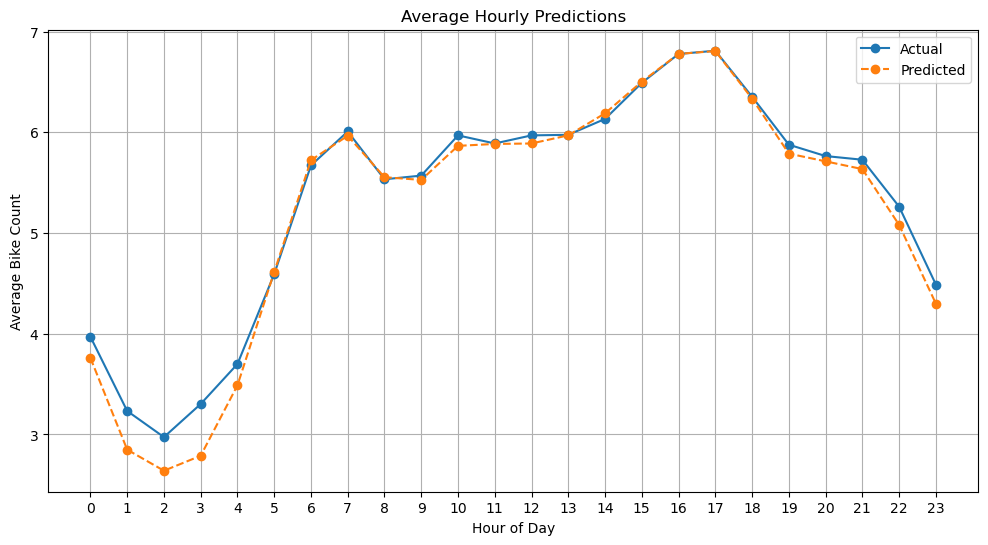

In [46]:
# Plot predictions for one station with hourly aggregation
mask = (
    (data.loc[X_valid.index, "counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data.loc[X_valid.index, "date"] > pd.to_datetime("2021/09/01"))
    & (data.loc[X_valid.index, "date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = y_valid[mask]
df_viz["bike_count_predicted"] = best_pipe.predict(X_valid[mask])
df_viz["hour"] = data.loc[df_viz.index, "date"].dt.hour
df_viz["date"] = data.loc[df_viz.index, "date"].dt.date

# Aggregate by hour
hourly_actual = df_viz.groupby("hour")["bike_count"].mean()
hourly_predicted = df_viz.groupby("hour")["bike_count_predicted"].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_actual.index, hourly_actual.values, label="Actual", marker='o')
plt.plot(hourly_predicted.index, hourly_predicted.values, '--', label="Predicted", marker='o')
plt.title("Average Hourly Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

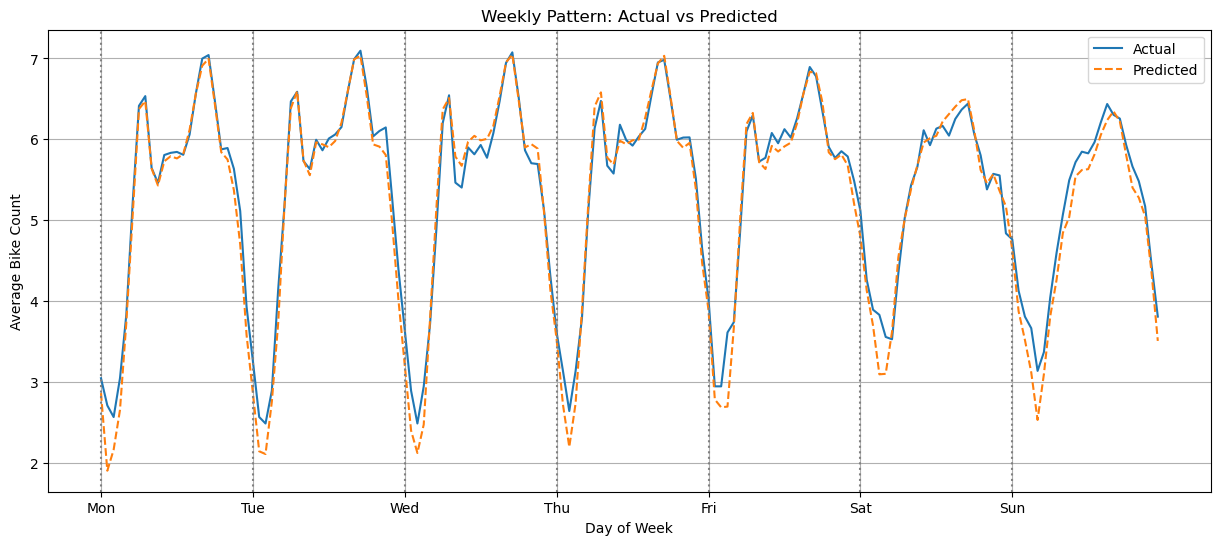

In [47]:
# Group by weekday and hour, get means
weekly_data = df_viz.groupby(['weekday', 'hour']).agg({
   'bike_count': 'mean',
   'bike_count_predicted': 'mean'
}).reset_index()

# Create x-axis with 24 hours per weekday (168 total points)
weekly_data['x_axis'] = weekly_data['weekday'] * 24 + weekly_data['hour']

plt.figure(figsize=(15, 6))
plt.plot(weekly_data['x_axis'], weekly_data['bike_count'], label='Actual')
plt.plot(weekly_data['x_axis'], weekly_data['bike_count_predicted'], '--', label='Predicted')

# Customize x-axis
plt.xticks(np.arange(0, 168, 24), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
for i in range(0, 168, 24):
   plt.axvline(x=i, color='gray', linestyle=':')

plt.title("Weekly Pattern: Actual vs Predicted")
plt.xlabel("Day of Week")
plt.ylabel("Average Bike Count")
plt.legend()
plt.grid(True)
plt.show()

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

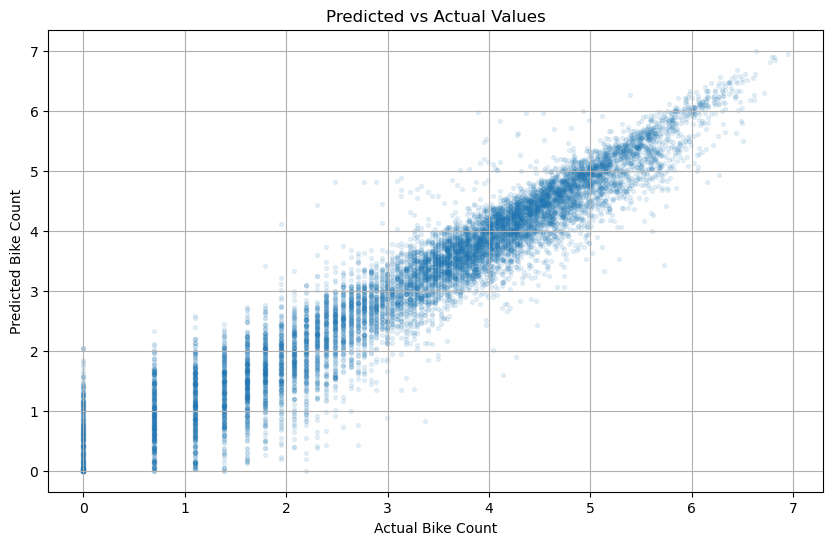

In [48]:
# Plot predicted vs actual values
fig, ax = plt.subplots(figsize=(10, 6))

df_viz = pd.DataFrame({
    "y_true": y_valid, 
    "y_pred": best_pipe.predict(X_valid)
}).sample(10000, random_state=0)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.grid(True)
plt.show()

### Feature Importance for Linear Regression

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [54]:
from sklearn.inspection import permutation_importance

# Assuming your model is called 'pipe'
result = permutation_importance(
    best_pipe, X_valid, y_valid,
    n_repeats=10,
    random_state=42
)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)

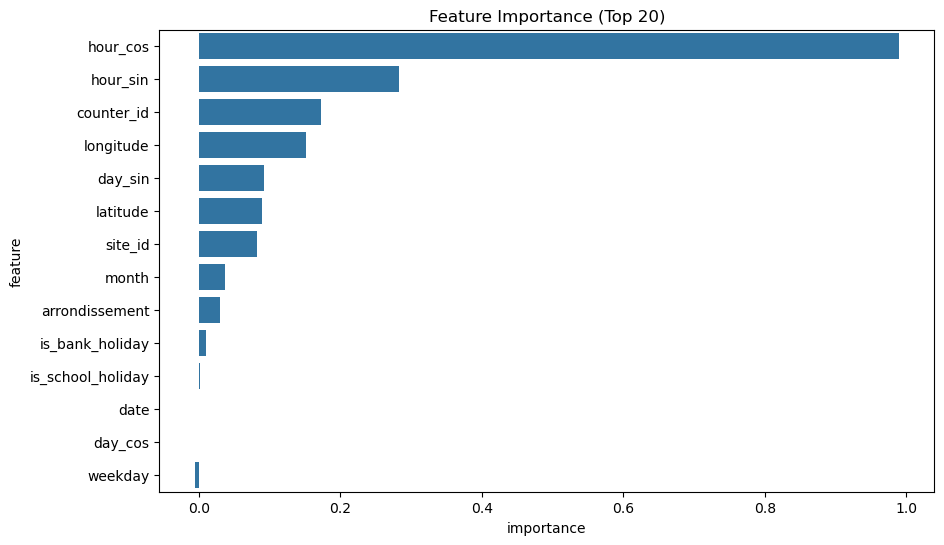

In [55]:
# Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature', ax=ax)
ax.set_title('Feature Importance (Top 20)')
plt.show()


# 5.1 Error identification

### Function to RUN (It's working !!)

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's create a dataframe containing all our error analysis information
def analyze_model_errors(X_valid, y_valid, y_valid_pred):
    # Calculate the errors
    errors = y_valid - y_valid_pred
    abs_errors = np.abs(errors)
    
    # Create our analysis dataframe with all relevant information
    error_df = pd.DataFrame({
        'date': X_valid['date'],
        'site_name': X_valid['site_name'],
        'hour': X_valid['date'].dt.hour,
        'weekday': X_valid['weekday'],
        'month': X_valid['month'],
        'actual': y_valid,
        'predicted': y_valid_pred,
        'error': errors,
        'abs_error': abs_errors
    })
    
    # Create visualizations to understand error patterns
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Average error by hour of day
    plt.subplot(2, 2, 1)
    hourly_errors = error_df.groupby('hour')['abs_error'].mean()
    hourly_errors.plot(kind='line', marker='o')
    plt.title('Average Error by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Absolute Error')
    
    # Plot 2: Average error by site (top 10 worst performing sites)
    plt.subplot(2, 2, 2)
    site_errors = error_df.groupby('site_name')['abs_error'].mean().sort_values(ascending=False)[:10]
    site_errors.plot(kind='bar')
    plt.title('Top 10 Sites with Highest Average Error')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Absolute Error')
    
    # Plot 3: Average error by day of week
    plt.subplot(2, 2, 3)
    weekday_errors = error_df.groupby('weekday')['abs_error'].mean()
    weekday_errors.plot(kind='bar')
    plt.title('Average Error by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Average Absolute Error')
    
    # Plot 4: Actual vs Predicted scatter plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_valid, y_valid_pred, alpha=0.1)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nError Analysis Summary:")
    print("-----------------------")
    print(f"Overall RMSE: {np.sqrt(np.mean(errors**2)):.3f}")
    print("\nWorst Performing Sites:")
    worst_sites = error_df.groupby('site_name').agg({
        'abs_error': ['mean', 'count']
    }).sort_values(('abs_error', 'mean'), ascending=False)
    print(worst_sites.head().to_string())
    
    return error_df

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3880412793.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  site_errors = error_df.groupby('site_name')['abs_error'].mean().sort_values(ascending=False)[:10]


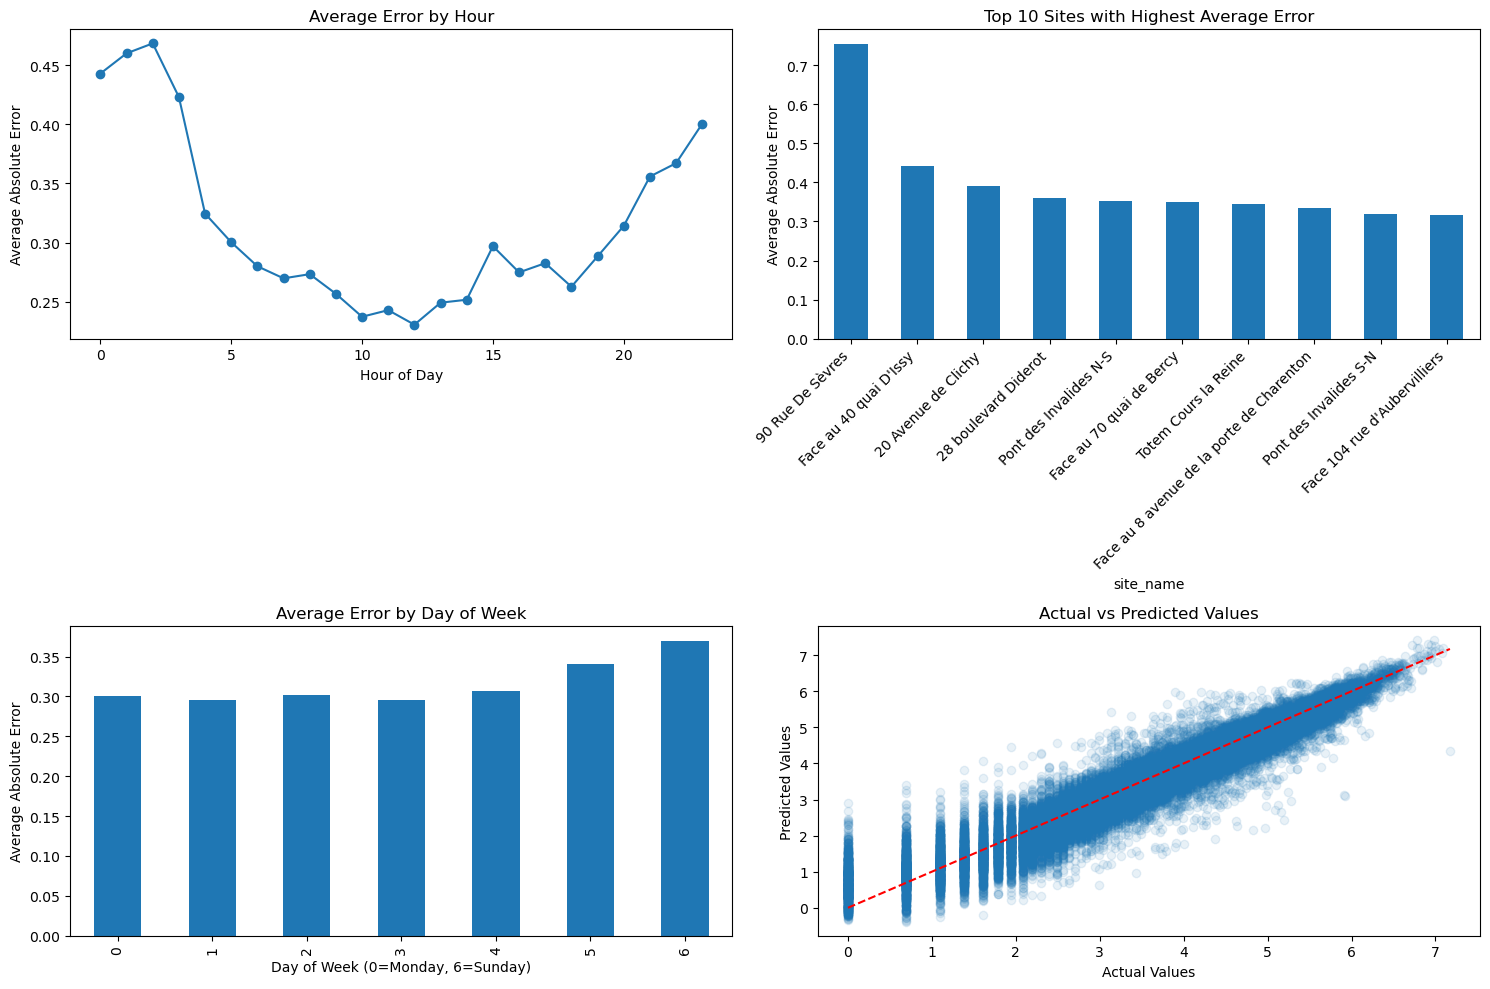


Error Analysis Summary:
-----------------------
Overall RMSE: 0.427

Worst Performing Sites:
                       abs_error      
                            mean count
site_name                             
90 Rue De Sèvres        0.753580  1440
Face au 40 quai D'Issy  0.442203  1440
20 Avenue de Clichy     0.390490  1440
28 boulevard Diderot    0.359675  1440
Pont des Invalides N-S  0.350985   720


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3880412793.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_sites = error_df.groupby('site_name').agg({


In [69]:
# Use the function with your validation data
error_analysis = analyze_model_errors(X_valid, y_valid, y_valid_pred)

### Par site

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3222576923.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_metrics = train_results.groupby('site_name').agg({
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_7


Performance globale du modèle:
Train set RMSE = 0.369
Valid set RMSE = 0.427


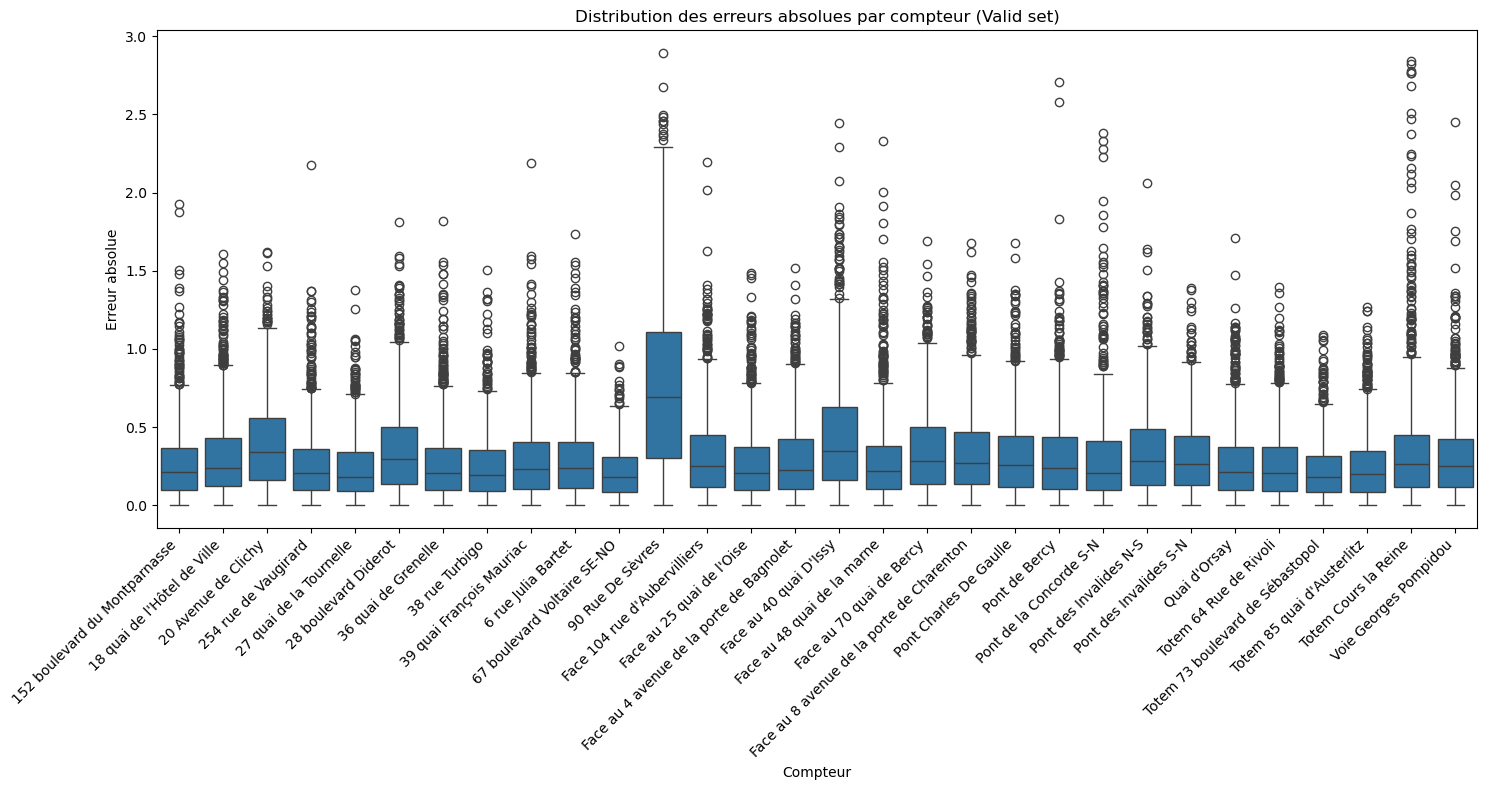


RMSE par compteur (Valid set):
site_name
90 Rue De Sèvres                             0.924
Face au 40 quai D'Issy                       0.576
Totem Cours la Reine                         0.495
20 Avenue de Clichy                          0.483
Pont de la Concorde S-N                      0.468
28 boulevard Diderot                         0.463
Pont des Invalides N-S                       0.456
Face au 70 quai de Bercy                     0.443
Face au 8 avenue de la porte de Charenton    0.427
Pont de Bercy                                0.414
Face 104 rue d'Aubervilliers                 0.414
Pont des Invalides S-N                       0.407
18 quai de l'Hôtel de Ville                  0.406
Voie Georges Pompidou                        0.406
Pont Charles De Gaulle                       0.401
Face au 48 quai de la marne                  0.386
Face au 4 avenue de la porte de Bagnolet     0.381
39 quai François Mauriac                     0.379
6 rue Julia Bartet                      

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3222576923.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_rmse = valid_results.groupby('site_name').apply(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-package

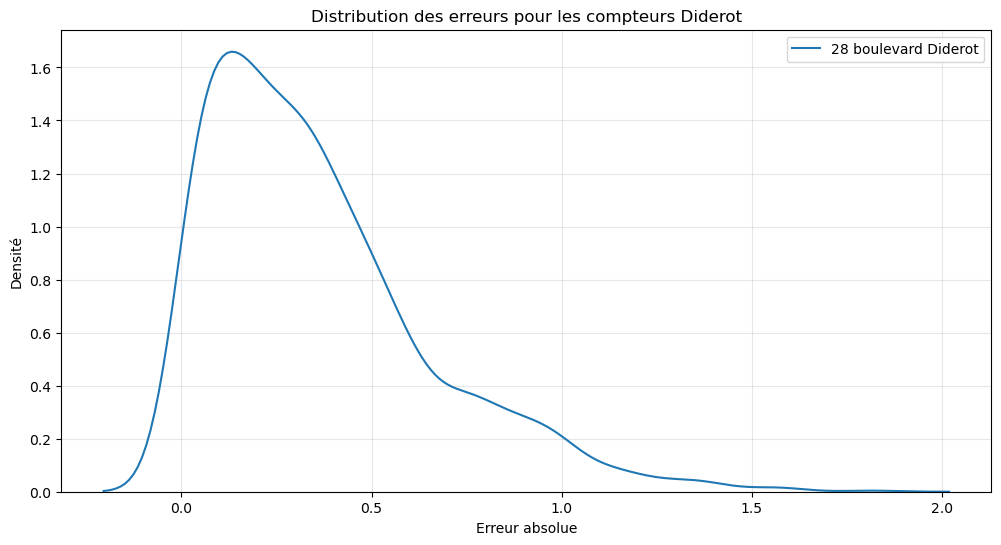


Statistiques détaillées pour les compteurs Diderot:
                                          absolute_error                          actual predicted
                                                   count  mean    std  min    max   mean      mean
site_name                                                                                         
152 boulevard du Montparnasse                          0   NaN    NaN  NaN    NaN    NaN       NaN
18 quai de l'Hôtel de Ville                            0   NaN    NaN  NaN    NaN    NaN       NaN
20 Avenue de Clichy                                    0   NaN    NaN  NaN    NaN    NaN       NaN
254 rue de Vaugirard                                   0   NaN    NaN  NaN    NaN    NaN       NaN
27 quai de la Tournelle                                0   NaN    NaN  NaN    NaN    NaN       NaN
28 boulevard Diderot                                1440  0.36  0.292  0.0  1.815  2.106     2.104
36 quai de Grenelle                                    0

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3222576923.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diderot_stats = valid_results[valid_results['site_name'].str.contains('Diderot')].groupby('site_name').agg({


In [70]:
def analyze_model_errors(X_train, X_valid, y_train, y_train_pred, y_valid, y_valid_pred):
    # Overall metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    print("\nPerformance globale du modèle:")
    print(f"Train set RMSE = {train_rmse:.3f}")
    print(f"Valid set RMSE = {valid_rmse:.3f}")
    
    # Create DataFrames for analysis
    train_results = pd.DataFrame({
        'site_name': X_train['site_name'],
        'actual': y_train,
        'predicted': y_train_pred,
        'absolute_error': np.abs(y_train - y_train_pred)
    })
    
    valid_results = pd.DataFrame({
        'site_name': X_valid['site_name'],
        'actual': y_valid,
        'predicted': y_valid_pred,
        'absolute_error': np.abs(y_valid - y_valid_pred)
    })
    
    # Calculate metrics by location
    train_metrics = train_results.groupby('site_name').agg({
        'actual': ['count', 'mean'],
        'predicted': 'mean',
        'absolute_error': ['mean', 'std']
    }).round(3)
    
    valid_metrics = valid_results.groupby('site_name').agg({
        'actual': ['count', 'mean'],
        'predicted': 'mean',
        'absolute_error': ['mean', 'std']
    }).round(3)
    
    # Visualize error distribution by location
    plt.figure(figsize=(15, 8))
    
    # Create boxplot of absolute errors by location
    sns.boxplot(data=valid_results, x='site_name', y='absolute_error')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution des erreurs absolues par compteur (Valid set)')
    plt.xlabel('Compteur')
    plt.ylabel('Erreur absolue')
    plt.tight_layout()
    plt.show()
    
    # Calculate RMSE by location for validation set
    location_rmse = valid_results.groupby('site_name').apply(
        lambda x: mean_squared_error(x['actual'], x['predicted'], squared=False)
    ).round(3)
    
    print("\nRMSE par compteur (Valid set):")
    print(location_rmse.sort_values(ascending=False))
    
    # Focus on Diderot counters
    diderot_data = valid_results[valid_results['site_name'].str.contains('Diderot')]
    
    plt.figure(figsize=(12, 6))
    for counter in diderot_data['site_name'].unique():
        counter_data = diderot_data[diderot_data['site_name'] == counter]
        sns.kdeplot(data=counter_data['absolute_error'], label=counter)
    
    plt.title('Distribution des erreurs pour les compteurs Diderot')
    plt.xlabel('Erreur absolue')
    plt.ylabel('Densité')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print detailed statistics for Diderot counters
    print("\nStatistiques détaillées pour les compteurs Diderot:")
    diderot_stats = valid_results[valid_results['site_name'].str.contains('Diderot')].groupby('site_name').agg({
        'absolute_error': ['count', 'mean', 'std', 'min', 'max'],
        'actual': 'mean',
        'predicted': 'mean'
    }).round(3)
    print(diderot_stats)
    
    return train_metrics, valid_metrics, location_rmse

# Run the analysis
train_metrics, valid_metrics, location_rmse = analyze_model_errors(
    X_train, X_valid, y_train, y_train_pred, y_valid, y_valid_pred
)

### Par counter

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3483431508.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_metrics = train_results.groupby('counter_name').agg({
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykerne


Performance globale du modèle:
Train set RMSE = 0.369
Valid set RMSE = 0.427


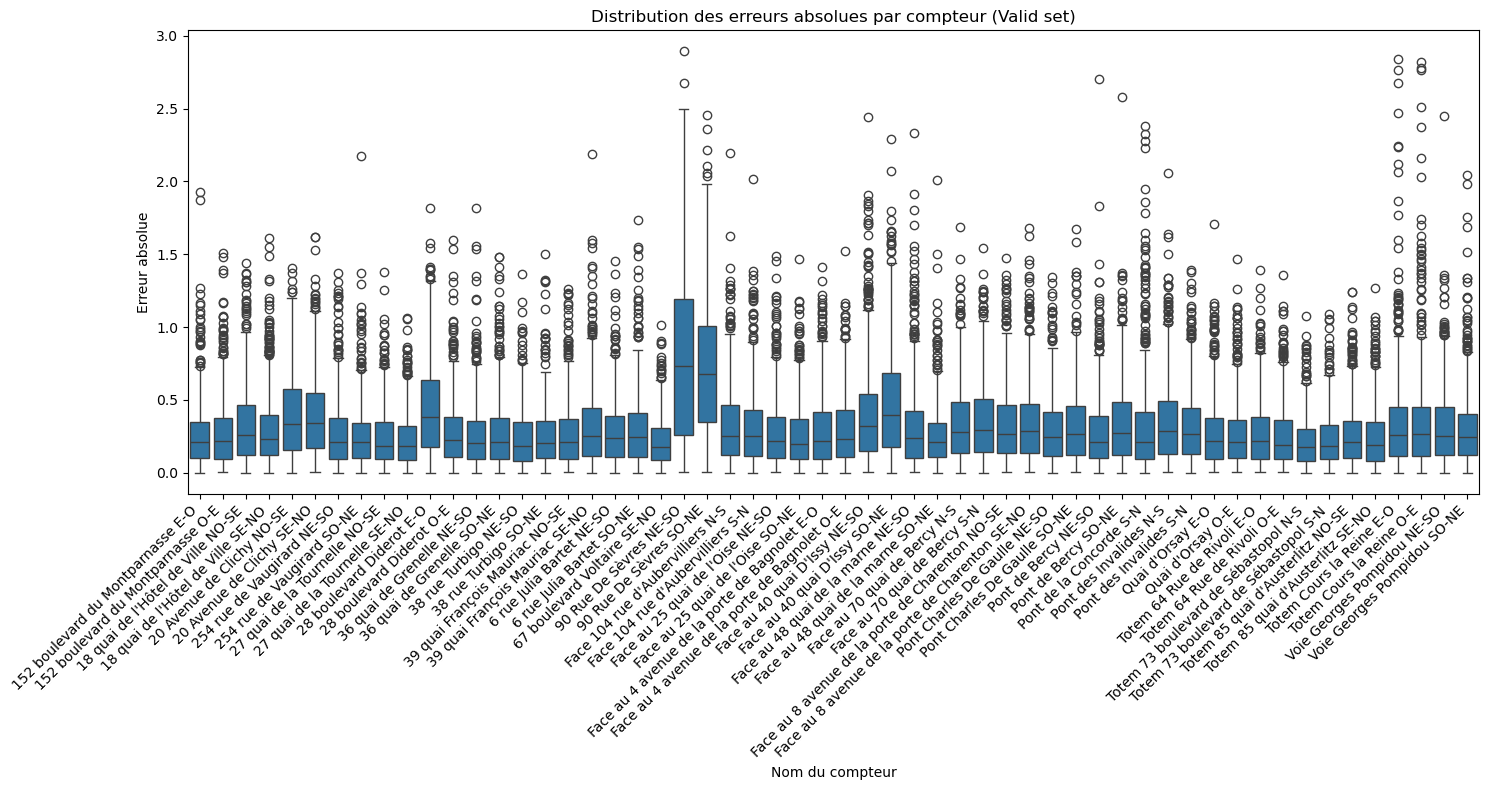

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3483431508.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counter_rmse = valid_results.groupby('counter_name').apply(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packa


RMSE par compteur (Valid set):
counter_name
90 Rue De Sèvres NE-SO                  0.973
90 Rue De Sèvres SO-NE                  0.872
Face au 40 quai D'Issy SO-NE            0.602
Face au 40 quai D'Issy NE-SO            0.550
28 boulevard Diderot E-O                0.549
                                        ...  
38 rue Turbigo NE-SO                    0.311
27 quai de la Tournelle SE-NO           0.293
Totem 73 boulevard de Sébastopol S-N    0.291
67 boulevard Voltaire SE-NO             0.277
Totem 73 boulevard de Sébastopol N-S    0.273
Length: 56, dtype: float64


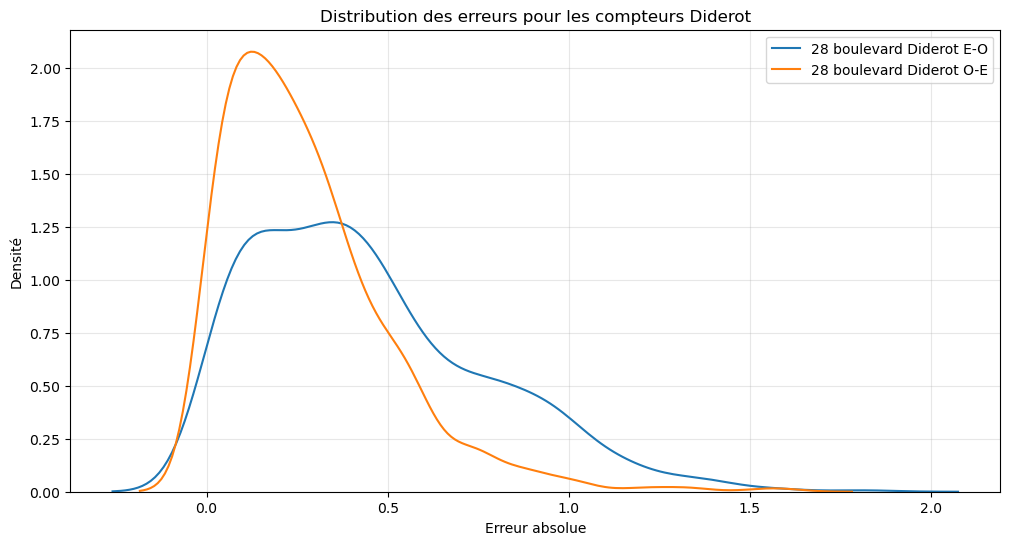


Statistiques détaillées pour les compteurs Diderot:
                                  absolute_error                  actual predicted
                                           count mean std min max   mean      mean
counter_name                                                                      
152 boulevard du Montparnasse E-O              0  NaN NaN NaN NaN    NaN       NaN
152 boulevard du Montparnasse O-E              0  NaN NaN NaN NaN    NaN       NaN
18 quai de l'Hôtel de Ville NO-SE              0  NaN NaN NaN NaN    NaN       NaN
18 quai de l'Hôtel de Ville SE-NO              0  NaN NaN NaN NaN    NaN       NaN
20 Avenue de Clichy NO-SE                      0  NaN NaN NaN NaN    NaN       NaN
...                                          ...  ...  ..  ..  ..    ...       ...
Totem 85 quai d'Austerlitz SE-NO               0  NaN NaN NaN NaN    NaN       NaN
Totem Cours la Reine E-O                       0  NaN NaN NaN NaN    NaN       NaN
Totem Cours la Reine O-E          

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_74631/3483431508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby('counter_name').agg({


In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_model_errors_by_counter(X_train, X_valid, y_train, y_train_pred, y_valid, y_valid_pred):
    # Overall metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    print("\nPerformance globale du modèle:")
    print(f"Train set RMSE = {train_rmse:.3f}")
    print(f"Valid set RMSE = {valid_rmse:.3f}")
    
    # Create DataFrames for analysis
    train_results = pd.DataFrame({
        'counter_name': X_train['counter_name'],
        'actual': y_train,
        'predicted': y_train_pred,
        'absolute_error': np.abs(y_train - y_train_pred)
    })
    
    valid_results = pd.DataFrame({
        'counter_name': X_valid['counter_name'],
        'actual': y_valid,
        'predicted': y_valid_pred,
        'absolute_error': np.abs(y_valid - y_valid_pred)
    })
    
    # Calculate metrics by counter
    train_metrics = train_results.groupby('counter_name').agg({
        'actual': ['count', 'mean'],
        'predicted': 'mean',
        'absolute_error': ['mean', 'std']
    }).round(3)
    
    valid_metrics = valid_results.groupby('counter_name').agg({
        'actual': ['count', 'mean'],
        'predicted': 'mean',
        'absolute_error': ['mean', 'std']
    }).round(3)
    
    # Visualize error distribution by counter
    plt.figure(figsize=(15, 8))
    
    # Create boxplot of absolute errors by counter
    sns.boxplot(data=valid_results, x='counter_name', y='absolute_error')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution des erreurs absolues par compteur (Valid set)')
    plt.xlabel('Nom du compteur')
    plt.ylabel('Erreur absolue')
    plt.tight_layout()
    plt.show()
    
    # Calculate RMSE by counter for validation set
    counter_rmse = valid_results.groupby('counter_name').apply(
        lambda x: mean_squared_error(x['actual'], x['predicted'], squared=False)
    ).round(3)
    
    print("\nRMSE par compteur (Valid set):")
    print(counter_rmse.sort_values(ascending=False))
    
    # Focus on specific counter analysis (e.g., Diderot counters)
    diderot_data = valid_results[valid_results['counter_name'].str.contains('Diderot', case=False)]
    
    if not diderot_data.empty:
        plt.figure(figsize=(12, 6))
        for counter in diderot_data['counter_name'].unique():
            counter_data = diderot_data[diderot_data['counter_name'] == counter]
            sns.kdeplot(data=counter_data['absolute_error'], label=counter)
        
        plt.title('Distribution des erreurs pour les compteurs Diderot')
        plt.xlabel('Erreur absolue')
        plt.ylabel('Densité')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print detailed statistics for Diderot counters
        print("\nStatistiques détaillées pour les compteurs Diderot:")
        diderot_stats = valid_results[
            valid_results['counter_name'].str.contains('Diderot', case=False)
        ].groupby('counter_name').agg({
            'absolute_error': ['count', 'mean', 'std', 'min', 'max'],
            'actual': 'mean',
            'predicted': 'mean'
        }).round(3)
        print(diderot_stats)
    
    return train_metrics, valid_metrics, counter_rmse

# Run the analysis
train_metrics, valid_metrics, counter_rmse = analyze_model_errors_by_counter(
    X_train, X_valid, y_train, y_train_pred, y_valid, y_valid_pred
)

# Additional analysis: Print top 5 worst performing counters
print("\nTop 5 des compteurs avec les plus grandes erreurs (RMSE):")
print(counter_rmse.nlargest(5))

# Additional analysis: Print top 5 best performing counters
print("\nTop 5 des compteurs avec les plus petites erreurs (RMSE):")
print(counter_rmse.nsmallest(5))

#### Night Prediction

In [72]:
# First, let's verify the zero-value hypothesis
def analyze_night_predictions(error_df):
    # Create night mask (between 22:00 and 5:00)
    night_mask = (error_df['hour'].isin(list(range(0, 6)) + list(range(22, 24))))
    
    # Calculate zero-value statistics
    zero_counts = (error_df[night_mask]['actual'] == 0).sum()
    total_night = night_mask.sum()
    
    print(f"Zero values during night: {zero_counts} out of {total_night} records ({zero_counts/total_night*100:.1f}%)")
    
    # Compare error distribution for zero vs non-zero values
    zero_errors = error_df[error_df['actual'] == 0]['abs_error'].mean()
    non_zero_errors = error_df[error_df['actual'] > 0]['abs_error'].mean()
    
    print(f"\nAverage error for zero values: {zero_errors:.3f}")
    print(f"Average error for non-zero values: {non_zero_errors:.3f}")

In [73]:
analyze_night_predictions(error_analysis)

Zero values during night: 1095 out of 13440 records (8.1%)

Average error for zero values: 0.726
Average error for non-zero values: 0.302


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_night_predictions(error_df, site_name=None):
    # Filter for specific site if provided
    if site_name:
        error_df = error_df[error_df['site_name'] == site_name].copy()
        print(f"Analysing night predictions for: {site_name}\n")
    
    # Define night hours (22:00-05:00)
    night_hours = list(range(0, 6)) + list(range(22, 24))
    error_df['is_night'] = error_df['hour'].isin(night_hours)
    
    # Basic statistics
    night_data = error_df[error_df['is_night']]
    day_data = error_df[~error_df['is_night']]
    
    print("Statistiques de base:")
    print(f"Nombre total d'observations de nuit: {len(night_data)}")
    print(f"Valeurs nulles la nuit: {(night_data['actual'] == 0).sum()} ({(night_data['actual'] == 0).mean()*100:.1f}%)")
    print(f"Erreur moyenne la nuit: {night_data['absolute_error'].mean():.3f}")
    print(f"Erreur moyenne le jour: {day_data['absolute_error'].mean():.3f}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of actual vs predicted values at night
    axes[0,0].scatter(night_data['actual'], night_data['predicted'], alpha=0.5)
    axes[0,0].plot([0, night_data['actual'].max()], [0, night_data['actual'].max()], 'r--')
    axes[0,0].set_title('Valeurs prédites vs réelles (nuit)')
    axes[0,0].set_xlabel('Valeurs réelles')
    axes[0,0].set_ylabel('Valeurs prédites')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Error distribution by hour (night hours highlighted)
    hourly_errors = error_df.groupby('hour')['absolute_error'].mean()
    axes[0,1].bar(hourly_errors.index, hourly_errors.values, 
                 color=['darkblue' if h in night_hours else 'lightblue' for h in range(24)])
    axes[0,1].set_title('Erreur moyenne par heure')
    axes[0,1].set_xlabel('Heure')
    axes[0,1].set_ylabel('Erreur absolue moyenne')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Distribution of errors for night vs day
    sns.kdeplot(data=night_data['absolute_error'], label='Nuit', ax=axes[1,0])
    sns.kdeplot(data=day_data['absolute_error'], label='Jour', ax=axes[1,0])
    axes[1,0].set_title('Distribution des erreurs (jour vs nuit)')
    axes[1,0].set_xlabel('Erreur absolue')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Error vs traffic volume at night
    axes[1,1].scatter(night_data['actual'], night_data['absolute_error'], alpha=0.5)
    axes[1,1].set_title('Erreur vs Volume de trafic (nuit)')
    axes[1,1].set_xlabel('Trafic réel')
    axes[1,1].set_ylabel('Erreur absolue')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed analysis of night predictions
    print("\nAnalyse détaillée des prédictions nocturnes:")
    night_stats = night_data.groupby('hour').agg({
        'actual': ['count', 'mean', 'std'],
        'predicted': ['mean', 'std'],
        'absolute_error': ['mean', 'std']
    }).round(3)
    print("\nStatistiques par heure de nuit:")
    print(night_stats)
    
    # Analysis of zero vs non-zero values
    night_zeros = night_data[night_data['actual'] == 0]
    night_non_zeros = night_data[night_data['actual'] > 0]
    
    print("\nAnalyse des valeurs nulles vs non-nulles (nuit):")
    print(f"Erreur moyenne pour valeurs nulles: {night_zeros['absolute_error'].mean():.3f}")
    print(f"Erreur moyenne pour valeurs non-nulles: {night_non_zeros['absolute_error'].mean():.3f}")
    
    # Additional insights
    print("\nInsights supplémentaires:")
    print(f"Plus grande erreur de nuit: {night_data['absolute_error'].max():.3f}")
    print(f"Médiane des erreurs de nuit: {night_data['absolute_error'].median():.3f}")
    print(f"90ème percentile des erreurs de nuit: {night_data['absolute_error'].quantile(0.9):.3f}")
    
    return night_data, night_stats

# Utilisation de la fonction
night_data, night_stats = analyze_night_predictions(error_analysis, "28 boulevard Diderot")

Analysing night predictions for: 28 boulevard Diderot

Statistiques de base:
Nombre total d'observations de nuit: 480
Valeurs nulles la nuit: 122 (25.4%)


KeyError: 'absolute_error'

#### Boulevard Diderot

In [112]:
def analyze_site_characteristics(error_df, site_name):
    # Compare this site's patterns with others
    site_data = error_df[error_df['site_name'] == site_name]
    other_data = error_df[error_df['site_name'] != site_name]
    
    # Analyze hourly patterns
    site_hourly = site_data.groupby('hour')['actual'].mean()
    others_hourly = other_data.groupby('hour')['actual'].mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(site_hourly.index, site_hourly.values, label='Boulevard Diderot')
    plt.plot(others_hourly.index, others_hourly.values, label='Other Sites Average')
    plt.title('Traffic Pattern Comparison')
    plt.legend()
    plt.show()
    
    # Print summary statistics
    print(f"\nSite statistics for {site_name}:")
    print(f"Average traffic: {site_data['actual'].mean():.2f}")
    print(f"Traffic variance: {site_data['actual'].var():.2f}")
    print(f"Zero-value percentage: {(site_data['actual'] == 0).mean()*100:.1f}%")
    
def analyze_site_predictions_by_hour(error_df, site_name):
        # Filter data for the specific site
    site_data = error_df[error_df['site_name'] == site_name].copy()
    
    # Calculate hourly averages for both actual and predicted values
    hourly_comparison = site_data.groupby('hour').agg({
        'actual': 'mean',
        'predicted': 'mean',
        'abs_error': 'mean'
    }).reset_index()
    
    # Create the visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Actual vs Predicted by Hour
    plt.subplot(2, 1, 1)
    plt.plot(hourly_comparison['hour'], hourly_comparison['actual'], 
             'b-', marker='o', label='Actual Values', linewidth=2)
    plt.plot(hourly_comparison['hour'], hourly_comparison['predicted'], 
             'r--', marker='o', label='Predicted Values', linewidth=2)
    plt.fill_between(hourly_comparison['hour'], 
                     hourly_comparison['actual'], 
                     hourly_comparison['predicted'], 
                     alpha=0.2, color='gray', label='Difference')
    plt.title(f'Actual vs Predicted Values Throughout the Day\nAt {site_name}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Log Bike Count')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Absolute Error by Hour
    plt.subplot(2, 1, 2)
    plt.bar(hourly_comparison['hour'], hourly_comparison['abs_error'], 
            color='orange', alpha=0.7)
    plt.title('Average Absolute Error by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Absolute Error')
    plt.grid(True, alpha=0.3)
    
    # Add some analytics as text
    worst_hour = hourly_comparison.loc[hourly_comparison['abs_error'].idxmax()]
    best_hour = hourly_comparison.loc[hourly_comparison['abs_error'].idxmin()]
    
    plt.figtext(0.02, 0.02, 
                f'Worst performing hour: {int(worst_hour["hour"]):02d}:00 (Error: {worst_hour["abs_error"]:.3f})\n'
                f'Best performing hour: {int(best_hour["hour"]):02d}:00 (Error: {best_hour["abs_error"]:.3f})',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nHourly Statistics Summary:")
    print("--------------------------")
    print("Top 3 Hours with Largest Prediction Errors:")
    worst_hours = hourly_comparison.nlargest(3, 'abs_error')
    for _, row in worst_hours.iterrows():
        print(f"Hour {int(row['hour']):02d}:00")
        print(f"  Actual avg: {row['actual']:.2f}")
        print(f"  Predicted avg: {row['predicted']:.2f}")
        print(f"  Absolute Error: {row['abs_error']:.3f}")
        print()
        
        
def analyze_prediction_spread(error_df, site_name):
    site_data = error_df[error_df['site_name'] == site_name].copy()
    
    # Create box plot to show error distribution by hour
    plt.figure(figsize=(15, 6))
    plt.boxplot([site_data[site_data['hour'] == h]['error'] 
                 for h in range(24)], labels=range(24))
    plt.title('Distribution of Prediction Errors by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Error (Predicted - Actual)')
    plt.grid(True, alpha=0.3)
    
    # Add a line at y=0 to show perfect predictions
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.show()
    
    # Print detailed statistics for the worst hour
    worst_hour = 19  # From your plot
    worst_hour_data = site_data[site_data['hour'] == worst_hour]
    print(f"\nDetailed statistics for hour {worst_hour}:00")
    print(f"Number of predictions: {len(worst_hour_data)}")
    print(f"Standard deviation of errors: {worst_hour_data['error'].std():.3f}")
    print(f"25th percentile of absolute error: {worst_hour_data['abs_error'].quantile(0.25):.3f}")
    print(f"75th percentile of absolute error: {worst_hour_data['abs_error'].quantile(0.75):.3f}")

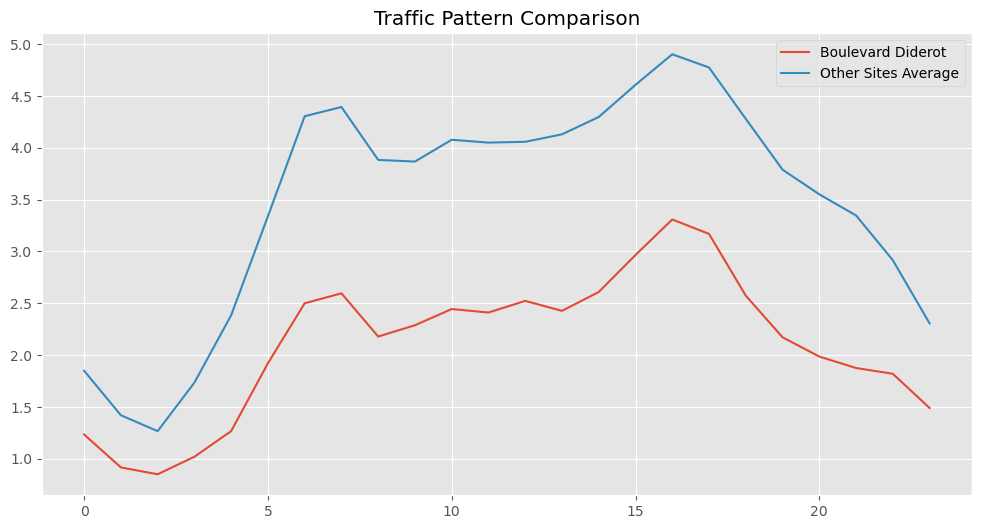


Site statistics for 28 boulevard Diderot:
Average traffic: 2.11
Traffic variance: 2.25
Zero-value percentage: 14.2%


In [113]:
analyze_site_characteristics(error_analysis, '28 boulevard Diderot')

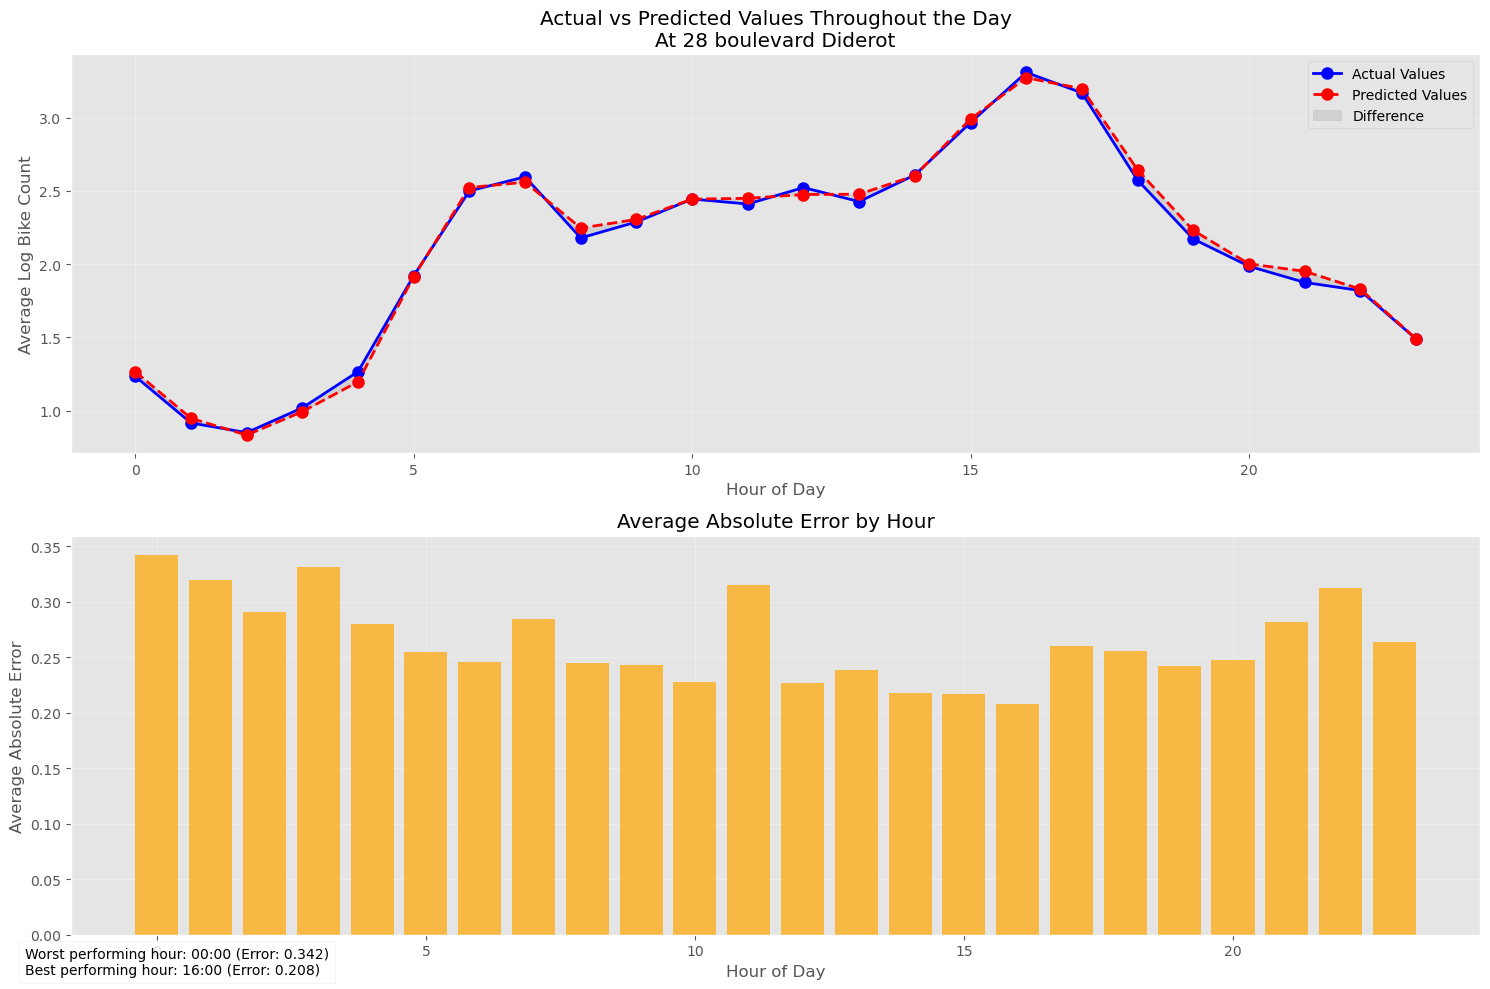


Hourly Statistics Summary:
--------------------------
Top 3 Hours with Largest Prediction Errors:
Hour 00:00
  Actual avg: 1.23
  Predicted avg: 1.27
  Absolute Error: 0.342

Hour 03:00
  Actual avg: 1.02
  Predicted avg: 0.99
  Absolute Error: 0.332

Hour 01:00
  Actual avg: 0.92
  Predicted avg: 0.95
  Absolute Error: 0.320



In [114]:
# Call the function
analyze_site_predictions_by_hour(error_analysis, "28 boulevard Diderot")

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1297454564.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([site_data[site_data['hour'] == h]['error']


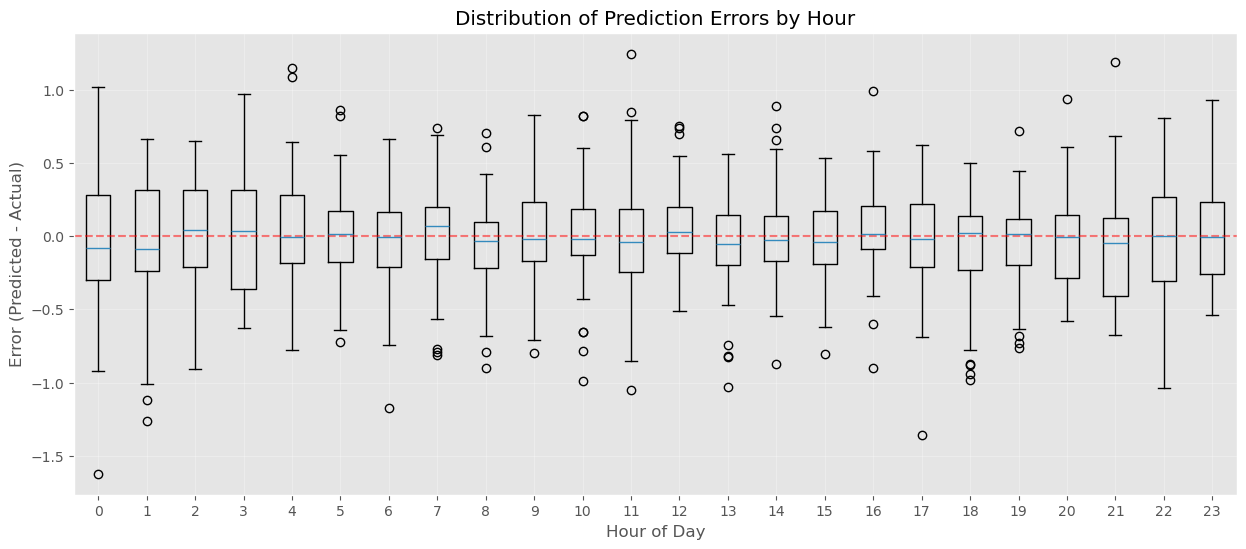


Detailed statistics for hour 19:00
Number of predictions: 60
Standard deviation of errors: 0.321
25th percentile of absolute error: 0.080
75th percentile of absolute error: 0.341


In [115]:
analyze_prediction_spread(error_analysis, "28 boulevard Diderot")

In [116]:
def analyze_site_specific_week(error_df, site_name, start_date=None):
    # Filter data for the specific site
    site_data = error_df[error_df['site_name'] == site_name].copy()
    
    # If no start date is provided, take the first complete week in our dataset
    if start_date is None:
        # Find the first Monday in our dataset
        start_date = site_data['date'].min()
        while start_date.weekday() != 0:  # 0 represents Monday
            start_date += pd.Timedelta(days=1)
    
    # Create end date (7 days after start)
    end_date = start_date + pd.Timedelta(days=7)
    
    # Filter data for our week
    week_data = site_data[
        (site_data['date'] >= start_date) & 
        (site_data['date'] < end_date)
    ]
    
    # Create the visualization
    plt.figure(figsize=(15, 8))
    
    # Plot actual and predicted values
    plt.plot(week_data['date'], week_data['actual'], 
             'b-', label='Actual Values', linewidth=2)
    plt.plot(week_data['date'], week_data['predicted'], 
             'r--', label='Predicted Values', linewidth=2)
    
    # Customize the plot
    plt.title(f'Week of Traffic at {site_name}\nFrom {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
    plt.xlabel('Date and Time')
    plt.ylabel('Log Bike Count')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Format x-axis to show days and hours clearly
    plt.gcf().autofmt_xdate()
    
    # Add day names as additional labels
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_positions = [start_date + pd.Timedelta(days=x) for x in range(7)]
    plt.gca().set_xticks(day_positions)
    plt.gca().set_xticklabels(days)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for this week
    print("\nWeekly Statistics:")
    print("-----------------")
    mae_by_day = week_data.groupby(week_data['date'].dt.day_name())['abs_error'].mean()
    print("\nMean Absolute Error by Day:")
    for day, error in mae_by_day.items():
        print(f"{day}: {error:.3f}")
    
    print("\nWorst Predictions of the Week:")
    worst_predictions = week_data.nlargest(3, 'abs_error')
    for _, row in worst_predictions.iterrows():
        print(f"\nTime: {row['date'].strftime('%A %H:%M')}")
        print(f"Actual: {row['actual']:.2f}")
        print(f"Predicted: {row['predicted']:.2f}")
        print(f"Absolute Error: {row['abs_error']:.3f}")

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1955948535.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_errors = error_analysis_df.groupby('site_name')['absolute_error'].mean().sort_values(ascending=False)
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1955948535.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_counts = error_analysis_df.groupby('site_name')['actual'].mean()


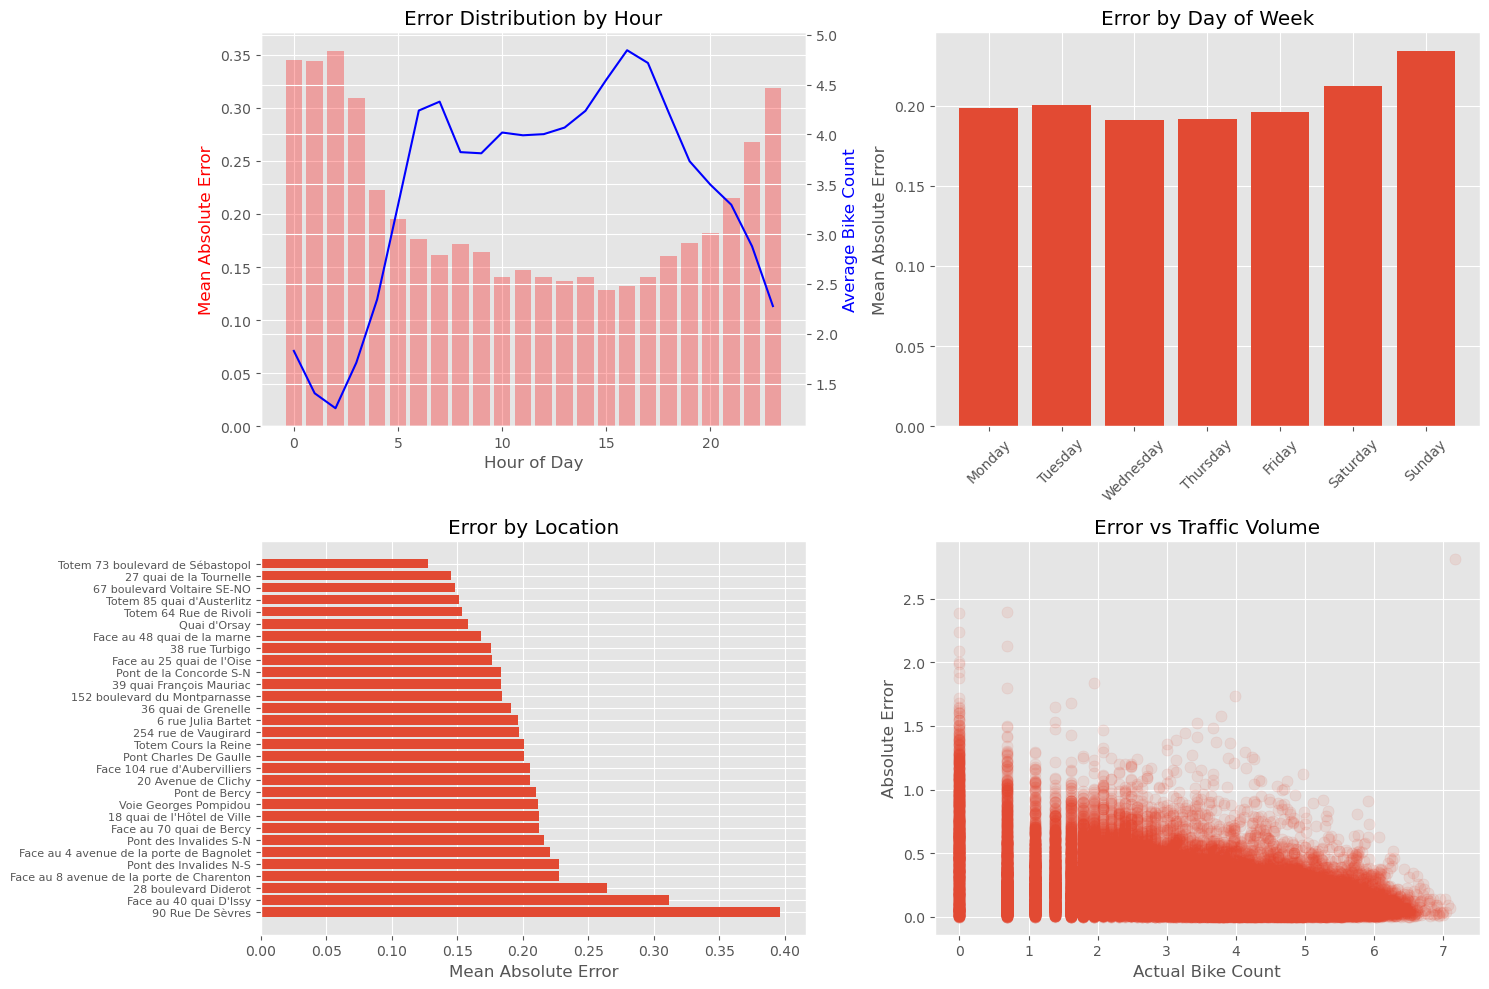


Detailed Error Analysis:

1. Time-based Insights:
Worst performing hours: hour
2    0.353558
0    0.344700
1    0.344679
Name: absolute_error, dtype: float64
Best performing hours: hour
15    0.128577
16    0.131987
13    0.136638
Name: absolute_error, dtype: float64

Weekday vs Weekend RMSE:
is_weekend
False    0.195288
True     0.223186
Name: absolute_error, dtype: float64

2. Location-based Insights:

Location Performance:
                                          absolute_error             actual
                                                    mean   std count   mean
site_name                                                                  
90 Rue De Sèvres                                    0.40  0.35  1440   3.13
Face au 40 quai D'Issy                              0.31  0.27  1440   1.37
28 boulevard Diderot                                0.26  0.22  1440   2.11
Pont des Invalides N-S                              0.23  0.21   720   2.72
Face au 8 avenue de la porte de Chare

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1955948535.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_stats = error_analysis_df.groupby('site_name').agg({
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1955948535.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(error_analysis_df.groupby('traffic_level')['absolute_error'].mean().round(2))


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta

# First, let's create a DataFrame with all our predictions and actual values
def analyze_prediction_errors(X_valid, y_valid, y_pred):
    # Create a DataFrame with all relevant information
    error_analysis_df = pd.DataFrame({
        'datetime': X_valid['date'],
        'actual': y_valid,
        'predicted': y_pred,
        'absolute_error': np.abs(y_valid - y_pred),
        'relative_error': np.abs((y_valid - y_pred) / (y_valid + 1)) * 100,  # Adding 1 to avoid division by zero
        # 'counter_name': X_valid['counter_name'],
        'site_name': X_valid['site_name']
    })
    
    # Add time-based features for analysis
    error_analysis_df['hour'] = error_analysis_df['datetime'].dt.hour
    error_analysis_df['day_of_week'] = error_analysis_df['datetime'].dt.day_name()
    error_analysis_df['is_weekend'] = error_analysis_df['datetime'].dt.weekday >= 5
    
    # 1. Temporal Error Analysis
    plt.figure(figsize=(15, 10))
    
    # Error by hour of day
    plt.subplot(2, 2, 1)
    hourly_errors = error_analysis_df.groupby('hour')['absolute_error'].mean()
    hourly_counts = error_analysis_df.groupby('hour')['actual'].mean()
    
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax1.bar(hourly_errors.index, hourly_errors.values, alpha=0.3, color='red', label='Mean Absolute Error')
    ax2.plot(hourly_counts.index, hourly_counts.values, color='blue', label='Average Actual Count')
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Mean Absolute Error', color='red')
    ax2.set_ylabel('Average Bike Count', color='blue')
    plt.title('Error Distribution by Hour')
    
    # Error by day of week
    plt.subplot(2, 2, 2)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_errors = error_analysis_df.groupby('day_of_week')['absolute_error'].mean()
    daily_errors = daily_errors.reindex(day_order)
    plt.bar(daily_errors.index, daily_errors.values)
    plt.xticks(rotation=45)
    plt.title('Error by Day of Week')
    plt.ylabel('Mean Absolute Error')
    
    # 2. Location-based Error Analysis
    plt.subplot(2, 2, 3)
    location_errors = error_analysis_df.groupby('site_name')['absolute_error'].mean().sort_values(ascending=False)
    location_counts = error_analysis_df.groupby('site_name')['actual'].mean()
    
    plt.barh(range(len(location_errors)), location_errors.values)
    plt.yticks(range(len(location_errors)), location_errors.index, fontsize=8)
    plt.title('Error by Location')
    plt.xlabel('Mean Absolute Error')
    
    # 3. Error vs Traffic Volume
    plt.subplot(2, 2, 4)
    plt.scatter(error_analysis_df['actual'], error_analysis_df['absolute_error'], alpha=0.1)
    plt.xlabel('Actual Bike Count')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Traffic Volume')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Error Analysis:")
    
    print("\n1. Time-based Insights:")
    print(f"Worst performing hours: {hourly_errors.nlargest(3)}")
    print(f"Best performing hours: {hourly_errors.nsmallest(3)}")
    print(f"\nWeekday vs Weekend RMSE:")
    print(error_analysis_df.groupby('is_weekend')['absolute_error'].mean())
    
    print("\n2. Location-based Insights:")
    location_stats = error_analysis_df.groupby('site_name').agg({
        'absolute_error': ['mean', 'std', 'count'],
        'actual': 'mean'
    }).round(2)
    print("\nLocation Performance:")
    print(location_stats.sort_values(('absolute_error', 'mean'), ascending=False))
    
    print("\n3. Volume-based Insights:")
    error_analysis_df['traffic_level'] = pd.qcut(error_analysis_df['actual'], 
                                               q=4, 
                                               labels=['Low', 'Medium', 'High', 'Very High'])
    print("\nError by Traffic Level:")
    print(error_analysis_df.groupby('traffic_level')['absolute_error'].mean().round(2))
    
    return error_analysis_df

# Use the model we created earlier
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")

# Get predictions
y_valid_pred = rf_pipe.predict(X_valid)

# Analyze errors
error_df = analyze_prediction_errors(X_valid, y_valid, y_valid_pred)

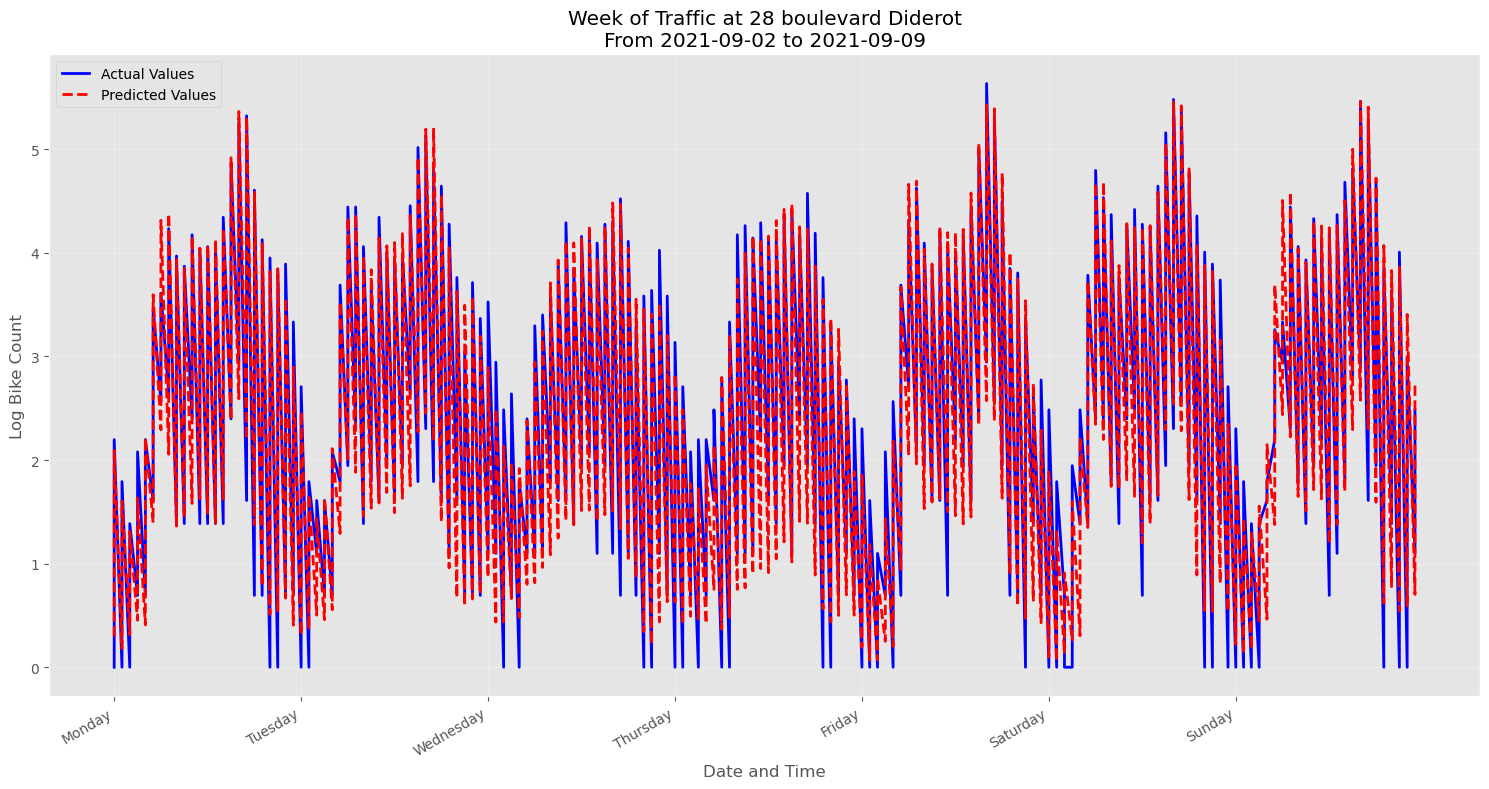


Weekly Statistics:
-----------------

Mean Absolute Error by Day:
Friday: 0.222
Monday: 0.254
Saturday: 0.282
Sunday: 0.346
Thursday: 0.211
Tuesday: 0.297
Wednesday: 0.319

Worst Predictions of the Week:

Time: Sunday 11:00
Actual: 2.20
Predicted: 0.95
Absolute Error: 1.245

Time: Wednesday 06:00
Actual: 3.33
Predicted: 4.51
Absolute Error: 1.174

Time: Wednesday 04:00
Actual: 1.61
Predicted: 0.46
Absolute Error: 1.146


In [118]:
# Let's analyze a specific week in September 2021
analyze_site_specific_week(error_analysis, "28 boulevard Diderot", pd.Timestamp('2021-09-02'))  # Starting with Monday September 6th

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/3690964532.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_5_locations = error_df.groupby('site_name')['absolute_error'].mean().nlargest(5)



Top 5 Locations with Highest Average Errors:
site_name
90 Rue De Sèvres                             0.396404
Face au 40 quai D'Issy                       0.311577
28 boulevard Diderot                         0.264666
Face au 8 avenue de la porte de Charenton    0.227417
Pont des Invalides N-S                       0.227324
Name: absolute_error, dtype: float64


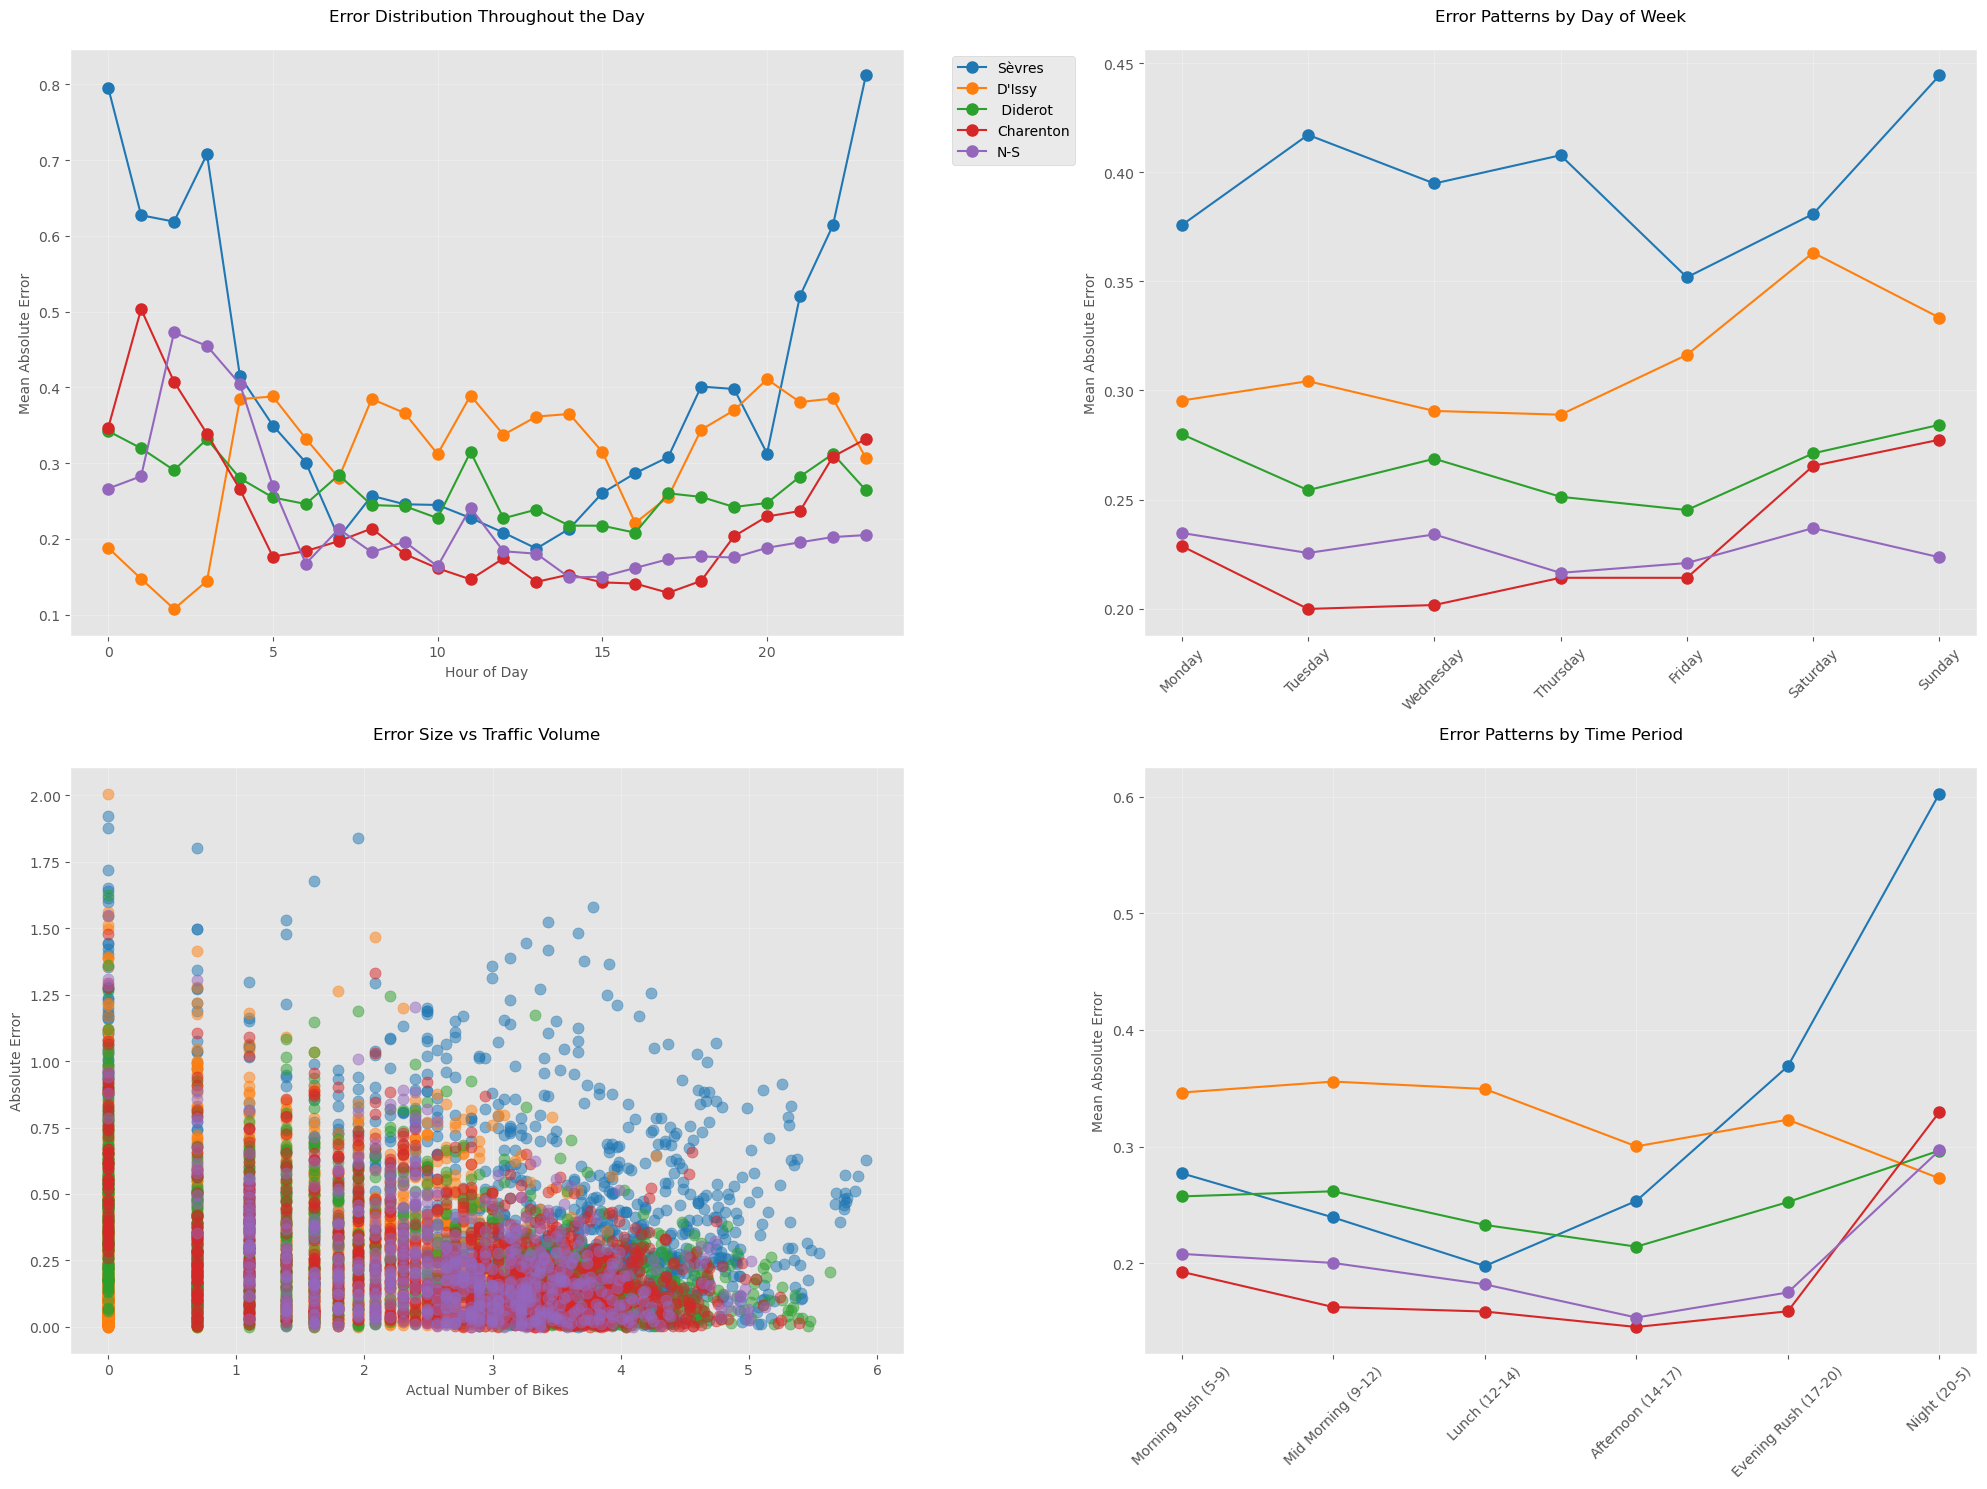


Detailed Analysis for Each Location:


Location: 90 Rue De Sèvres

Performance by Time Period:
                     absolute_error       actual predicted
                               mean count   mean      mean
time_period                                               
Afternoon (14-17)              0.25   180   4.15      4.13
Evening Rush (17-20)           0.37   180   3.89      3.88
Lunch (12-14)                  0.20   120   3.74      3.77
Mid Morning (9-12)             0.24   180   3.71      3.71
Morning Rush (5-9)             0.28   240   3.57      3.64
Night (20-5)                   0.60   540   2.02      2.05

Weekday vs Weekend Performance:
        absolute_error       actual predicted
                  mean   std   mean      mean
Weekday           0.39  0.35   3.22      3.25
Weekend           0.41  0.35   2.89      2.90

Top 5 Largest Errors:
                  datetime  actual  predicted  absolute_error
454695 2021-08-27 22:00:00    0.00       1.92            1.92
454698 20

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# First, let's create our analysis DataFrame with all the information we need
error_df = pd.DataFrame({
    'datetime': X_valid['date'],
    'site_name': X_valid['site_name'],
    'counter_name' : X_valid['counter_name'],
    'actual': y_valid,
    'predicted': y_valid_pred,
    'absolute_error': np.abs(y_valid - y_valid_pred)
})

# Adding time-based features that will help us understand error patterns
error_df['hour'] = error_df['datetime'].dt.hour
error_df['day_of_week'] = error_df['datetime'].dt.day_name()
error_df['is_weekend'] = error_df['datetime'].dt.weekday >= 5
error_df['month'] = error_df['datetime'].dt.month

# Define meaningful time periods for our analysis
def get_time_period(hour):
    if 5 <= hour < 9: return 'Morning Rush (5-9)'
    elif 9 <= hour < 12: return 'Mid Morning (9-12)'
    elif 12 <= hour < 14: return 'Lunch (12-14)'
    elif 14 <= hour < 17: return 'Afternoon (14-17)'
    elif 17 <= hour < 20: return 'Evening Rush (17-20)'
    else: return 'Night (20-5)'

error_df['time_period'] = error_df['hour'].apply(get_time_period)

# Identify our top 5 locations with highest errors
top_5_locations = error_df.groupby('site_name')['absolute_error'].mean().nlargest(5)
print("\nTop 5 Locations with Highest Average Errors:")
print(top_5_locations)

# Set up the figure for our visualizations
fig = plt.figure(figsize=(20, 15))
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.markersize'] = 8

# Let's create four informative subplots
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Default matplotlib color cycle

# 1. Hourly Error Analysis
plt.subplot(2, 2, 1)
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    hourly_errors = loc_data.groupby('hour')['absolute_error'].mean()
    plt.plot(hourly_errors.index, hourly_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Distribution Throughout the Day', fontsize=12, pad=20)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 2. Day of Week Analysis
plt.subplot(2, 2, 2)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    daily_errors = loc_data.groupby('day_of_week')['absolute_error'].mean()
    daily_errors = daily_errors.reindex(days)
    plt.plot(range(len(days)), daily_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Patterns by Day of Week', fontsize=12, pad=20)
plt.xticks(range(len(days)), days, rotation=45)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Error vs Traffic Volume
plt.subplot(2, 2, 3)
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    plt.scatter(loc_data['actual'], loc_data['absolute_error'], 
               label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
               color=colors[idx], alpha=0.5)

plt.title('Error Size vs Traffic Volume', fontsize=12, pad=20)
plt.xlabel('Actual Number of Bikes', fontsize=10)
plt.ylabel('Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Time Period Analysis
plt.subplot(2, 2, 4)
time_periods = ['Morning Rush (5-9)', 'Mid Morning (9-12)', 'Lunch (12-14)', 
                'Afternoon (14-17)', 'Evening Rush (17-20)', 'Night (20-5)']
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    period_errors = loc_data.groupby('time_period')['absolute_error'].mean()
    period_errors = period_errors.reindex(time_periods)
    plt.plot(range(len(time_periods)), period_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Patterns by Time Period', fontsize=12, pad=20)
plt.xticks(range(len(time_periods)), time_periods, rotation=45)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed statistical analysis for each problematic counter
print("\nDetailed Analysis for Each Location:")
for location in top_5_locations.index:
    print(f"\n{'='*80}")
    print(f"\nLocation: {location}")
    loc_data = error_df[error_df['site_name'] == location]
    
    # Time period statistics
    print("\nPerformance by Time Period:")
    time_stats = loc_data.groupby('time_period').agg({
        'absolute_error': ['mean', 'count'],
        'actual': 'mean',
        'predicted': 'mean'  # Added predicted values
    }).round(2)
    print(time_stats)
    
    # Weekend vs Weekday performance
    print("\nWeekday vs Weekend Performance:")
    day_type_stats = loc_data.groupby('is_weekend').agg({
        'absolute_error': ['mean', 'std'],
        'actual': 'mean',
        'predicted': 'mean'  # Added predicted values
    }).round(2)
    day_type_stats.index = ['Weekday', 'Weekend']
    print(day_type_stats)
    
    # Worst predictions
    print("\nTop 5 Largest Errors:")
    worst_predictions = loc_data.nlargest(5, 'absolute_error')[
        ['datetime', 'actual', 'predicted', 'absolute_error']
    ].round(2)
    print(worst_predictions)

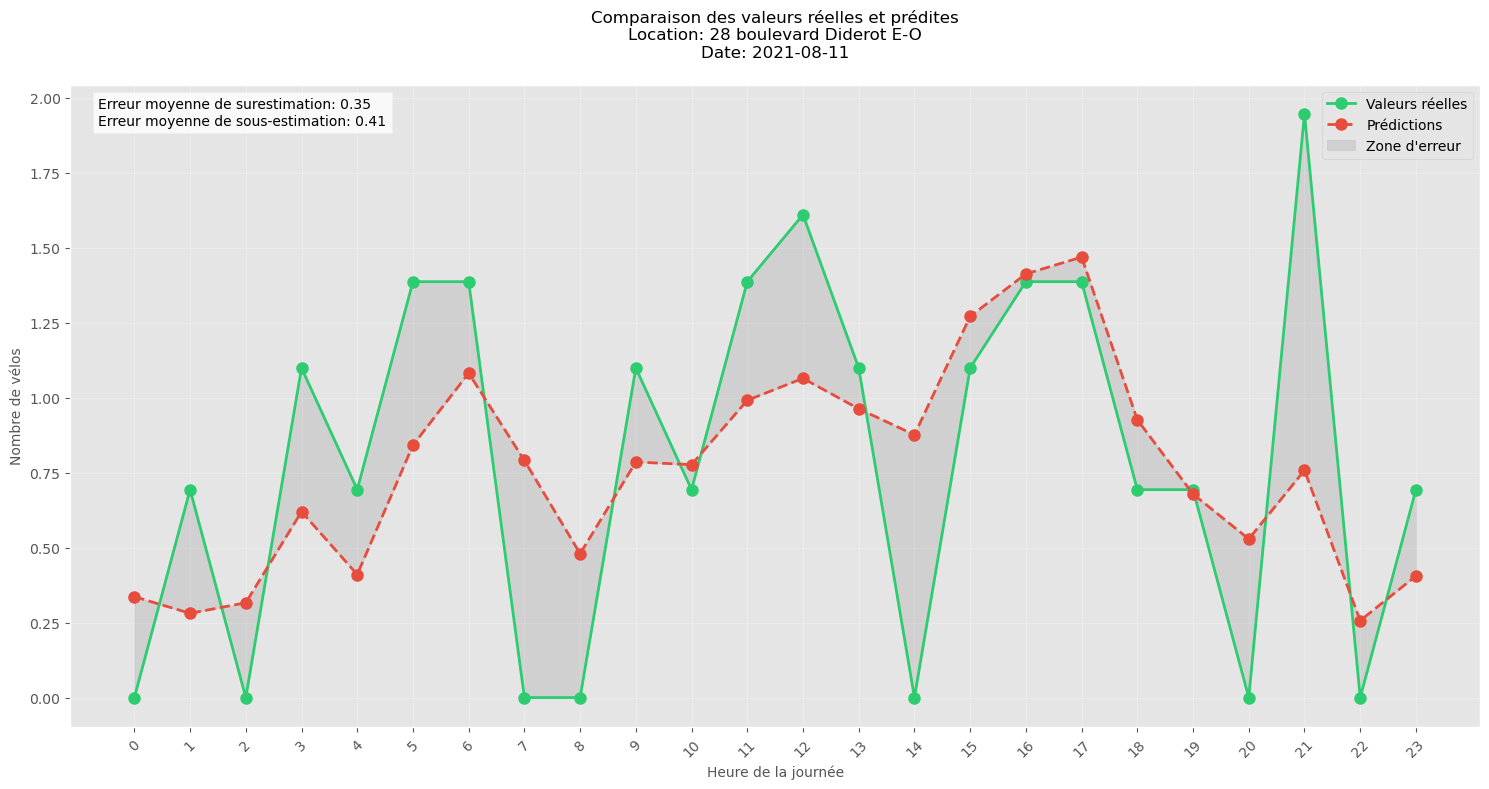

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrer les données pour le capteur spécifique
location = "28 boulevard Diderot E-O"
loc_data = error_df[error_df['counter_name'] == location].copy()

# Choisir une journée spécifique (prendre la première date disponible)
sample_date = loc_data['datetime'].dt.date.unique()[0]
day_data = loc_data[loc_data['datetime'].dt.date == sample_date].copy()

# Trier par heure pour avoir une ligne continue
day_data = day_data.sort_values('datetime')

# Créer la visualisation
plt.figure(figsize=(15, 8))

# Tracer les deux lignes
plt.plot(day_data['hour'], day_data['actual'], 
         label='Valeurs réelles', 
         marker='o', 
         color='#2ecc71', 
         linewidth=2)
plt.plot(day_data['hour'], day_data['predicted'], 
         label='Prédictions', 
         marker='o', 
         color='#e74c3c', 
         linewidth=2, 
         linestyle='--')

# Ajouter les zones d'erreur
plt.fill_between(day_data['hour'], 
                 day_data['actual'], 
                 day_data['predicted'], 
                 alpha=0.2, 
                 color='gray', 
                 label='Zone d\'erreur')

# Personnaliser le graphique
plt.title(f'Comparaison des valeurs réelles et prédites\nLocation: {location}\nDate: {sample_date}', 
          fontsize=12, pad=20)
plt.xlabel('Heure de la journée', fontsize=10)
plt.ylabel('Nombre de vélos', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

# Ajuster les ticks de l'axe x pour montrer toutes les heures
plt.xticks(range(0, 24), rotation=45)

# Calculer l'erreur moyenne de surestimation et sous-estimation
overestimation = day_data[day_data['predicted'] > day_data['actual']]
underestimation = day_data[day_data['predicted'] < day_data['actual']]

over_mean = (overestimation['predicted'] - overestimation['actual']).mean()
under_mean = (underestimation['actual'] - underestimation['predicted']).mean()

# Ajouter un texte explicatif
plt.text(0.02, 0.98, 
         f'Erreur moyenne de surestimation: {over_mean:.2f}\n'
         f'Erreur moyenne de sous-estimation: {under_mean:.2f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

In [121]:
# Filter the dataframe for "28 Boulevard Diderot" on "2021-08-11"
filtered_df = data[(data['counter_name'] == '28 boulevard Diderot E-O') & (data['date'].dt.date == datetime.date(2021, 8, 11))][['hour', 'bike_count', 'counter_name']]
print(filtered_df)

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_56300/1706533726.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_5_locations = error_df.groupby('site_name')['absolute_error'].mean().nlargest(5)



Top 5 Locations with Highest Average Errors:
site_name
28 boulevard Diderot                        1.200230
90 Rue De Sèvres                            0.543741
Face au 70 quai de Bercy                    0.488326
Face au 4 avenue de la porte de Bagnolet    0.410193
Totem Cours la Reine                        0.409415
Name: absolute_error, dtype: float64


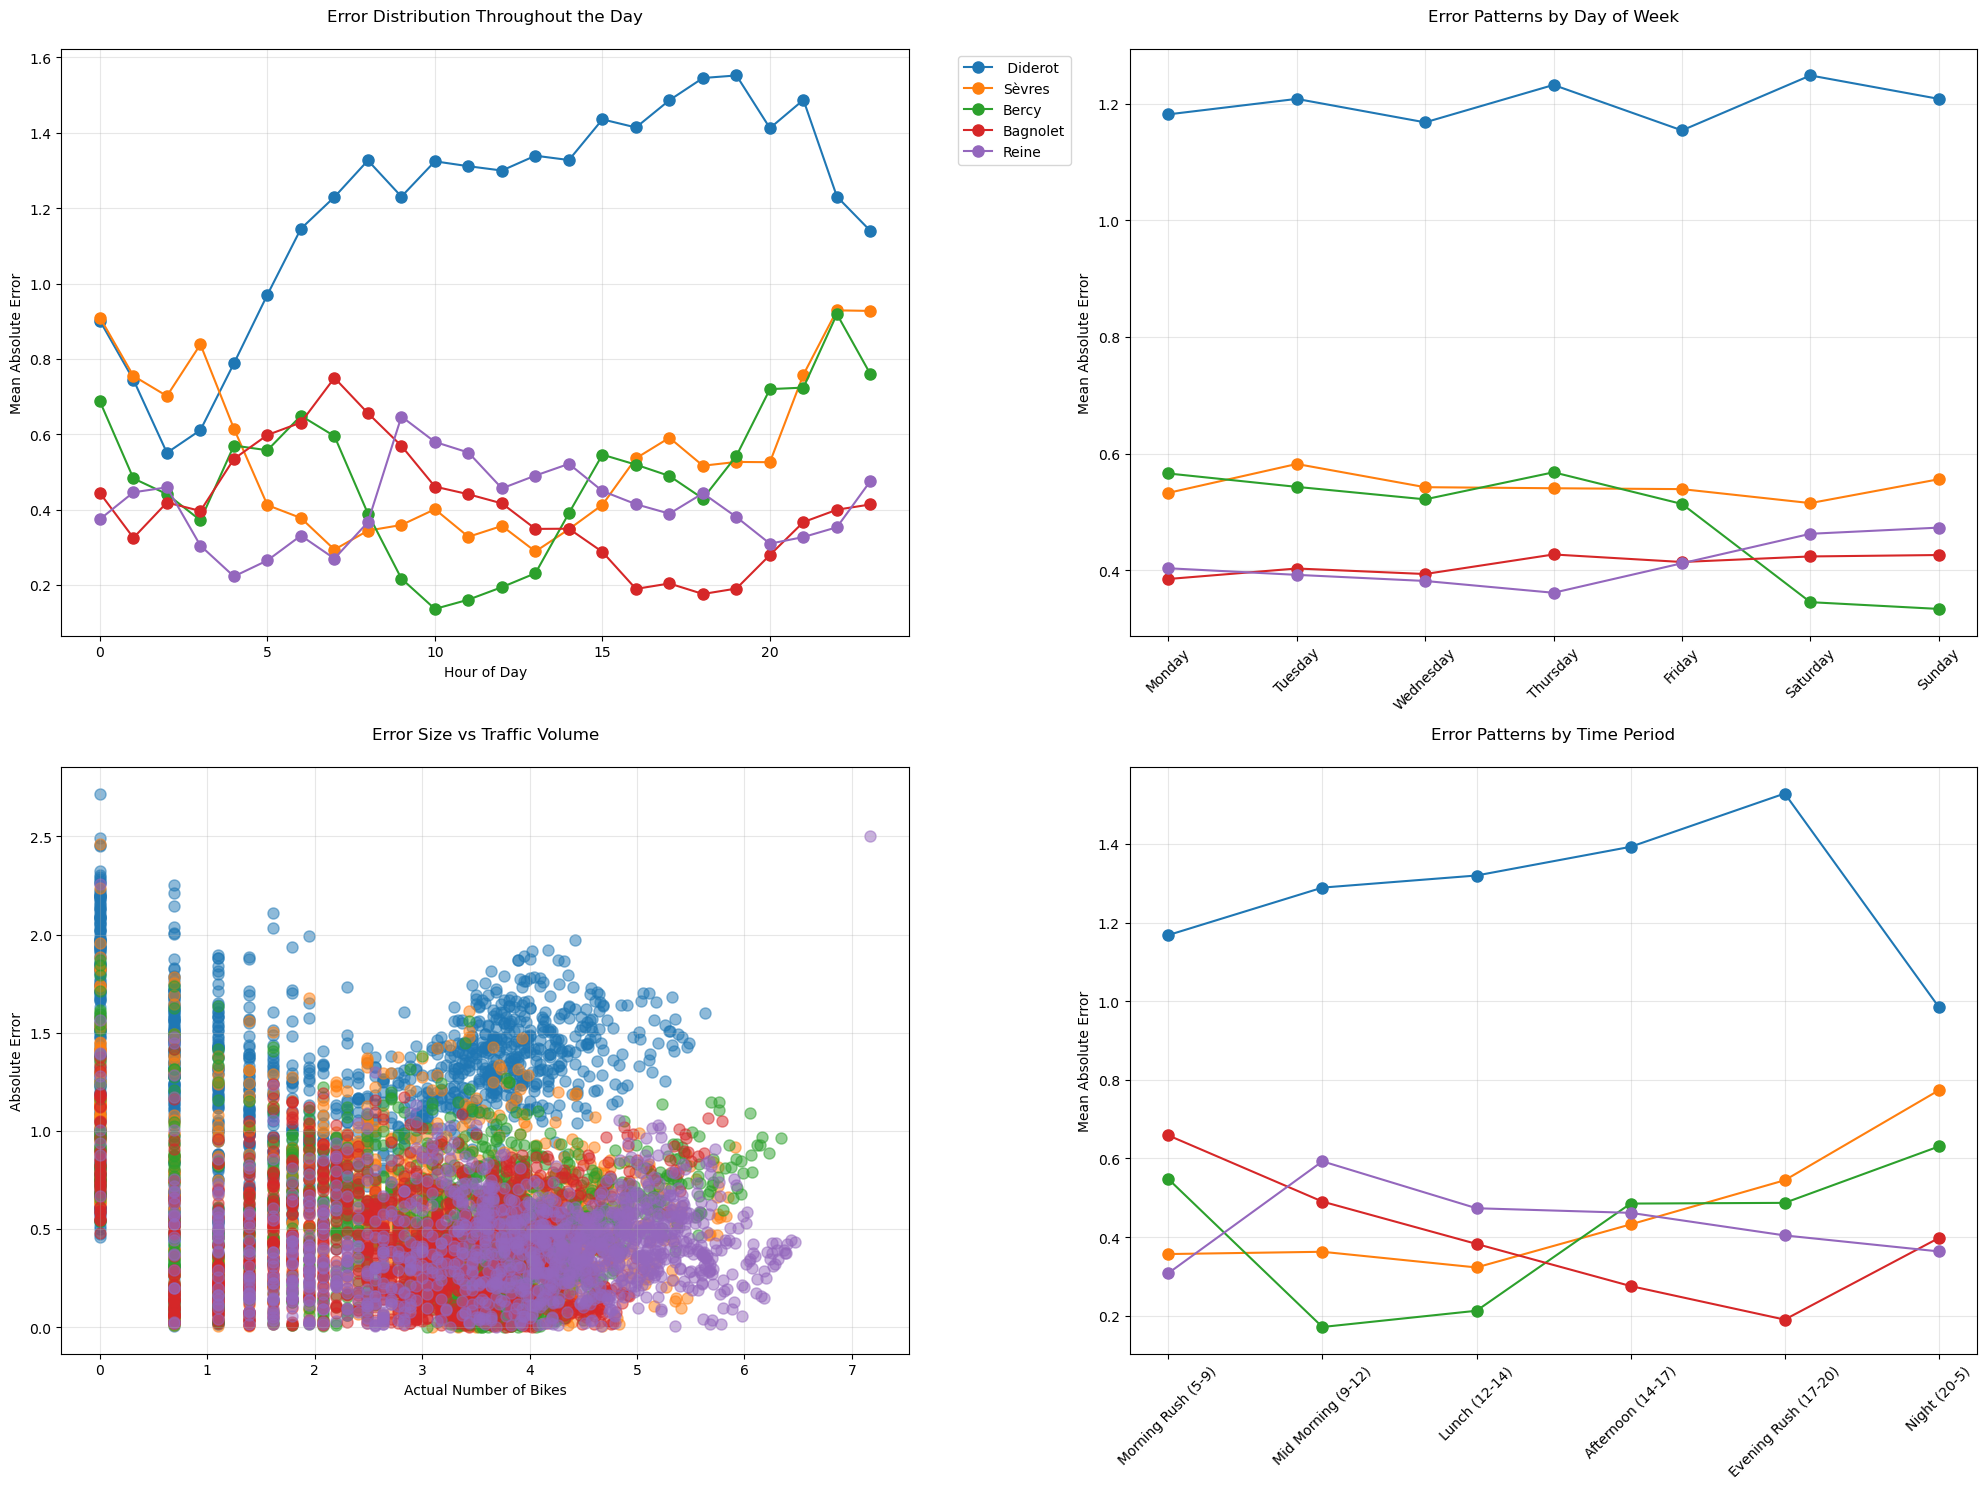


Detailed Analysis for Each Location:


Location: 28 boulevard Diderot

Performance by Time Period:
                     absolute_error       actual
                               mean count   mean
time_period                                     
Afternoon (14-17)              1.39   180   2.96
Evening Rush (17-20)           1.53   180   2.64
Lunch (12-14)                  1.32   120   2.48
Mid Morning (9-12)             1.29   180   2.38
Morning Rush (5-9)             1.17   240   2.30
Night (20-5)                   0.99   540   1.38

Weekday vs Weekend Performance:
        absolute_error       actual
                  mean   std   mean
Weekday           1.19  0.45   2.17
Weekend           1.23  0.43   1.94

Top 5 Largest Errors:
                datetime  actual  predicted  absolute_error
7909 2021-08-12 17:00:00     0.0       2.72            2.72
8168 2021-08-17 18:00:00     0.0       2.49            2.49
8294 2021-08-22 16:00:00     0.0       2.45            2.45
8871 2021-08-26 18:

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# First, let's create our analysis DataFrame with all the information we need
error_df = pd.DataFrame({
    'datetime': X_valid['date'],
    'site_name': X_valid['site_name'],
    'actual': y_valid,
    'predicted': y_valid_pred,
    'absolute_error': np.abs(y_valid - y_valid_pred)
})

# Adding time-based features that will help us understand error patterns
error_df['hour'] = error_df['datetime'].dt.hour
error_df['day_of_week'] = error_df['datetime'].dt.day_name()
error_df['is_weekend'] = error_df['datetime'].dt.weekday >= 5
error_df['month'] = error_df['datetime'].dt.month

# Define meaningful time periods for our analysis
def get_time_period(hour):
    if 5 <= hour < 9: return 'Morning Rush (5-9)'
    elif 9 <= hour < 12: return 'Mid Morning (9-12)'
    elif 12 <= hour < 14: return 'Lunch (12-14)'
    elif 14 <= hour < 17: return 'Afternoon (14-17)'
    elif 17 <= hour < 20: return 'Evening Rush (17-20)'
    else: return 'Night (20-5)'

error_df['time_period'] = error_df['hour'].apply(get_time_period)

# Identify our top 5 locations with highest errors
top_5_locations = error_df.groupby('site_name')['absolute_error'].mean().nlargest(5)
print("\nTop 5 Locations with Highest Average Errors:")
print(top_5_locations)

# Set up the figure for our visualizations
fig = plt.figure(figsize=(20, 15))
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.markersize'] = 8

# Let's create four informative subplots
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Default matplotlib color cycle

# 1. Hourly Error Analysis
plt.subplot(2, 2, 1)
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    hourly_errors = loc_data.groupby('hour')['absolute_error'].mean()
    plt.plot(hourly_errors.index, hourly_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Distribution Throughout the Day', fontsize=12, pad=20)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 2. Day of Week Analysis
plt.subplot(2, 2, 2)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    daily_errors = loc_data.groupby('day_of_week')['absolute_error'].mean()
    daily_errors = daily_errors.reindex(days)
    plt.plot(range(len(days)), daily_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Patterns by Day of Week', fontsize=12, pad=20)
plt.xticks(range(len(days)), days, rotation=45)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Error vs Traffic Volume
plt.subplot(2, 2, 3)
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    plt.scatter(loc_data['actual'], loc_data['absolute_error'], 
               label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
               color=colors[idx], alpha=0.5)

plt.title('Error Size vs Traffic Volume', fontsize=12, pad=20)
plt.xlabel('Actual Number of Bikes', fontsize=10)
plt.ylabel('Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Time Period Analysis
plt.subplot(2, 2, 4)
time_periods = ['Morning Rush (5-9)', 'Mid Morning (9-12)', 'Lunch (12-14)', 
                'Afternoon (14-17)', 'Evening Rush (17-20)', 'Night (20-5)']
for idx, location in enumerate(top_5_locations.index):
    loc_data = error_df[error_df['site_name'] == location]
    period_errors = loc_data.groupby('time_period')['absolute_error'].mean()
    period_errors = period_errors.reindex(time_periods)
    plt.plot(range(len(time_periods)), period_errors.values, 
             label=location.split('boulevard')[-1] if 'boulevard' in location else location.split(' ')[-1],
             color=colors[idx], marker='o')

plt.title('Error Patterns by Time Period', fontsize=12, pad=20)
plt.xticks(range(len(time_periods)), time_periods, rotation=45)
plt.ylabel('Mean Absolute Error', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed statistical analysis for each problematic counter
print("\nDetailed Analysis for Each Location:")
for location in top_5_locations.index:
    print(f"\n{'='*80}")
    print(f"\nLocation: {location}")
    loc_data = error_df[error_df['site_name'] == location]
    
    # Time period statistics
    print("\nPerformance by Time Period:")
    time_stats = loc_data.groupby('time_period').agg({
        'absolute_error': ['mean', 'count'],
        'actual': 'mean',
    }).round(2)
    print(time_stats)
    
    # Weekend vs Weekday performance
    print("\nWeekday vs Weekend Performance:")
    day_type_stats = loc_data.groupby('is_weekend').agg({
        'absolute_error': ['mean', 'std'],
        'actual': 'mean'
    }).round(2)
    day_type_stats.index = ['Weekday', 'Weekend']
    print(day_type_stats)
    
    # Worst predictions
    print("\nTop 5 Largest Errors:")
    worst_predictions = loc_data.nlargest(5, 'absolute_error')[
        ['datetime', 'actual', 'predicted', 'absolute_error']
    ].round(2)
    print(worst_predictions)

# 6. Hyperparameter Finetuning

### Using Optuna

#### On Light Tree

[I 2024-12-10 20:40:43,752] A new study created in memory with name: no-name-9ef66737-a05d-467d-a798-781441b90b3e
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.6191398568831261, colsample_bytree=0.6205333789457095 will be ignored. Current value: feature_fraction=0.6191398568831261
[LightGBM] [Warning] feature_fraction is set=0.6191398568831261, colsample_bytree=0.6205333789457095 will be ignored. Current value: feature_fraction=0.6191398568831261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 40
[LightGBM] [Info] Start training from score 3.048868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.529281:   2%|▏         | 1/50 [00:02<02:15,  2.77s/it]

[I 2024-12-10 20:40:46,523] Trial 0 finished with value: 0.529280555772412 and parameters: {'n_estimators': 312, 'max_depth': 20, 'learning_rate': 0.1727025166862704, 'num_leaves': 43, 'min_child_samples': 18, 'subsample': 0.8286042882061487, 'colsample_bytree': 0.6205333789457095, 'reg_alpha': 7.983091355591921e-05, 'reg_lambda': 0.011788003319629207, 'min_split_gain': 0.4564879311371374, 'feature_fraction': 0.6191398568831261}. Best is trial 0 with value: 0.529280555772412.
[LightGBM] [Warning] feature_fraction is set=0.8434820962298111, colsample_bytree=0.8168856531885428 will be ignored. Current value: feature_fraction=0.8434820962298111
[LightGBM] [Warning] feature_fraction is set=0.8434820962298111, colsample_bytree=0.8168856531885428 will be ignored. Current value: feature_fraction=0.8434820962298111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.529281:   4%|▍         | 2/50 [00:07<03:03,  3.83s/it]

[I 2024-12-10 20:40:51,098] Trial 1 finished with value: 0.5373795025147373 and parameters: {'n_estimators': 382, 'max_depth': 25, 'learning_rate': 0.026006285731375464, 'num_leaves': 42, 'min_child_samples': 30, 'subsample': 0.5234431806852631, 'colsample_bytree': 0.8168856531885428, 'reg_alpha': 0.00022973433487115424, 'reg_lambda': 0.7429054502907289, 'min_split_gain': 0.24965359517907293, 'feature_fraction': 0.8434820962298111}. Best is trial 0 with value: 0.529280555772412.
[LightGBM] [Warning] feature_fraction is set=0.8283385104112498, colsample_bytree=0.8450423861570278 will be ignored. Current value: feature_fraction=0.8283385104112498
[LightGBM] [Warning] feature_fraction is set=0.8283385104112498, colsample_bytree=0.8450423861570278 will be ignored. Current value: feature_fraction=0.8283385104112498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.529281:   6%|▌         | 3/50 [00:10<02:54,  3.71s/it]

[LightGBM] [Warning] feature_fraction is set=0.8283385104112498, colsample_bytree=0.8450423861570278 will be ignored. Current value: feature_fraction=0.8283385104112498
[I 2024-12-10 20:40:54,664] Trial 2 finished with value: 0.6112918360698577 and parameters: {'n_estimators': 214, 'max_depth': 25, 'learning_rate': 0.01614313526711522, 'num_leaves': 51, 'min_child_samples': 9, 'subsample': 0.7506275992807786, 'colsample_bytree': 0.8450423861570278, 'reg_alpha': 0.20276186529497495, 'reg_lambda': 8.75904192967638e-07, 'min_split_gain': 0.017364365247044378, 'feature_fraction': 0.8283385104112498}. Best is trial 0 with value: 0.529280555772412.
[LightGBM] [Warning] feature_fraction is set=0.9020668280874675, colsample_bytree=0.5573347228123643 will be ignored. Current value: feature_fraction=0.9020668280874675
[LightGBM] [Warning] feature_fraction is set=0.9020668280874675, colsample_bytree=0.5573347228123643 will be ignored. Current value: feature_fraction=0.9020668280874675
[LightGBM] 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.529281:   8%|▊         | 4/50 [00:14<02:40,  3.50s/it]

[LightGBM] [Warning] feature_fraction is set=0.9020668280874675, colsample_bytree=0.5573347228123643 will be ignored. Current value: feature_fraction=0.9020668280874675
[I 2024-12-10 20:40:57,838] Trial 3 finished with value: 0.5309368690838996 and parameters: {'n_estimators': 231, 'max_depth': 24, 'learning_rate': 0.21158979894174898, 'num_leaves': 96, 'min_child_samples': 21, 'subsample': 0.8242924288299623, 'colsample_bytree': 0.5573347228123643, 'reg_alpha': 1.4263436015633959e-07, 'reg_lambda': 8.665702787026062e-05, 'min_split_gain': 0.017877314525896193, 'feature_fraction': 0.9020668280874675}. Best is trial 0 with value: 0.529280555772412.
[LightGBM] [Warning] feature_fraction is set=0.5807442358669683, colsample_bytree=0.6780682691025063 will be ignored. Current value: feature_fraction=0.5807442358669683
[LightGBM] [Warning] feature_fraction is set=0.5807442358669683, colsample_bytree=0.6780682691025063 will be ignored. Current value: feature_fraction=0.5807442358669683
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  10%|█         | 5/50 [00:17<02:32,  3.38s/it]

[LightGBM] [Warning] feature_fraction is set=0.5807442358669683, colsample_bytree=0.6780682691025063 will be ignored. Current value: feature_fraction=0.5807442358669683
[I 2024-12-10 20:41:01,021] Trial 4 finished with value: 0.5287364053194729 and parameters: {'n_estimators': 281, 'max_depth': 19, 'learning_rate': 0.27959833489679986, 'num_leaves': 51, 'min_child_samples': 25, 'subsample': 0.8410175173162887, 'colsample_bytree': 0.6780682691025063, 'reg_alpha': 0.004414666887184243, 'reg_lambda': 2.0265710436360166e-06, 'min_split_gain': 0.04364043073299628, 'feature_fraction': 0.5807442358669683}. Best is trial 4 with value: 0.5287364053194729.
[LightGBM] [Warning] feature_fraction is set=0.6549208802985651, colsample_bytree=0.7833922299237238 will be ignored. Current value: feature_fraction=0.6549208802985651
[LightGBM] [Warning] feature_fraction is set=0.6549208802985651, colsample_bytree=0.7833922299237238 will be ignored. Current value: feature_fraction=0.6549208802985651
[LightG

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  12%|█▏        | 6/50 [00:21<02:34,  3.51s/it]

[LightGBM] [Warning] feature_fraction is set=0.6549208802985651, colsample_bytree=0.7833922299237238 will be ignored. Current value: feature_fraction=0.6549208802985651
[I 2024-12-10 20:41:04,767] Trial 5 finished with value: 0.6267501602103422 and parameters: {'n_estimators': 244, 'max_depth': 15, 'learning_rate': 0.01484620827350008, 'num_leaves': 38, 'min_child_samples': 19, 'subsample': 0.7623730136182434, 'colsample_bytree': 0.7833922299237238, 'reg_alpha': 5.936780694928896e-06, 'reg_lambda': 0.00010121654579027474, 'min_split_gain': 0.07371249133954227, 'feature_fraction': 0.6549208802985651}. Best is trial 4 with value: 0.5287364053194729.
[LightGBM] [Warning] feature_fraction is set=0.5700026216569082, colsample_bytree=0.731969735477271 will be ignored. Current value: feature_fraction=0.5700026216569082
[LightGBM] [Warning] feature_fraction is set=0.5700026216569082, colsample_bytree=0.731969735477271 will be ignored. Current value: feature_fraction=0.5700026216569082
[LightGB

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  14%|█▍        | 7/50 [00:24<02:31,  3.53s/it]

[LightGBM] [Warning] feature_fraction is set=0.5700026216569082, colsample_bytree=0.731969735477271 will be ignored. Current value: feature_fraction=0.5700026216569082
[I 2024-12-10 20:41:08,356] Trial 6 finished with value: 0.5485666328018517 and parameters: {'n_estimators': 239, 'max_depth': 22, 'learning_rate': 0.03346217593120076, 'num_leaves': 36, 'min_child_samples': 22, 'subsample': 0.8206482050629343, 'colsample_bytree': 0.731969735477271, 'reg_alpha': 0.09850591271267506, 'reg_lambda': 8.816224943569973e-06, 'min_split_gain': 0.12059921971492582, 'feature_fraction': 0.5700026216569082}. Best is trial 4 with value: 0.5287364053194729.
[LightGBM] [Warning] feature_fraction is set=0.8864781266570085, colsample_bytree=0.5336826002366277 will be ignored. Current value: feature_fraction=0.8864781266570085
[LightGBM] [Warning] feature_fraction is set=0.8864781266570085, colsample_bytree=0.5336826002366277 will be ignored. Current value: feature_fraction=0.8864781266570085
[LightGBM] 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  16%|█▌        | 8/50 [00:27<02:15,  3.23s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  18%|█▊        | 9/50 [00:28<01:54,  2.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 4. Best value: 0.528736:  20%|██        | 10/50 [00:31<01:49,  2.73s/it]

[I 2024-12-10 20:41:15,351] Trial 9 finished with value: 0.5396387822301705 and parameters: {'n_estimators': 339, 'max_depth': 25, 'learning_rate': 0.27834759348643984, 'num_leaves': 25, 'min_child_samples': 29, 'subsample': 0.5377366571146451, 'colsample_bytree': 0.570161795429532, 'reg_alpha': 1.06993429175856e-05, 'reg_lambda': 0.7624861344688248, 'min_split_gain': 0.4066975989480157, 'feature_fraction': 0.5927291203696665}. Best is trial 4 with value: 0.5287364053194729.
[LightGBM] [Warning] feature_fraction is set=0.7215963304859734, colsample_bytree=0.6504936151883179 will be ignored. Current value: feature_fraction=0.7215963304859734
[LightGBM] [Warning] feature_fraction is set=0.7215963304859734, colsample_bytree=0.6504936151883179 will be ignored. Current value: feature_fraction=0.7215963304859734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 10. Best value: 0.528698:  22%|██▏       | 11/50 [00:36<02:08,  3.29s/it]

[LightGBM] [Warning] feature_fraction is set=0.7215963304859734, colsample_bytree=0.6504936151883179 will be ignored. Current value: feature_fraction=0.7215963304859734
[I 2024-12-10 20:41:19,895] Trial 10 finished with value: 0.528697867973166 and parameters: {'n_estimators': 282, 'max_depth': 17, 'learning_rate': 0.05004886680561046, 'num_leaves': 68, 'min_child_samples': 26, 'subsample': 0.88998382994021, 'colsample_bytree': 0.6504936151883179, 'reg_alpha': 0.00871566415770212, 'reg_lambda': 1.1049727414154321e-08, 'min_split_gain': 0.20041867706646083, 'feature_fraction': 0.7215963304859734}. Best is trial 10 with value: 0.528697867973166.
[LightGBM] [Warning] feature_fraction is set=0.7241271245618632, colsample_bytree=0.6606013618195473 will be ignored. Current value: feature_fraction=0.7241271245618632
[LightGBM] [Warning] feature_fraction is set=0.7241271245618632, colsample_bytree=0.6606013618195473 will be ignored. Current value: feature_fraction=0.7241271245618632
[LightGBM]

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 11. Best value: 0.528028:  24%|██▍       | 12/50 [00:40<02:18,  3.65s/it]

[LightGBM] [Warning] feature_fraction is set=0.7241271245618632, colsample_bytree=0.6606013618195473 will be ignored. Current value: feature_fraction=0.7241271245618632
[I 2024-12-10 20:41:24,365] Trial 11 finished with value: 0.5280284299092841 and parameters: {'n_estimators': 281, 'max_depth': 17, 'learning_rate': 0.0647043312162971, 'num_leaves': 69, 'min_child_samples': 25, 'subsample': 0.8999902456715426, 'colsample_bytree': 0.6606013618195473, 'reg_alpha': 0.009287415464642275, 'reg_lambda': 1.0397878390057869e-08, 'min_split_gain': 0.2067074433651343, 'feature_fraction': 0.7241271245618632}. Best is trial 11 with value: 0.5280284299092841.
[LightGBM] [Warning] feature_fraction is set=0.7359365120341135, colsample_bytree=0.6598463292552587 will be ignored. Current value: feature_fraction=0.7359365120341135
[LightGBM] [Warning] feature_fraction is set=0.7359365120341135, colsample_bytree=0.6598463292552587 will be ignored. Current value: feature_fraction=0.7359365120341135
[LightG

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  26%|██▌       | 13/50 [00:44<02:19,  3.77s/it]

[LightGBM] [Warning] feature_fraction is set=0.7359365120341135, colsample_bytree=0.6598463292552587 will be ignored. Current value: feature_fraction=0.7359365120341135
[I 2024-12-10 20:41:28,436] Trial 12 finished with value: 0.5246357249294011 and parameters: {'n_estimators': 281, 'max_depth': 17, 'learning_rate': 0.06113549422144369, 'num_leaves': 72, 'min_child_samples': 26, 'subsample': 0.8976936725426151, 'colsample_bytree': 0.6598463292552587, 'reg_alpha': 0.019715949862773516, 'reg_lambda': 2.0369636852398017e-08, 'min_split_gain': 0.2017279281206415, 'feature_fraction': 0.7359365120341135}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.7531182998171596, colsample_bytree=0.7458450459768109 will be ignored. Current value: feature_fraction=0.7531182998171596
[LightGBM] [Warning] feature_fraction is set=0.7531182998171596, colsample_bytree=0.7458450459768109 will be ignored. Current value: feature_fraction=0.7531182998171596
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  28%|██▊       | 14/50 [00:48<02:18,  3.85s/it]

[LightGBM] [Warning] feature_fraction is set=0.7531182998171596, colsample_bytree=0.7458450459768109 will be ignored. Current value: feature_fraction=0.7531182998171596
[I 2024-12-10 20:41:32,445] Trial 13 finished with value: 0.5248120623004906 and parameters: {'n_estimators': 269, 'max_depth': 17, 'learning_rate': 0.08062391876265843, 'num_leaves': 79, 'min_child_samples': 14, 'subsample': 0.8936776640370435, 'colsample_bytree': 0.7458450459768109, 'reg_alpha': 0.8718573481149033, 'reg_lambda': 1.3788253336115498e-08, 'min_split_gain': 0.17150707637430987, 'feature_fraction': 0.7531182998171596}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.7845835684758041, colsample_bytree=0.733894162445648 will be ignored. Current value: feature_fraction=0.7845835684758041
[LightGBM] [Warning] feature_fraction is set=0.7845835684758041, colsample_bytree=0.733894162445648 will be ignored. Current value: feature_fraction=0.7845835684758041
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  30%|███       | 15/50 [00:52<02:13,  3.82s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] feature_fraction is set=0.7845835684758041, colsample_bytree=0.733894162445648 will 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  32%|███▏      | 16/50 [00:55<02:01,  3.58s/it]

[I 2024-12-10 20:41:39,239] Trial 15 finished with value: 0.5273691375675551 and parameters: {'n_estimators': 265, 'max_depth': 17, 'learning_rate': 0.10335272230872505, 'num_leaves': 83, 'min_child_samples': 14, 'subsample': 0.7683828946176057, 'colsample_bytree': 0.8961016236343443, 'reg_alpha': 0.07680288390848529, 'reg_lambda': 0.0038556310729795876, 'min_split_gain': 0.334634734027755, 'feature_fraction': 0.9995348800497483}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.5178925846566753, colsample_bytree=0.7238603900962983 will be ignored. Current value: feature_fraction=0.5178925846566753
[LightGBM] [Warning] feature_fraction is set=0.5178925846566753, colsample_bytree=0.7238603900962983 will be ignored. Current value: feature_fraction=0.5178925846566753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  34%|███▍      | 17/50 [01:00<02:11,  3.97s/it]

[LightGBM] [Warning] feature_fraction is set=0.5178925846566753, colsample_bytree=0.7238603900962983 will be ignored. Current value: feature_fraction=0.5178925846566753
[I 2024-12-10 20:41:44,105] Trial 16 finished with value: 0.5292371490373575 and parameters: {'n_estimators': 205, 'max_depth': 18, 'learning_rate': 0.09794988965202658, 'num_leaves': 83, 'min_child_samples': 7, 'subsample': 0.8684859127563167, 'colsample_bytree': 0.7238603900962983, 'reg_alpha': 0.9241540129733157, 'reg_lambda': 1.811604463444957e-07, 'min_split_gain': 0.30423000009434553, 'feature_fraction': 0.5178925846566753}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.6754058925762311, colsample_bytree=0.6033305959396302 will be ignored. Current value: feature_fraction=0.6754058925762311
[LightGBM] [Warning] feature_fraction is set=0.6754058925762311, colsample_bytree=0.6033305959396302 will be ignored. Current value: feature_fraction=0.6754058925762311
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  36%|███▌      | 18/50 [01:04<02:12,  4.14s/it]

[LightGBM] [Warning] feature_fraction is set=0.6754058925762311, colsample_bytree=0.6033305959396302 will be ignored. Current value: feature_fraction=0.6754058925762311
[I 2024-12-10 20:41:48,625] Trial 17 finished with value: 0.5255671789135262 and parameters: {'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.04534207830539959, 'num_leaves': 98, 'min_child_samples': 15, 'subsample': 0.801924711155748, 'colsample_bytree': 0.6033305959396302, 'reg_alpha': 0.04076191876953541, 'reg_lambda': 7.802722174375202e-08, 'min_split_gain': 0.14534912560075958, 'feature_fraction': 0.6754058925762311}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.7758228138646813, colsample_bytree=0.50260484360075 will be ignored. Current value: feature_fraction=0.7758228138646813
[LightGBM] [Warning] feature_fraction is set=0.7758228138646813, colsample_bytree=0.50260484360075 will be ignored. Current value: feature_fraction=0.7758228138646813
[LightGBM] [

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 12. Best value: 0.524636:  38%|███▊      | 19/50 [01:09<02:15,  4.35s/it]

[I 2024-12-10 20:41:53,491] Trial 18 finished with value: 0.5371985817389747 and parameters: {'n_estimators': 320, 'max_depth': 18, 'learning_rate': 0.022041874325642856, 'num_leaves': 60, 'min_child_samples': 5, 'subsample': 0.6021513261538963, 'colsample_bytree': 0.50260484360075, 'reg_alpha': 3.01656681112205e-08, 'reg_lambda': 0.0017192545373625949, 'min_split_gain': 0.2715383563073945, 'feature_fraction': 0.7758228138646813}. Best is trial 12 with value: 0.5246357249294011.
[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  40%|████      | 20/50 [01:15<02:20,  4.69s/it]

[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[I 2024-12-10 20:41:58,949] Trial 19 finished with value: 0.5234658705758604 and parameters: {'n_estimators': 400, 'max_depth': 19, 'learning_rate': 0.06712611800300208, 'num_leaves': 77, 'min_child_samples': 22, 'subsample': 0.7130875238363391, 'colsample_bytree': 0.7734618286435317, 'reg_alpha': 0.021207431044913207, 'reg_lambda': 9.721299244798047e-07, 'min_split_gain': 0.10638810928669196, 'feature_fraction': 0.7041292223250113}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.682301792635102, colsample_bytree=0.7796818836422493 will be ignored. Current value: feature_fraction=0.682301792635102
[LightGBM] [Warning] feature_fraction is set=0.682301792635102, colsample_bytree=0.7796818836422493 will be ignored. Current value: feature_fraction=0.682301792635102
[LightGBM]

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  42%|████▏     | 21/50 [01:18<02:07,  4.41s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] feature_fraction is set=0.682301792635102, colsample_bytree=0.7796818836422493 will be ignored. Current value: feature_fraction=0.682301792635102
[I 2024-12-10 20:42:02,720] Trial 20 finished with value: 0.5292869754391605 and parameters: {'n_estimators': 397, 'm

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  44%|████▍     | 22/50 [01:23<02:03,  4.42s/it]

[I 2024-12-10 20:42:07,171] Trial 21 finished with value: 0.5270238910175568 and parameters: {'n_estimators': 292, 'max_depth': 19, 'learning_rate': 0.06596839074109977, 'num_leaves': 77, 'min_child_samples': 27, 'subsample': 0.860396562357541, 'colsample_bytree': 0.7013260262876982, 'reg_alpha': 0.013336094847948005, 'reg_lambda': 2.3225980632169106e-08, 'min_split_gain': 0.18874755735673215, 'feature_fraction': 0.740060296213776}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8083914473204101, colsample_bytree=0.7625753771813423 will be ignored. Current value: feature_fraction=0.8083914473204101
[LightGBM] [Warning] feature_fraction is set=0.8083914473204101, colsample_bytree=0.7625753771813423 will be ignored. Current value: feature_fraction=0.8083914473204101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  46%|████▌     | 23/50 [01:27<01:56,  4.31s/it]

[LightGBM] [Warning] feature_fraction is set=0.8083914473204101, colsample_bytree=0.7625753771813423 will be ignored. Current value: feature_fraction=0.8083914473204101
[I 2024-12-10 20:42:11,219] Trial 22 finished with value: 0.5246415844644278 and parameters: {'n_estimators': 261, 'max_depth': 16, 'learning_rate': 0.07340763628232123, 'num_leaves': 92, 'min_child_samples': 23, 'subsample': 0.5701903477299787, 'colsample_bytree': 0.7625753771813423, 'reg_alpha': 0.0015762834840554046, 'reg_lambda': 4.1586436287441627e-07, 'min_split_gain': 0.1648115057903774, 'feature_fraction': 0.8083914473204101}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8054189131316678, colsample_bytree=0.7773920715321301 will be ignored. Current value: feature_fraction=0.8054189131316678
[LightGBM] [Warning] feature_fraction is set=0.8054189131316678, colsample_bytree=0.7773920715321301 will be ignored. Current value: feature_fraction=0.8054189131316678
[Ligh

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  48%|████▊     | 24/50 [01:33<02:04,  4.80s/it]

[I 2024-12-10 20:42:17,166] Trial 23 finished with value: 0.5255689937706192 and parameters: {'n_estimators': 368, 'max_depth': 16, 'learning_rate': 0.03280558051466811, 'num_leaves': 91, 'min_child_samples': 23, 'subsample': 0.5510897942125212, 'colsample_bytree': 0.7773920715321301, 'reg_alpha': 0.0010827384357697178, 'reg_lambda': 5.155406453733517e-07, 'min_split_gain': 0.07178021882997121, 'feature_fraction': 0.8054189131316678}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8582921034058425, colsample_bytree=0.8496104788706098 will be ignored. Current value: feature_fraction=0.8582921034058425
[LightGBM] [Warning] feature_fraction is set=0.8582921034058425, colsample_bytree=0.8496104788706098 will be ignored. Current value: feature_fraction=0.8582921034058425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  50%|█████     | 25/50 [01:39<02:08,  5.15s/it]

[I 2024-12-10 20:42:23,144] Trial 24 finished with value: 0.5730177145805131 and parameters: {'n_estimators': 330, 'max_depth': 19, 'learning_rate': 0.010726784369842313, 'num_leaves': 92, 'min_child_samples': 20, 'subsample': 0.5811722371253575, 'colsample_bytree': 0.8496104788706098, 'reg_alpha': 0.0015949718548603207, 'reg_lambda': 5.7832169625692784e-06, 'min_split_gain': 0.23846689798425547, 'feature_fraction': 0.8582921034058425}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6506574276424824, colsample_bytree=0.6972077610602243 will be ignored. Current value: feature_fraction=0.6506574276424824
[LightGBM] [Warning] feature_fraction is set=0.6506574276424824, colsample_bytree=0.6972077610602243 will be ignored. Current value: feature_fraction=0.6506574276424824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  52%|█████▏    | 26/50 [01:45<02:08,  5.36s/it]

[I 2024-12-10 20:42:28,978] Trial 25 finished with value: 0.5273437991941978 and parameters: {'n_estimators': 297, 'max_depth': 16, 'learning_rate': 0.04451929774578304, 'num_leaves': 73, 'min_child_samples': 28, 'subsample': 0.6583205240188128, 'colsample_bytree': 0.6972077610602243, 'reg_alpha': 0.02896892475674222, 'reg_lambda': 8.156060189039101e-08, 'min_split_gain': 0.11871388788968235, 'feature_fraction': 0.6506574276424824}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.700860100610232, colsample_bytree=0.6324219832023333 will be ignored. Current value: feature_fraction=0.700860100610232
[LightGBM] [Warning] feature_fraction is set=0.700860100610232, colsample_bytree=0.6324219832023333 will be ignored. Current value: feature_fraction=0.700860100610232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  54%|█████▍    | 27/50 [01:48<01:49,  4.76s/it]

[LightGBM] [Warning] feature_fraction is set=0.700860100610232, colsample_bytree=0.6324219832023333 will be ignored. Current value: feature_fraction=0.700860100610232
[I 2024-12-10 20:42:32,336] Trial 26 finished with value: 0.5264135752558324 and parameters: {'n_estimators': 221, 'max_depth': 18, 'learning_rate': 0.12791424053000713, 'num_leaves': 89, 'min_child_samples': 24, 'subsample': 0.5076150951599896, 'colsample_bytree': 0.6324219832023333, 'reg_alpha': 1.4605946959678033e-06, 'reg_lambda': 3.005351457909594e-07, 'min_split_gain': 0.22771877512738123, 'feature_fraction': 0.700860100610232}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7677116636568344, colsample_bytree=0.7533840077407207 will be ignored. Current value: feature_fraction=0.7677116636568344
[LightGBM] [Warning] feature_fraction is set=0.7677116636568344, colsample_bytree=0.7533840077407207 will be ignored. Current value: feature_fraction=0.7677116636568344
[LightG

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  56%|█████▌    | 28/50 [01:52<01:39,  4.53s/it]

[LightGBM] [Warning] feature_fraction is set=0.7677116636568344, colsample_bytree=0.7533840077407207 will be ignored. Current value: feature_fraction=0.7677116636568344
[I 2024-12-10 20:42:36,347] Trial 27 finished with value: 0.5280800495186213 and parameters: {'n_estimators': 270, 'max_depth': 21, 'learning_rate': 0.06174564634572957, 'num_leaves': 65, 'min_child_samples': 27, 'subsample': 0.7126950674732546, 'colsample_bytree': 0.7533840077407207, 'reg_alpha': 0.002983886447383374, 'reg_lambda': 7.306857154477647e-06, 'min_split_gain': 0.28923194603520574, 'feature_fraction': 0.7677116636568344}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8052861314123573, colsample_bytree=0.6877517565364167 will be ignored. Current value: feature_fraction=0.8052861314123573
[LightGBM] [Warning] feature_fraction is set=0.8052861314123573, colsample_bytree=0.6877517565364167 will be ignored. Current value: feature_fraction=0.8052861314123573
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  58%|█████▊    | 29/50 [01:54<01:18,  3.72s/it]

[LightGBM] [Warning] feature_fraction is set=0.8052861314123573, colsample_bytree=0.6877517565364167 will be ignored. Current value: feature_fraction=0.8052861314123573
[I 2024-12-10 20:42:38,173] Trial 28 finished with value: 0.541794625756543 and parameters: {'n_estimators': 254, 'max_depth': 15, 'learning_rate': 0.5809096987604498, 'num_leaves': 100, 'min_child_samples': 24, 'subsample': 0.5786667408405004, 'colsample_bytree': 0.6877517565364167, 'reg_alpha': 4.6911942705700705e-05, 'reg_lambda': 0.0004495591862739499, 'min_split_gain': 0.15832012452154406, 'feature_fraction': 0.8052861314123573}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6245585967711946, colsample_bytree=0.5930503459709353 will be ignored. Current value: feature_fraction=0.6245585967711946
[LightGBM] [Warning] feature_fraction is set=0.6245585967711946, colsample_bytree=0.5930503459709353 will be ignored. Current value: feature_fraction=0.6245585967711946
[Ligh

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  60%|██████    | 30/50 [01:57<01:10,  3.53s/it]

[LightGBM] [Warning] feature_fraction is set=0.6245585967711946, colsample_bytree=0.5930503459709353 will be ignored. Current value: feature_fraction=0.6245585967711946
[I 2024-12-10 20:42:41,247] Trial 29 finished with value: 0.5281718996640637 and parameters: {'n_estimators': 312, 'max_depth': 18, 'learning_rate': 0.18934401857817112, 'num_leaves': 79, 'min_child_samples': 17, 'subsample': 0.6618589325321602, 'colsample_bytree': 0.5930503459709353, 'reg_alpha': 0.00019287849854323098, 'reg_lambda': 1.1015013913232454e-06, 'min_split_gain': 0.11568368078477892, 'feature_fraction': 0.6245585967711946}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7054564986875459, colsample_bytree=0.8952610232794034 will be ignored. Current value: feature_fraction=0.7054564986875459
[LightGBM] [Warning] feature_fraction is set=0.7054564986875459, colsample_bytree=0.8952610232794034 will be ignored. Current value: feature_fraction=0.7054564986875459
[Li

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  62%|██████▏   | 31/50 [02:02<01:17,  4.10s/it]

[I 2024-12-10 20:42:46,668] Trial 30 finished with value: 0.5267121536354359 and parameters: {'n_estimators': 302, 'max_depth': 21, 'learning_rate': 0.03641630819375265, 'num_leaves': 75, 'min_child_samples': 19, 'subsample': 0.7369280373794527, 'colsample_bytree': 0.8952610232794034, 'reg_alpha': 0.25259494656709813, 'reg_lambda': 4.981218182008933e-08, 'min_split_gain': 0.06728348300705955, 'feature_fraction': 0.7054564986875459}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7550011806590732, colsample_bytree=0.7626963184045885 will be ignored. Current value: feature_fraction=0.7550011806590732
[LightGBM] [Warning] feature_fraction is set=0.7550011806590732, colsample_bytree=0.7626963184045885 will be ignored. Current value: feature_fraction=0.7550011806590732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  64%|██████▍   | 32/50 [02:06<01:11,  3.97s/it]

[LightGBM] [Warning] feature_fraction is set=0.7550011806590732, colsample_bytree=0.7626963184045885 will be ignored. Current value: feature_fraction=0.7550011806590732
[I 2024-12-10 20:42:50,358] Trial 31 finished with value: 0.5252014810334146 and parameters: {'n_estimators': 267, 'max_depth': 17, 'learning_rate': 0.08399388979732536, 'num_leaves': 80, 'min_child_samples': 15, 'subsample': 0.792741234054816, 'colsample_bytree': 0.7626963184045885, 'reg_alpha': 0.2626723088900511, 'reg_lambda': 2.909776199853728e-08, 'min_split_gain': 0.17732141483413988, 'feature_fraction': 0.7550011806590732}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7482762921177293, colsample_bytree=0.8049128514082635 will be ignored. Current value: feature_fraction=0.7482762921177293
[LightGBM] [Warning] feature_fraction is set=0.7482762921177293, colsample_bytree=0.8049128514082635 will be ignored. Current value: feature_fraction=0.7482762921177293
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  66%|██████▌   | 33/50 [02:11<01:11,  4.21s/it]

[LightGBM] [Warning] feature_fraction is set=0.7482762921177293, colsample_bytree=0.8049128514082635 will be ignored. Current value: feature_fraction=0.7482762921177293
[I 2024-12-10 20:42:55,113] Trial 32 finished with value: 0.5253399767024645 and parameters: {'n_estimators': 257, 'max_depth': 16, 'learning_rate': 0.07150337309330541, 'num_leaves': 88, 'min_child_samples': 21, 'subsample': 0.8618678902859785, 'colsample_bytree': 0.8049128514082635, 'reg_alpha': 0.018591441870968298, 'reg_lambda': 2.0016078994729475e-07, 'min_split_gain': 0.17112185223196633, 'feature_fraction': 0.7482762921177293}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8186723702588629, colsample_bytree=0.8391414590981364 will be ignored. Current value: feature_fraction=0.8186723702588629
[LightGBM] [Warning] feature_fraction is set=0.8186723702588629, colsample_bytree=0.8391414590981364 will be ignored. Current value: feature_fraction=0.8186723702588629
[Ligh

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  68%|██████▊   | 34/50 [02:14<01:03,  4.00s/it]

[LightGBM] [Warning] feature_fraction is set=0.8186723702588629, colsample_bytree=0.8391414590981364 will be ignored. Current value: feature_fraction=0.8186723702588629
[I 2024-12-10 20:42:58,615] Trial 33 finished with value: 0.5313378992660736 and parameters: {'n_estimators': 291, 'max_depth': 19, 'learning_rate': 0.13857976495387628, 'num_leaves': 66, 'min_child_samples': 29, 'subsample': 0.8807004224018936, 'colsample_bytree': 0.8391414590981364, 'reg_alpha': 0.00046915360616396124, 'reg_lambda': 9.922747118053035e-08, 'min_split_gain': 0.223387343677625, 'feature_fraction': 0.8186723702588629}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.8571986784956842, colsample_bytree=0.7174761513815634 will be ignored. Current value: feature_fraction=0.8571986784956842
[LightGBM] [Warning] feature_fraction is set=0.8571986784956842, colsample_bytree=0.7174761513815634 will be ignored. Current value: feature_fraction=0.8571986784956842
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  70%|███████   | 35/50 [02:16<00:51,  3.43s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  72%|███████▏  | 36/50 [02:20<00:48,  3.44s/it]

[LightGBM] [Warning] feature_fraction is set=0.7890703028366061, colsample_bytree=0.7426992843807108 will be ignored. Current value: feature_fraction=0.7890703028366061
[I 2024-12-10 20:43:04,196] Trial 35 finished with value: 0.5538503997784788 and parameters: {'n_estimators': 228, 'max_depth': 16, 'learning_rate': 0.0236271215204204, 'num_leaves': 54, 'min_child_samples': 18, 'subsample': 0.6168024128239168, 'colsample_bytree': 0.7426992843807108, 'reg_alpha': 0.0036671854158717826, 'reg_lambda': 7.217236451048639e-07, 'min_split_gain': 0.14120496354466544, 'feature_fraction': 0.7890703028366061}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.841526851046909, colsample_bytree=0.6604025244346118 will be ignored. Current value: feature_fraction=0.841526851046909
[LightGBM] [Warning] feature_fraction is set=0.841526851046909, colsample_bytree=0.6604025244346118 will be ignored. Current value: feature_fraction=0.841526851046909
[LightGBM]

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  74%|███████▍  | 37/50 [02:23<00:44,  3.46s/it]

[LightGBM] [Warning] feature_fraction is set=0.841526851046909, colsample_bytree=0.6604025244346118 will be ignored. Current value: feature_fraction=0.841526851046909
[I 2024-12-10 20:43:07,688] Trial 36 finished with value: 0.5298903451125322 and parameters: {'n_estimators': 238, 'max_depth': 18, 'learning_rate': 0.056085819797724104, 'num_leaves': 63, 'min_child_samples': 30, 'subsample': 0.7914355916846424, 'colsample_bytree': 0.6604025244346118, 'reg_alpha': 0.42685957239234196, 'reg_lambda': 2.142133660693124e-08, 'min_split_gain': 0.04433304775989494, 'feature_fraction': 0.841526851046909}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6415322376200592, colsample_bytree=0.801897671146298 will be ignored. Current value: feature_fraction=0.6415322376200592
[LightGBM] [Warning] feature_fraction is set=0.6415322376200592, colsample_bytree=0.801897671146298 will be ignored. Current value: feature_fraction=0.6415322376200592
[LightGBM] 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  76%|███████▌  | 38/50 [02:27<00:43,  3.60s/it]

[LightGBM] [Warning] feature_fraction is set=0.6415322376200592, colsample_bytree=0.801897671146298 will be ignored. Current value: feature_fraction=0.6415322376200592
[I 2024-12-10 20:43:11,624] Trial 37 finished with value: 0.5242132955905098 and parameters: {'n_estimators': 276, 'max_depth': 15, 'learning_rate': 0.08017319465040344, 'num_leaves': 85, 'min_child_samples': 21, 'subsample': 0.6820595286521408, 'colsample_bytree': 0.801897671146298, 'reg_alpha': 0.04594818046517614, 'reg_lambda': 2.9618143896766135e-06, 'min_split_gain': 0.0026885990556125006, 'feature_fraction': 0.6415322376200592}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6270858604443638, colsample_bytree=0.8295147133491297 will be ignored. Current value: feature_fraction=0.6270858604443638
[LightGBM] [Warning] feature_fraction is set=0.6270858604443638, colsample_bytree=0.8295147133491297 will be ignored. Current value: feature_fraction=0.6270858604443638
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  78%|███████▊  | 39/50 [02:32<00:44,  4.05s/it]

[LightGBM] [Warning] feature_fraction is set=0.6270858604443638, colsample_bytree=0.8295147133491297 will be ignored. Current value: feature_fraction=0.6270858604443638
[I 2024-12-10 20:43:16,706] Trial 38 finished with value: 0.5253072420556041 and parameters: {'n_estimators': 377, 'max_depth': 15, 'learning_rate': 0.1120507887468348, 'num_leaves': 87, 'min_child_samples': 23, 'subsample': 0.6738578049858072, 'colsample_bytree': 0.8295147133491297, 'reg_alpha': 0.050202238877966904, 'reg_lambda': 3.5909837548027875e-06, 'min_split_gain': 0.011917633940929089, 'feature_fraction': 0.6270858604443638}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.5170042332518038, colsample_bytree=0.8733673995248906 will be ignored. Current value: feature_fraction=0.5170042332518038
[LightGBM] [Warning] feature_fraction is set=0.5170042332518038, colsample_bytree=0.8733673995248906 will be ignored. Current value: feature_fraction=0.5170042332518038
[Ligh

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  80%|████████  | 40/50 [02:38<00:45,  4.54s/it]

[I 2024-12-10 20:43:22,403] Trial 39 finished with value: 0.5275580684043037 and parameters: {'n_estimators': 321, 'max_depth': 15, 'learning_rate': 0.03673638575884214, 'num_leaves': 74, 'min_child_samples': 20, 'subsample': 0.7387002072379905, 'colsample_bytree': 0.8733673995248906, 'reg_alpha': 0.005746570118480352, 'reg_lambda': 6.072385272268855e-05, 'min_split_gain': 0.04415071554222555, 'feature_fraction': 0.5170042332518038}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.5551088199218897, colsample_bytree=0.8014667899179528 will be ignored. Current value: feature_fraction=0.5551088199218897
[LightGBM] [Warning] feature_fraction is set=0.5551088199218897, colsample_bytree=0.8014667899179528 will be ignored. Current value: feature_fraction=0.5551088199218897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  82%|████████▏ | 41/50 [02:44<00:43,  4.86s/it]

[I 2024-12-10 20:43:28,008] Trial 40 finished with value: 0.5292322383189625 and parameters: {'n_estimators': 280, 'max_depth': 20, 'learning_rate': 0.027624178385305634, 'num_leaves': 82, 'min_child_samples': 22, 'subsample': 0.5721200812519139, 'colsample_bytree': 0.8014667899179528, 'reg_alpha': 0.0005257765896233429, 'reg_lambda': 1.3503214448129525e-05, 'min_split_gain': 0.0028166589111529947, 'feature_fraction': 0.5551088199218897}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6609590685042619, colsample_bytree=0.7640872985620423 will be ignored. Current value: feature_fraction=0.6609590685042619
[LightGBM] [Warning] feature_fraction is set=0.6609590685042619, colsample_bytree=0.7640872985620423 will be ignored. Current value: feature_fraction=0.6609590685042619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if m

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  84%|████████▍ | 42/50 [02:48<00:36,  4.56s/it]

[LightGBM] [Warning] feature_fraction is set=0.6609590685042619, colsample_bytree=0.7640872985620423 will be ignored. Current value: feature_fraction=0.6609590685042619
[I 2024-12-10 20:43:31,857] Trial 41 finished with value: 0.5251995935315293 and parameters: {'n_estimators': 249, 'max_depth': 16, 'learning_rate': 0.0823127126065263, 'num_leaves': 78, 'min_child_samples': 25, 'subsample': 0.6314883837196911, 'colsample_bytree': 0.7640872985620423, 'reg_alpha': 0.13211350490592622, 'reg_lambda': 2.478352074564468e-06, 'min_split_gain': 0.1069640898588034, 'feature_fraction': 0.6609590685042619}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7096038087290525, colsample_bytree=0.7873157779732083 will be ignored. Current value: feature_fraction=0.7096038087290525
[LightGBM] [Warning] feature_fraction is set=0.7096038087290525, colsample_bytree=0.7873157779732083 will be ignored. Current value: feature_fraction=0.7096038087290525
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  86%|████████▌ | 43/50 [02:51<00:29,  4.27s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  88%|████████▊ | 44/50 [02:55<00:25,  4.26s/it]

[I 2024-12-10 20:43:39,701] Trial 43 finished with value: 0.5265241221309565 and parameters: {'n_estimators': 262, 'max_depth': 15, 'learning_rate': 0.0494512103283383, 'num_leaves': 71, 'min_child_samples': 16, 'subsample': 0.6849320707676307, 'colsample_bytree': 0.7138497353209028, 'reg_alpha': 0.42799848023587067, 'reg_lambda': 2.0297557418230953e-05, 'min_split_gain': 0.08930701679096432, 'feature_fraction': 0.6036013814630066}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7355161087663048, colsample_bytree=0.8210959691249109 will be ignored. Current value: feature_fraction=0.7355161087663048
[LightGBM] [Warning] feature_fraction is set=0.7355161087663048, colsample_bytree=0.8210959691249109 will be ignored. Current value: feature_fraction=0.7355161087663048
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  90%|█████████ | 45/50 [02:58<00:19,  3.89s/it]

[LightGBM] [Warning] feature_fraction is set=0.7355161087663048, colsample_bytree=0.8210959691249109 will be ignored. Current value: feature_fraction=0.7355161087663048
[I 2024-12-10 20:43:42,712] Trial 44 finished with value: 0.532123465736906 and parameters: {'n_estimators': 286, 'max_depth': 16, 'learning_rate': 0.2247048909432122, 'num_leaves': 96, 'min_child_samples': 26, 'subsample': 0.8091620518787238, 'colsample_bytree': 0.8210959691249109, 'reg_alpha': 0.06991181018911713, 'reg_lambda': 1.323492224411088e-07, 'min_split_gain': 0.20205813399744843, 'feature_fraction': 0.7355161087663048}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.9017607290303844, colsample_bytree=0.7460262756736886 will be ignored. Current value: feature_fraction=0.9017607290303844
[LightGBM] [Warning] feature_fraction is set=0.9017607290303844, colsample_bytree=0.7460262756736886 will be ignored. Current value: feature_fraction=0.9017607290303844
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  92%|█████████▏| 46/50 [03:04<00:17,  4.47s/it]

[I 2024-12-10 20:43:48,540] Trial 45 finished with value: 0.5268778225099029 and parameters: {'n_estimators': 273, 'max_depth': 17, 'learning_rate': 0.1644609514629427, 'num_leaves': 45, 'min_child_samples': 13, 'subsample': 0.765746800486645, 'colsample_bytree': 0.7460262756736886, 'reg_alpha': 0.0020484862062836815, 'reg_lambda': 1.1086476455573834e-08, 'min_split_gain': 0.13415929958505846, 'feature_fraction': 0.9017607290303844}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6890882054869648, colsample_bytree=0.8559095672190609 will be ignored. Current value: feature_fraction=0.6890882054869648
[LightGBM] [Warning] feature_fraction is set=0.6890882054869648, colsample_bytree=0.8559095672190609 will be ignored. Current value: feature_fraction=0.6890882054869648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  94%|█████████▍| 47/50 [03:09<00:13,  4.43s/it]

[I 2024-12-10 20:43:52,884] Trial 46 finished with value: 0.5265111496680301 and parameters: {'n_estimators': 237, 'max_depth': 19, 'learning_rate': 0.1191046646529048, 'num_leaves': 76, 'min_child_samples': 10, 'subsample': 0.8957899886686711, 'colsample_bytree': 0.8559095672190609, 'reg_alpha': 0.01013363375463846, 'reg_lambda': 1.0362306156027854e-06, 'min_split_gain': 0.2149563972532054, 'feature_fraction': 0.6890882054869648}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.6422928278697971, colsample_bytree=0.6710976429713067 will be ignored. Current value: feature_fraction=0.6422928278697971
[LightGBM] [Warning] feature_fraction is set=0.6422928278697971, colsample_bytree=0.6710976429713067 will be ignored. Current value: feature_fraction=0.6422928278697971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  96%|█████████▌| 48/50 [03:13<00:09,  4.55s/it]

[LightGBM] [Warning] feature_fraction is set=0.6422928278697971, colsample_bytree=0.6710976429713067 will be ignored. Current value: feature_fraction=0.6422928278697971
[I 2024-12-10 20:43:57,702] Trial 47 finished with value: 0.5251421923605906 and parameters: {'n_estimators': 301, 'max_depth': 20, 'learning_rate': 0.07619704128953576, 'num_leaves': 81, 'min_child_samples': 23, 'subsample': 0.638755111336691, 'colsample_bytree': 0.6710976429713067, 'reg_alpha': 0.00012106784657255357, 'reg_lambda': 5.661562248472719e-05, 'min_split_gain': 0.1710686673243212, 'feature_fraction': 0.6422928278697971}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.7638866350553047, colsample_bytree=0.8011941285487563 will be ignored. Current value: feature_fraction=0.7638866350553047
[LightGBM] [Warning] feature_fraction is set=0.7638866350553047, colsample_bytree=0.8011941285487563 will be ignored. Current value: feature_fraction=0.7638866350553047
[Light

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466:  98%|█████████▊| 49/50 [03:18<00:04,  4.66s/it]

[LightGBM] [Warning] feature_fraction is set=0.7638866350553047, colsample_bytree=0.8011941285487563 will be ignored. Current value: feature_fraction=0.7638866350553047
[I 2024-12-10 20:44:02,609] Trial 48 finished with value: 0.5265167868773601 and parameters: {'n_estimators': 356, 'max_depth': 18, 'learning_rate': 0.05491468062022659, 'num_leaves': 70, 'min_child_samples': 21, 'subsample': 0.5415954596031224, 'colsample_bytree': 0.8011941285487563, 'reg_alpha': 0.04078680371597322, 'reg_lambda': 0.00022983005469414468, 'min_split_gain': 0.027628800740601173, 'feature_fraction': 0.7638866350553047}. Best is trial 19 with value: 0.5234658705758604.
[LightGBM] [Warning] feature_fraction is set=0.672860014093953, colsample_bytree=0.7723304968235727 will be ignored. Current value: feature_fraction=0.672860014093953
[LightGBM] [Warning] feature_fraction is set=0.672860014093953, colsample_bytree=0.7723304968235727 will be ignored. Current value: feature_fraction=0.672860014093953
[LightGBM

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 19. Best value: 0.523466: 100%|██████████| 50/50 [03:24<00:00,  4.09s/it]

[LightGBM] [Warning] feature_fraction is set=0.672860014093953, colsample_bytree=0.7723304968235727 will be ignored. Current value: feature_fraction=0.672860014093953
[I 2024-12-10 20:44:08,010] Trial 49 finished with value: 0.5237923185406181 and parameters: {'n_estimators': 243, 'max_depth': 15, 'learning_rate': 0.041562040306484145, 'num_leaves': 92, 'min_child_samples': 19, 'subsample': 0.8753579669247288, 'colsample_bytree': 0.7723304968235727, 'reg_alpha': 0.4756114946649282, 'reg_lambda': 3.4877833374560106e-08, 'min_split_gain': 0.25060039305438336, 'feature_fraction': 0.672860014093953}. Best is trial 19 with value: 0.5234658705758604.

Best hyperparameters: {'n_estimators': 400, 'max_depth': 19, 'learning_rate': 0.06712611800300208, 'num_leaves': 77, 'min_child_samples': 22, 'subsample': 0.7130875238363391, 'colsample_bytree': 0.7734618286435317, 'reg_alpha': 0.021207431044913207, 'reg_lambda': 9.721299244798047e-07, 'min_split_gain': 0.10638810928669196, 'feature_fraction': 

[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 40
[LightGBM] [Info] Start training from score 3.048868
[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.7734618286435317 will be ignored. Current value: feature_fraction=0.7041292223250113
[LightGBM] [Warning] feature_fraction is set=0.7041292223250113, colsample_bytree=0.773

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1168552670.py:112: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

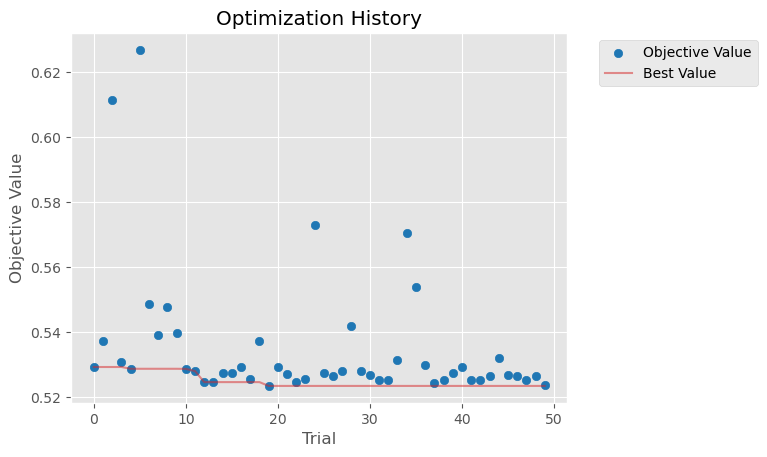

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1168552670.py:118: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

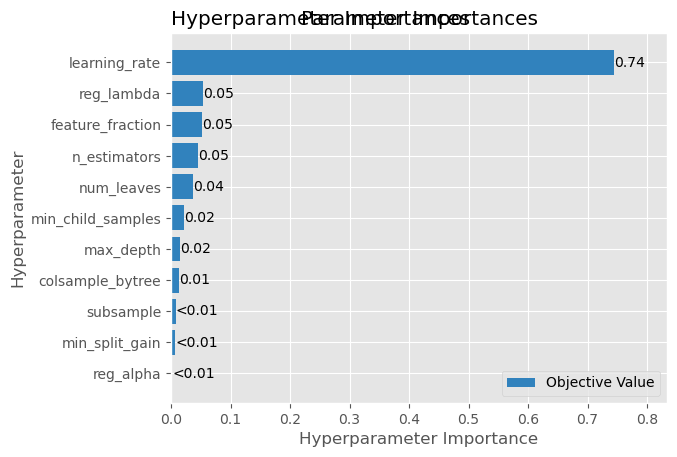

<Figure size 1200x600 with 0 Axes>

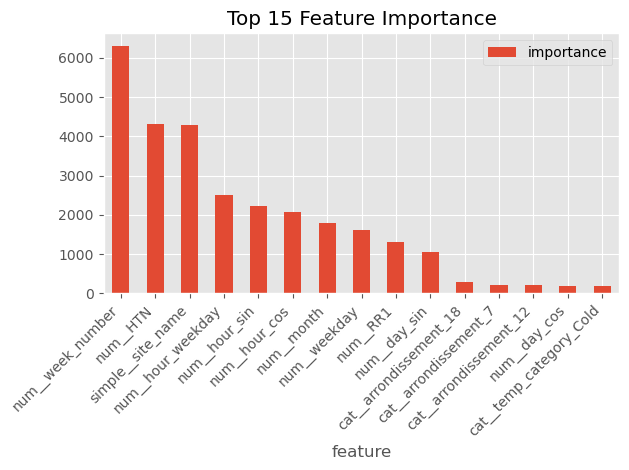

In [73]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def objective(trial):
    # Define hyperparameters with focused ranges
    params = {
        # Core parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'max_depth': trial.suggest_int('max_depth', 15, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        
        # Leaf-wise parameters
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        
        # Sampling parameters
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        
        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        
        # Additional parameters
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0)
    }
    
    # Create and train model
    lgb_model = make_pipeline(
        preprocessor,
        LGBMRegressor(
            **params,
            random_state=42,
            n_jobs=-1,
            objective='regression'
        )
    )
    
    # Use temporal split
    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
    
    # Fit on training data
    lgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_valid_pred = lgb_model.predict(X_valid)
    
    # Calculate RMSE
    valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    return valid_rmse

# Create study with pruner
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=5,
    interval_steps=3
)

study = optuna.create_study(
    direction='minimize',
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(n_startup_trials=10)
)

# Optimize with 50 trials
n_trials = 50
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Print optimization results
print('\nBest hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# Train best model
best_model = make_pipeline(
    preprocessor,
    LGBMRegressor(**study.best_params, random_state=42)
)

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y, delta_threshold="30 days")
best_model.fit(X_train, y_train)

# Make predictions
y_train_pred = best_model.predict(X_train)
y_valid_pred = best_model.predict(X_valid)

# Calculate metrics
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

print('\nFinal Model Performance:')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Valid RMSE: {valid_rmse:.2f}')

# Extract and display feature importance
feature_names = preprocessor.get_feature_names_out()
lgb_model = best_model.named_steps['lgbmregressor']
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 15 Most Important Features:')
print(importances.head(15))

# Visualization of optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Visualization of parameter importances
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances')
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 6))
importances.head(15).plot(x='feature', y='importance', kind='bar')
plt.title('Top 15 Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [71]:
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }
    
    # Create and train the model
    model = LGBMRegressor(**params)
    pipeline = make_pipeline(preprocessor, model)
    
    # Use cross-validation to evaluate the model
    cv_scores = cross_val_score(
        pipeline, X, y,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Return the average RMSE (note: we minimize the negative RMSE)
    return -cv_scores.mean()

# Create the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get the best parameters
best_params = study.best_params
print("\nBest parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Create and train the model with the best parameters
best_model = LGBMRegressor(**best_params)
best_pipeline = make_pipeline(preprocessor, best_model)

# Fit the model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = best_pipeline.predict(X_train)
y_valid_pred = best_pipeline.predict(X_valid)

# Calculate metrics
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print("\nResults with best parameters:")
print(f"Train set, RMSE={train_rmse:.2f}")
print(f"Valid set, RMSE={valid_rmse:.2f}")
print(f"Train set, R2={train_r2:.2f}")
print(f"Valid set, R2={valid_r2:.2f}")

# Plot optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Plot parameter importances
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances')
plt.show()

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-10 20:36:40,901] A new study created in memory with name: no-name-3646d81d-3a2a-498d-a09b-44f31b592010
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638[LightGBM] [Info] Total Bins 656

[LightGBM] [Info] Number of data points in the train set: 397461, number of used features: 40
[LightGBM] [Info] Number of data points in the train set: 397462, number of used features: 39
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Auto-choosing row

  0%|          | 0/50 [00:48<?, ?it/s]


[W 2024-12-10 20:37:29,403] Trial 0 failed with parameters: {'n_estimators': 319, 'max_depth': 14, 'learning_rate': 0.02181570086038441, 'num_leaves': 1871, 'min_child_samples': 17, 'subsample': 0.8898531171362551, 'colsample_bytree': 0.7295681025760485, 'reg_alpha': 0.0001424139155106348, 'reg_lambda': 5.733497820576368e-07} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_73266/1375840464.py", line 28, in objective
    cv_scores = cross_val_score(
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 712, in cr

KeyboardInterrupt: 

### Using Random Grid Search 

In [57]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define parameter grid - notice 'randomforestregressor' matches the step name in your pipeline
param_grid = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [5, 10],
    'randomforestregressor__min_samples_split': [2, 5]
}

# Using fewer splits for faster computation
tscv = TimeSeriesSplit(n_splits=3)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=best_pipe,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print results
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation RMSE: {-grid_search.best_score_:.4f}")

# Evaluate on validation set
best_model = grid_search.best_estimator_
valid_rmse = mean_squared_error(y_valid, best_model.predict(X_valid), squared=False)
print(f"Validation RMSE: {valid_rmse:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}
Best Cross-Validation RMSE: 1.0393
Validation RMSE: 0.8119


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [63]:
# Give the best pipe the best parameters

best_pipe.set_params(**grid_search.best_params_)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['counter_id', 'site_id',
                                                   'is_bank_holiday',
                                                   'is_school_holiday', 'month',
                                                   'weekday',
                                                   'arrondissement'])])),
                ('randomforestregressor', RandomForestRegressor(max_depth=10))])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import randint, uniform

# Define parameter distributions
param_distributions = {
    'extratreesregressor__n_estimators': randint(50, 300),
    'extratreesregressor__max_depth': randint(10, 50),
    'extratreesregressor__min_samples_split': randint(2, 20),
    'extratreesregressor__min_samples_leaf': randint(1, 10),
    'extratreesregressor__max_features': ['sqrt', 'log2', None]
}

# Create pipeline with ExtraTrees
extra_pipe = make_pipeline(preprocessor, ExtraTreesRegressor(random_state=42))

# Create and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=extra_pipe,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings to try
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1,
    verbose=1,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

# Fit the random search
random_search.fit(X_train, y_train)

# Print results
print("\nBest Parameters:", random_search.best_params_)
print(f"Best Cross-Validation RMSE: {-random_search.best_score_:.4f}")

# Evaluate on validation set
best_model = random_search.best_estimator_
valid_rmse = mean_squared_error(y_valid, best_model.predict(X_valid), squared=False)
print(f"Validation RMSE: {valid_rmse:.4f}")

# Print top 5 results
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
print("\nTop 5 Parameter Combinations:")
for idx, row in cv_results.head().iterrows():
    print(f"\nParameters: {row['params']}")
    print(f"Mean CV RMSE: {-row['mean_test_score']:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/kaggle_v

### Using Flaml

In [811]:
from flaml import AutoML
import numpy as np
from catboost import CatBoostClassifier

# Create AutoML instance
automl = AutoML()

# Configure FLAML
automl_settings = {
    "task": "regression",  
    "metric": "rmse",
    "time_budget": 120,
    "estimator_list": ["lgbm", "xgboost", "catboost", "rf", "extra_tree"],
    "eval_method": "holdout",
    "n_jobs": -1,
    "ensemble": True  # Enable stacking
}

# Using your preprocessed data
automl.fit(
    X_train=X_train_transformed, 
    y_train=y_train, 
    X_val=X_valid_transformed, 
    y_val=y_valid, 
    **automl_settings
)

# Get results
print(f"Best model: {automl.best_estimator}")
print(f"Best config: {automl.best_config}")
print(f"Validation RMSE: {automl.best_loss}")

# Make predictions
y_pred = automl.predict(X_valid_transformed)

[flaml.automl.logger: 12-11 15:21:04] {1728} INFO - task = regression
[flaml.automl.logger: 12-11 15:21:04] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 12-11 15:21:04] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-11 15:21:04] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 12-11 15:21:04] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree']
[flaml.automl.logger: 12-11 15:21:04] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-11 15:21:04] {2393} INFO - Estimated sufficient time budget=29289s. Estimated necessary time budget=63s.
[flaml.automl.logger: 12-11 15:21:04] {2442} INFO -  at 0.3s,	estimator lgbm's best error=1.2190,	best estimator lgbm's best error=1.2190
[flaml.automl.logger: 12-11 15:21:04] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-11 15:21:04] {2442} INFO -  at 0.3s,	estimator lgbm's best error=1.2190,	best estimato

In [ ]:
from flaml import AutoML
import numpy as np

# Create AutoML instance
automl = AutoML()

# Configure FLAML
automl_settings = {
    "task": "regression",  
    "metric": "rmse",
    "time_budget": 60,
    "estimator_list": ["lgbm", "rf", "xgboost"],
    "eval_method": "holdout",
    "n_jobs": -1
}

# Using your preprocessed data
automl.fit(
    X_train=X_train_transformed, 
    y_train=y_train, 
    X_val=X_valid_transformed, 
    y_val=y_valid, 
    **automl_settings
)

# Get results
print(f"Best model: {automl.best_estimator}")
print(f"Best config: {automl.best_config}")
print(f"Validation RMSE: {automl.best_loss}")

# Make predictions
y_pred = automl.predict(X_valid_transformed)

[flaml.automl.logger: 12-11 15:13:28] {1728} INFO - task = regression
[flaml.automl.logger: 12-11 15:13:28] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 12-11 15:13:28] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-11 15:13:29] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 12-11 15:13:29] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
[flaml.automl.logger: 12-11 15:13:29] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-11 15:13:29] {2393} INFO - Estimated sufficient time budget=41096s. Estimated necessary time budget=41s.
[flaml.automl.logger: 12-11 15:13:29] {2442} INFO -  at 0.9s,	estimator lgbm's best error=1.2190,	best estimator lgbm's best error=1.2190
[flaml.automl.logger: 12-11 15:13:29] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-11 15:13:29] {2442} INFO -  at 0.9s,	estimator lgbm's best error=1.2190,	best estimator lgbm's best error=1.2190

In [69]:
def evaluate_with_flaml(X_train, y_train, X_valid, y_valid, time_budget_seconds=60):
    """
    Evaluate models using FLAML AutoML with proper TimeSeriesSplit initialization
    """
    # Create preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), 
         categorical_features)
    ])
    
    # Preprocess data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_valid_processed = preprocessor.transform(X_valid)
    
    # Initialize AutoML
    automl = AutoML()
    
    # Create TimeSeriesSplit instance
    ts_split = TimeSeriesSplit(n_splits=5)
    
    # Configure settings for time series
    settings = {
        "time_budget": time_budget_seconds,
        "metric": 'rmse',
        "task": 'regression',
        "estimator_list": ['lgbm', 'xgboost', 'rf', 'extra_tree'],  # Changed 'extra_tree' to 'extra_trees'
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": ts_split,  # Pass the instance instead of the class
        "seed": 42,
        "verbose": 2
    }
    
    try:
        # Train AutoML
        automl.fit(
            X_train_processed, 
            y_train,
            **settings
        )
        
        # Get results
        best_model = automl.model.estimator
        best_config = automl.best_config
        
        # Calculate metrics
        train_pred = automl.predict(X_train_processed)
        valid_pred = automl.predict(X_valid_processed)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
        
        return {
            'best_model': best_model,
            'best_config': best_config,
            'train_rmse': train_rmse,
            'valid_rmse': valid_rmse,
            'automl': automl,
            'preprocessor': preprocessor
        }
    
    except Exception as e:
        print(f"An error occurred during FLAML evaluation: {str(e)}")
        return None

def compare_manual_and_flaml(X_train, y_train, X_valid, y_valid, manual_results, flaml_results):
    """
    Compare results from manual model selection and FLAML
    """
    if flaml_results is None:
        print("FLAML evaluation failed. Cannot compare results.")
        return None
        
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Model': ['Best Manual', 'FLAML'],
        'Train RMSE': [
            min(r['train_rmse'] for r in manual_results.values()),
            flaml_results['train_rmse']
        ],
        'Valid RMSE': [
            min(r['valid_rmse'] for r in manual_results.values()),
            flaml_results['valid_rmse']
        ]
    })
    
    return comparison.set_index('Model')

In [70]:
# Install flaml
%pip install flaml

from flaml import AutoML

Note: you may need to restart the kernel to use updated packages.


In [71]:
# Run FLAML evaluation
flaml_results = evaluate_with_flaml(
    X_train, y_train, 
    X_valid, y_valid,
    time_budget_seconds=300  # 5 minutes
)

# Compare results
if flaml_results is not None:
    comparison = compare_manual_and_flaml(
        X_train, y_train, 
        X_valid, y_valid,
        results,  
        flaml_results
    )
    print("\nComparison of approaches:")
    print(comparison)

    if flaml_results['valid_rmse'] < min(r['valid_rmse'] for r in results.values()):
        print("\nFLAML found better model!")
        print("\nBest configuration found by FLAML:")
        print(flaml_results['best_config'])

An error occurred during FLAML evaluation: '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 

# 7. Training model on the whole Training Set

In [38]:
def describe_pipeline(pipe):
    """
    Describe the components of a pipeline.

    Parameters
    ----------
    pipe : sklearn.pipeline.Pipeline
        The pipeline to describe.

    Returns
    -------
    None
    """
    for i, (name, step) in enumerate(pipe.steps):
        print(f"Step {i+1}: {name}")
        print(f"Component: {step}")
        print("-" * 30)

# Example usage:
# describe_pipeline(best_pipe)

In [39]:
describe_pipeline(model_solo)

AttributeError: 'RandomForestRegressor' object has no attribute 'steps'

In [40]:
# Fit on the entire dataset
solo_pipe.fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['counter_id', 'site_id',
                                                   'is_bank_holiday',
                                                   'is_school_holiday', 'month',
                                                   'weekday',
                                                   'arrondissement'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

# 8. Kaggle Preparation of the model

## Testing Set with my model

In [221]:
test_data.head()

counter_id              counter_name    site_id  \
0  100007049-102007049  28 boulevard Diderot E-O  100007049   
1  100007049-102007049  28 boulevard Diderot E-O  100007049   
2  100007049-102007049  28 boulevard Diderot E-O  100007049   
3  100007049-102007049  28 boulevard Diderot E-O  100007049   
4  100007049-102007049  28 boulevard Diderot E-O  100007049   

              site_name                date counter_installation_date  \
0  28 boulevard Diderot 2021-09-10 01:00:00                2013-01-18   
1  28 boulevard Diderot 2021-09-10 13:00:00                2013-01-18   
2  28 boulevard Diderot 2021-09-10 17:00:00                2013-01-18   
3  28 boulevard Diderot 2021-09-10 19:00:00                2013-01-18   
4  28 boulevard Diderot 2021-09-10 22:00:00                2013-01-18   

          coordinates counter_technical_id   latitude  longitude        ALTI  \
0  48.846028,2.375429          Y2H15027244  48.846027   2.375429  101.333333   
1  48.846028,2.375429          Y2H15027244  48.846027   2.375429  101.333333   
2  48.846028,2.375429          Y2H15027244  48.846027   2.375429  101.333333   
3  48.846028,2.375429          Y2H15027244  48.846027   2.375429  101.333333   
4  48.846028,2.375429          Y2H15027244  48.846027   2.375429  101.333333   

    RR1  QRR1  DRR1  QDRR1        FF  QFF          DD  QDD       FXY  QFXY  \
0  0.00   1.0   0.0    9.0  4.133333  1.0  203.333333  1.0  4.866667   1.0   
1  0.00   1.0   0.0    9.0  2.933333  1.0  203.333333  1.0  4.433333   1.0   
2  0.95   1.0  19.0    9.0  2.766667  1.0  286.666667  1.0  4.633333   1.0   
3  0.00   1.0   0.0    9.0  3.666667  1.0  306.666667  1.0  4.666667   1.0   
4  0.00   1.0   0.0    9.0  3.633333  1.0  280.000000  1.0  4.466667   1.0   

          DXY  QDXY          HXY  QHXY       FXI  QFXI         DXI  QDXI  \
0  220.000000   1.0    14.000000   9.0  7.866667   1.0  220.000000   1.0   
1  233.333333   1.0  1215.000000   9.0  7.366667   1.0  226.666667   1.0   
2  263.333333   1.0  1610.333333   9.0  8.133333   1.0  256.666667   1.0   
3  303.333333   1.0  1816.333333   9.0  7.033333   1.0  306.666667   1.0   
4  286.666667   1.0  2109.000000   9.0  7.233333   1.0  290.000000   1.0   

           HXI  QHXI     FXI3S    QFXI3S       HFXI3S  QHFXI3S          T  \
0    10.333333   9.0  7.333333  6.333333    16.333333      9.0  19.433333   
1  1230.333333   9.0  6.800000  6.333333  1218.333333      9.0  24.083333   
2  1605.666667   9.0  7.400000  6.333333  1608.666667      9.0  20.550000   
3  1835.333333   9.0  6.500000  6.333333  1822.000000      9.0  19.816667   
4  2108.000000   9.0  6.900000  6.333333  2109.666667      9.0  18.383333   

         QT     TD  QTD         TN       QTN          HTN  QHTN         TX  \
0  1.000000  16.70  1.0  19.433333  1.000000    41.166667   9.0  19.716667   
1  1.000000  16.75  1.0  22.733333  1.000000  1209.500000   9.0  24.383333   
2  1.000000  18.05  1.0  20.150000  1.000000  1627.833333   9.0  21.400000   
3  2.333333  16.15  1.0  19.816667  2.333333  1857.000000   9.0  20.366667   
4  1.000000  15.05  1.0  18.333333  1.000000  2153.333333   9.0  18.733333   

        QTX          HTX  QHTX   DG  QDG   T10  QT10   T20  QT20   T50  QT50  \
0  1.000000     3.500000   9.0  0.0  9.0  20.6   9.0  20.6   9.0  19.6   9.0   
1  1.000000  1241.833333   9.0  0.0  9.0  20.9   9.0  20.3   9.0  19.6   9.0   
2  1.000000  1608.000000   9.0  0.0  9.0  21.4   9.0  20.7   9.0  19.6   9.0   
3  2.333333  1801.166667   9.0  0.0  9.0  21.3   9.0  20.8   9.0  19.6   9.0   
4  1.000000  2101.000000   9.0  0.0  9.0  20.8   9.0  20.7   9.0  19.6   9.0   

   T100  QT100  TNSOL  QTNSOL  TN50  QTN50  TCHAUSSEE  QTCHAUSSEE     U   QU  \
0  18.4    9.0  17.50     9.0  18.4    9.0      18.40         9.0  85.0  1.0   
1  18.4    9.0  24.30     9.0  24.5    9.0      24.55         9.0  61.5  1.0   
2  18.4    9.0  19.50     9.0  18.9    9.0      20.75         9.0  84.0  1.0   
3  18.4    9.0  18.15     9.0  19.1    9.0      19.40 

In [104]:
from pathlib import Path
import holidays

def prepare_test_data(X_test, pipe):
    """
    Prepare test data with all necessary features to match training preprocessing
    """
    X_test = X_test.copy()
    
    # Basic date features
    X_test['year'] = X_test['date'].dt.year
    X_test['month'] = X_test['date'].dt.month
    X_test['day'] = X_test['date'].dt.day
    X_test['weekday'] = X_test['date'].dt.weekday
    X_test['hour'] = X_test['date'].dt.hour
    X_test['week_number'] = X_test['date'].dt.isocalendar().week
    
    # Period of day
    X_test['period_of_day'] = pd.cut(
        X_test['hour'],
        bins=[-1, 4, 9, 17, 20, 23],
        labels=['night', 'morning', 'daytime', 'evening', 'late_evening']
    )
    
    # Special time periods
    X_test['is_night'] = X_test['hour'].isin([23, 0, 1, 2, 3, 4]).astype(int)
    X_test['is_early_morning'] = X_test['hour'].isin([5, 6, 7]).astype(int)
    
    # Cyclic features
    X_test['hour_sin'] = np.sin(2 * np.pi * X_test['hour'] / 24)
    X_test['hour_cos'] = np.cos(2 * np.pi * X_test['hour'] / 24)
    X_test['day_sin'] = np.sin(2 * np.pi * X_test['weekday'] / 7)
    X_test['day_cos'] = np.cos(2 * np.pi * X_test['weekday'] / 7)
    
    # Holiday features
    fr_holidays = holidays.CountryHoliday('FR')
    X_test['is_bank_holiday'] = X_test['date'].apply(lambda x: 1 if x in fr_holidays else 0)
    X_test['is_school_holidays'] = get_school_holidays(X_test['date'])
    
    # District information
    X_test = add_district_information(X_test)
    X_test['arrondissement'] = X_test['arrondissement'].astype('category')
    
    # Direction and infrastructure features
    X_test['direction'] = X_test['counter_name'].str.extract('(N-S|S-N|E-O|O-E|NO-SE|SE-NO)')
    X_test['is_bridge'] = X_test['counter_name'].str.contains('Pont').astype(int)
    X_test['is_quai'] = X_test['counter_name'].str.contains('quai').astype(int)
    X_test['is_boulevard'] = X_test['counter_name'].str.contains('boulevard').astype(int)
    
    # Ensure categorical columns are properly typed
    categorical_columns = ['counter_id', 'counter_name', 'site_id', 'site_name', 
                         'counter_technical_id', 'period_of_day', 'direction']
    for col in categorical_columns:
        if col in X_test.columns:
            X_test[col] = X_test[col].astype('category')
    
    return X_test

def generate_submission(X_test, pipe, output_file="submission.csv"):
    """
    Generate submission file with proper error handling
    """
    try:
        # Prepare test data
        #X_test_prepared = prepare_test_data(X_test, pipe)
        
        # Make predictions
        y_pred = pipe.predict(X_test)
        
        # Create submission DataFrame
        results = pd.DataFrame({
            'Id': np.arange(len(y_pred)),
            'log_bike_count': y_pred
        })
        
        # Save results
        results.to_csv(output_file, index=False)
        print(f"Successfully generated submission file: {output_file}")
        
    except Exception as e:
        print(f"Error generating submission: {e}")
        raise

In [105]:
def generate_submission2(X_test, binary_pipe, regression_pipe, output_file="submission.csv"):
    """
    Generate submission file using two-stage prediction
    """
    try:
        # Make predictions using the two-stage approach
        y_pred = predict_two_stage(X_test, binary_pipe, regression_pipe)
        
        # Create submission DataFrame
        results = pd.DataFrame({
            'Id': np.arange(len(y_pred)),
            'log_bike_count': y_pred
        })
        
        # Save results
        results.to_csv(output_file, index=False)
        print(f"Successfully generated submission file: {output_file}")
        
        return results
        
    except Exception as e:
        print(f"Error generating submission: {e}")
        raise

# Usage example:
# generate_submission(test_data, binary_pipe, regression_pipe, "submission_two_stage.csv")

### Upload Kaggle

In [294]:
# Load and prepare test data
#X_test_prepared = prepare_test_data(test_data, solo_pipe)

# Generate submission
generate_submission(X_test_prepared, model_solo_importance, output_file="submission3.csv")

Successfully generated submission file: submission3.csv
